In [ ]:
!pip install pandas
!pip install theano
!pip install numpy
!pip install matplotlib
!pip install networkx
!pip install arviz
!pip install pymc3
!pip install scipy
!pip install scikit-learn
!pip install arviz

In [113]:
# general
import pandas as pd
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import arviz as az
import pymc3 as pm
import math
from scipy.optimize import curve_fit
# Pre-processing
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import arviz as az
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
plt.rcParams["figure.figsize"] = 20, 10


In [76]:
def standard_transform(df, cols):
    mean_dict = {}
    std_dict = {}
    df_transformed = pd.DataFrame()
    for col in cols:
        col_mean = df[col].mean()
        col_std = df[col].std()
        df_transformed[col] = ((df[col] - col_mean) / col_std)
        mean_dict[col] = col_mean
        std_dict[col] = col_std
    return df_transformed, mean_dict, std_dict


In [77]:
# helper functions
def apply_mean_center(x):
    mu = np.nanmean(x)
    xm = x/mu
    return xm, mu


def mean_center_transform(df, cols):
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc


def mean_center_transform_excl0(df, cols):
    df_new = pd.DataFrame()
    sc = {}
    df = df.replace(0, np.nan)
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    df_new = df_new.replace(np.nan, 0)
    return df_new, sc


# Outlier distribution
def outlier_distribution(data):
    numeric_var_names = [key for key in dict(data.dtypes) if
                         dict(data.dtypes)[key] in ['float64', 'int64',
                                                    'float32', 'int32']]
    num = data[numeric_var_names]

    def var_summary(x):
        return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(),
                         x.median(),  x.std(), x.var(), x.min(),
                         x.dropna().quantile(0.01), x.dropna().quantile(0.05),
                         x.dropna().quantile(0.10), x.dropna().quantile(0.25),
                         x.dropna().quantile(0.50), x.dropna().quantile(0.75),
                         x.dropna().quantile(0.90), x.dropna().quantile(0.95),
                         x.dropna().quantile(0.99), x.max()],
                         index=['N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD',
                         'VAR', 'MIN', 'P1', 'P5', 'P10', 'P25', 'P50', 'P75',
                                'P90', 'P95', 'P99', 'MAX'])

    num_summary = num.apply(lambda x: var_summary(x)).T
    return num_summary


def apply_adstock(df, col, L=8, P=3, D=1.8):
    """
    params:
    x: original media variable - column name
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    """
    x = np.array(df[col])
    x = np.append(np.zeros(L-1), x)
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    return np.array(adstocked_x)


def saturation(x, s, k):
    return 1/(1 + (x/k)**(-s))


def hill_saturation_neu(x, s, k):
    return 1/(1 + (x/k)**(-s))


def apply_transform(df, col, mean_transform_lkp):
    return np.log1p(df[col])/mean_transform_lkp[col]


def geometric_adstock(x, theta, alpha, L=3):
    w = tt.as_tensor_variable([tt.power(alpha, tt.power(i - theta, 2))
                              for i in range(L)])
    xx = tt.stack([tt.concatenate([tt.zeros(i), x[:x.shape[0] - i]])
                  for i in range(L)])
    return tt.dot(w/tt.sum(w), xx)


def logistic_function(x_t, mu=0.1):
    return (1*(1 - np.exp(-mu*x_t)))/(1 + np.exp(-mu*x_t))


def scale_transform(df, cols, range_min=0, range_max=1):
    min_dict = {}
    max_dict = {}
    df_transformed = pd.DataFrame()
    for col in cols:
        col_min = df[col].min()
        col_max = df[col].max()
        df_transformed[col] = (((df[col] - col_min) / (col_max - col_min)) *
                               (range_max - range_min)) + range_min
        min_dict[col] = col_min
        max_dict[col] = col_max
    return df_transformed, min_dict, max_dict


def revert_scale_transform(df_transformed, cols, min_lookup, max_lookup,
                           range_min=0, range_max=1):
    df_actual = pd.DataFrame()
    for col in cols:
        if 'TGT' in col:
            col_min = min_lookup['TGT']
            col_max = max_lookup['TGT']
        else:
            col_min = min_lookup[col]
            col_max = max_lookup[col]
        df_actual[col] = (((df_transformed[col] - range_min) / (range_max -
                          range_min)) * (col_max - col_min)) + col_min
    return df_actual


In [78]:
# Some kernel definition that will be tried here
# note that the experiments have been carried out without adding mean of the
# child


def root_kernel(x, st):
    return x
# Did not work
# no curve


def sqrt_kernel(x):
    return x**(0.5)
# NaN error


def inv_sqrt_kernel(x):
    return x**(-0.5)
# Flat response, amplifying power will not work it seems


def sq_kernel(x):
    return x**4


# offsetting variation with other does not work
def offset_variation(x, distrooffset):
    return 1 - (x - distrooffset)


# better curve fit and less divergences but slightly more error
def laplace_kernel(x, st):
    return np.exp(-np.abs(x-st))

# Offset variation with mu and Laplace offset works well
# Anything without mu is worse
# Laplace beta with mu works
# Laplacein beta+ poly kernel with mu is better than original
# More power means more performance 4 works best, 6 is overshoot


In [79]:
# Some kernel definition that will be tried here
# note that the experiments have been carried out without adding mean of the
# child


def root_kernel(x, st):
    return x


# Did not work
# no curve
def sqrt_kernel(x):
    return x**(0.5)


# NaN error
def inv_sqrt_kernel(x):
    return x**(-0.5)


# Flat response, amplifying power will not work it seems
def sq_kernel(x):
    return x**4


# offsetting variation with other does not work
def offset_variation(x, distrooffset):
    return 1 - (x - distrooffset)


# better curve fit and less divergences but slightly more error
def laplace_kernel(x, st):
    return np.exp(-np.abs(x-st))

# Offset variation with mu and Laplace offset works well
# Anything without mu is worse
# Laplace beta with mu works
# Laplacein beta+ poly kernel with mu is better than original
# More power means more performance 4 works best, 6 is overshoot


In [80]:
df_init = pd.read_csv('final_df_random.csv')
df_init.head()

,core_amazondisplay_impressions_sum,core_amazondisplay_impressions_median,core_amazondisplay_impressions_min,core_amazondisplay_impressions_max,core_amazondisplay_impressions_var,core_amazondisplay_impressions_std,core_amazonsearch_impressions_sum,core_amazonsearch_impressions_median,core_amazonsearch_impressions_min,core_amazonsearch_impressions_max,core_amazonsearch_impressions_var,core_amazonsearch_impressions_std,core_bvod_impressions_sum,core_bvod_impressions_median,core_bvod_impressions_min,core_bvod_impressions_max,core_bvod_impressions_var,core_bvod_impressions_std,core_digitalpartnership_impressions_sum,core_digitalpartnership_impressions_median,core_digitalpartnership_impressions_min,core_digitalpartnership_impressions_max,core_digitalpartnership_impressions_var,core_digitalpartnership_impressions_std,core_facebook_impressions_sum,core_facebook_impressions_median,core_facebook_impressions_min,core_facebook_impressions_max,core_facebook_impressions_var,core_facebook_impressions_std,core_olv_impressions_sum,core_olv_impressions_median,core_olv_impressions_min,core_olv_impressions_max,core_olv_impressions_var,core_olv_impressions_std,core_search_impressions_sum,core_search_impressions_median,core_search_impressions_min,core_search_impressions_max,core_search_impressions_var,core_search_impressions_std,core_tv_impressions_sum,core_tv_impressions_median,core_tv_impressions_min,core_tv_impressions_max,core_tv_impressions_var,core_tv_impressions_std,core_youtube_impressions_sum,core_youtube_impressions_median,core_youtube_impressions_min,core_youtube_impressions_max,core_youtube_impressions_var,core_youtube_impressions_std,core_amazondisplay_spend_sum,core_amazondisplay_spend_median,core_amazondisplay_spend_min,core_amazondisplay_spend_max,core_amazondisplay_spend_var,core_amazondisplay_spend_std,core_amazonsearch_spend_sum,core_amazonsearch_spend_median,core_amazonsearch_spend_min,core_amazonsearch_spend_max,core_amazonsearch_spend_var,core_amazonsearch_spend_std,core_bvod_spend_sum,core_bvod_spend_median,core_bvod_spend_min,core_bvod_spend_max,core_bvod_spend_var,core_bvod_spend_std,core_digitalpartnership_spend_sum,core_digitalpartnership_spend_median,core_digitalpartnership_spend_min,core_digitalpartnership_spend_max,core_digitalpartnership_spend_var,core_digitalpartnership_spend_std,core_facebook_spend_sum,core_facebook_spend_median,core_facebook_spend_min,core_facebook_spend_max,core_facebook_spend_var,core_facebook_spend_std,core_olv_spend_sum,core_olv_spend_median,core_olv_spend_min,core_olv_spend_max,core_olv_spend_var,core_olv_spend_std,core_search_spend_sum,core_search_spend_median,core_search_spend_min,core_search_spend_max,core_search_spend_var,core_search_spend_std,core_tv_spend_sum,core_tv_spend_median,core_tv_spend_min,core_tv_spend_max,core_tv_spend_var,core_tv_spend_std,core_youtube_spend_sum,core_youtube_spend_median,core_youtube_spend_min,core_youtube_spend_max,core_youtube_spend_var,core_youtube_spend_std,core_amazondisplay_cpp,core_amazonsearch_cpp,core_bvod_cpp,core_digitalpartnership_cpp,core_facebook_cpp,core_olv_cpp,core_search_cpp,core_tv_cpp,core_youtube_cpp,npd_amazondisplay_impressions_sum,npd_amazondisplay_impressions_median,npd_amazondisplay_impressions_min,npd_amazondisplay_impressions_max,npd_amazondisplay_impressions_var,npd_amazondisplay_impressions_std,npd_bvod_impressions_sum,npd_bvod_impressions_median,npd_bvod_impressions_min,npd_bvod_impressions_max,npd_bvod_impressions_var,npd_bvod_impressions_std,npd_cinema_impressions_sum,npd_cinema_impressions_median,npd_cinema_impressions_min,npd_cinema_impressions_max,npd_cinema_impressions_var,npd_cinema_impressions_std,npd_facebook_impressions_sum,npd_facebook_impressions_median,npd_facebook_impressions_min,npd_facebook_impressions_max,npd_facebook_impressions_var,npd_facebook_impressions_std,npd_ooh_impressions_sum,npd_ooh_impressions_median,npd_ooh_impressions_min,npd_ooh_impressions_max,npd_ooh_impressions_var,npd_ooh_impressions_std,npd_s

In [81]:
df_init['week_id'] = pd.to_datetime(df_init['week_id'], format = '%Y-%m-%d').dt.date

In [82]:
week_index = df_init.reset_index()['week_id']

In [83]:
df_init.head()

,core_amazondisplay_impressions_sum,core_amazondisplay_impressions_median,core_amazondisplay_impressions_min,core_amazondisplay_impressions_max,core_amazondisplay_impressions_var,core_amazondisplay_impressions_std,core_amazonsearch_impressions_sum,core_amazonsearch_impressions_median,core_amazonsearch_impressions_min,core_amazonsearch_impressions_max,core_amazonsearch_impressions_var,core_amazonsearch_impressions_std,core_bvod_impressions_sum,core_bvod_impressions_median,core_bvod_impressions_min,core_bvod_impressions_max,core_bvod_impressions_var,core_bvod_impressions_std,core_digitalpartnership_impressions_sum,core_digitalpartnership_impressions_median,core_digitalpartnership_impressions_min,core_digitalpartnership_impressions_max,core_digitalpartnership_impressions_var,core_digitalpartnership_impressions_std,core_facebook_impressions_sum,core_facebook_impressions_median,core_facebook_impressions_min,core_facebook_impressions_max,core_facebook_impressions_var,core_facebook_impressions_std,core_olv_impressions_sum,core_olv_impressions_median,core_olv_impressions_min,core_olv_impressions_max,core_olv_impressions_var,core_olv_impressions_std,core_search_impressions_sum,core_search_impressions_median,core_search_impressions_min,core_search_impressions_max,core_search_impressions_var,core_search_impressions_std,core_tv_impressions_sum,core_tv_impressions_median,core_tv_impressions_min,core_tv_impressions_max,core_tv_impressions_var,core_tv_impressions_std,core_youtube_impressions_sum,core_youtube_impressions_median,core_youtube_impressions_min,core_youtube_impressions_max,core_youtube_impressions_var,core_youtube_impressions_std,core_amazondisplay_spend_sum,core_amazondisplay_spend_median,core_amazondisplay_spend_min,core_amazondisplay_spend_max,core_amazondisplay_spend_var,core_amazondisplay_spend_std,core_amazonsearch_spend_sum,core_amazonsearch_spend_median,core_amazonsearch_spend_min,core_amazonsearch_spend_max,core_amazonsearch_spend_var,core_amazonsearch_spend_std,core_bvod_spend_sum,core_bvod_spend_median,core_bvod_spend_min,core_bvod_spend_max,core_bvod_spend_var,core_bvod_spend_std,core_digitalpartnership_spend_sum,core_digitalpartnership_spend_median,core_digitalpartnership_spend_min,core_digitalpartnership_spend_max,core_digitalpartnership_spend_var,core_digitalpartnership_spend_std,core_facebook_spend_sum,core_facebook_spend_median,core_facebook_spend_min,core_facebook_spend_max,core_facebook_spend_var,core_facebook_spend_std,core_olv_spend_sum,core_olv_spend_median,core_olv_spend_min,core_olv_spend_max,core_olv_spend_var,core_olv_spend_std,core_search_spend_sum,core_search_spend_median,core_search_spend_min,core_search_spend_max,core_search_spend_var,core_search_spend_std,core_tv_spend_sum,core_tv_spend_median,core_tv_spend_min,core_tv_spend_max,core_tv_spend_var,core_tv_spend_std,core_youtube_spend_sum,core_youtube_spend_median,core_youtube_spend_min,core_youtube_spend_max,core_youtube_spend_var,core_youtube_spend_std,core_amazondisplay_cpp,core_amazonsearch_cpp,core_bvod_cpp,core_digitalpartnership_cpp,core_facebook_cpp,core_olv_cpp,core_search_cpp,core_tv_cpp,core_youtube_cpp,npd_amazondisplay_impressions_sum,npd_amazondisplay_impressions_median,npd_amazondisplay_impressions_min,npd_amazondisplay_impressions_max,npd_amazondisplay_impressions_var,npd_amazondisplay_impressions_std,npd_bvod_impressions_sum,npd_bvod_impressions_median,npd_bvod_impressions_min,npd_bvod_impressions_max,npd_bvod_impressions_var,npd_bvod_impressions_std,npd_cinema_impressions_sum,npd_cinema_impressions_median,npd_cinema_impressions_min,npd_cinema_impressions_max,npd_cinema_impressions_var,npd_cinema_impressions_std,npd_facebook_impressions_sum,npd_facebook_impressions_median,npd_facebook_impressions_min,npd_facebook_impressions_max,npd_facebook_impressions_var,npd_facebook_impressions_std,npd_ooh_impressions_sum,npd_ooh_impressions_median,npd_ooh_impressions_min,npd_ooh_impressions_max,npd_ooh_impressions_var,npd_ooh_impressions_std,npd_s

In [84]:
COLS = [
    'TGT',
    'MARKETING_ONLINE',
    'MARKETING_OFFLINE',
    'MARKETING_ONLINE_SP',
    'MARKETING_OFFLINE_SP',
    'PROMO',
    'PRICE',
    'DISTRIBUTION',
    'OTHER_PRODUCTS',
    'COMPETITION',
    'EXT_SHOCKS']
COLS_DICT = dict(zip(COLS, [[]]*len(COLS)))
COLS_DICT['MARKETING_ONLINE'] = [
    x for x in df_init.columns if
    ('core' in x) &
    (('impressions' in x) | ('cpp' in x) | ('spend' in x)) &
    (x.split('_')[1].lower() not in ['cinema', 'tv', 'bvod', 'ooh', 'radio'])
]
existing = list(COLS_DICT['MARKETING_ONLINE'])

COLS_DICT['MARKETING_OFFLINE'] = [
    x for x in df_init.columns if
    ('core' in x) &
    (('impressions' in x) | ('cpp' in x) | ('spend' in x)) &
    (x.split('_')[1].lower() in ['cinema', 'tv', 'bvod', 'ooh', 'radio'])
]
existing.extend(list(COLS_DICT['MARKETING_OFFLINE']))

COLS_DICT['PROMO'] = [
    x for x in df_init.columns if
    ('core' in x) &
    ('promo' in x)
]
existing.extend(list(COLS_DICT['PROMO']))

COLS_DICT['PRICE'] = [
    x for x in df_init.columns if
    ('core' in x) &
    ('price' in x)
]
existing.extend(list(COLS_DICT['PRICE']))

COLS_DICT['TGT'] = [
    x for x in df_init.columns if
    (x not in existing) &
    ('core' in x) &
    ('sales' in x)
]
existing.extend(list(COLS_DICT['TGT']))

COLS_DICT['DISTRIBUTION'] = [
    x for x in df_init.columns if
    (x not in existing) &
    ('core' in x)
]
existing.extend(list(COLS_DICT['DISTRIBUTION']))

COLS_DICT['OTHER_PRODUCTS'] = [
    x for x in df_init.columns if
    (x not in existing) &
    ('npd' in x) |
    (x.split('_')[0].lower() in ['em', 'candles', 'reeds'])
]
existing.extend(list(COLS_DICT['OTHER_PRODUCTS']))

COLS_DICT['COMPETITION'] = [
    x for x in df_init.columns if
    (x not in existing) &
    ('comp' in x)
]
existing.extend(list(COLS_DICT['COMPETITION']))

COLS_DICT['EXT_SHOCKS'] = [ 
    x for x in df_init.columns if
    (x not in existing)
]
existing.extend(list(COLS_DICT['EXT_SHOCKS']))

assert len(np.unique(existing)) == len(np.unique(df_init.columns))


In [85]:
# Create a dataframe: first iteration - impressions for media, units for sales
df_proc = df_init.copy()

COLS_DICT_SUBSET = dict()

# sales-based
COLS_DICT_SUBSET['TGT'] = [x for x in COLS_DICT['TGT'] if ('units' in x) &
                           ('sum' in x)]
COLS_DICT_SUBSET['PROMO'] = [x for x in COLS_DICT['PROMO'] if ('units' in x) &
                             ('sum' in x)]
COLS_DICT_SUBSET['COMPETITION'] = [x for x in COLS_DICT['COMPETITION'] if
                                   ('units' in x) & ('sum' in x)]


# media-based
COLS_DICT_SUBSET['MARKETING_ONLINE'] = [x for x in
                                        COLS_DICT['MARKETING_ONLINE']
                                        if ('impressions' in x) & ('sum' in x)]
COLS_DICT_SUBSET['MARKETING_ONLINE_SP'] = [x for x in
                                           COLS_DICT['MARKETING_ONLINE']
                                           if ('spend' in x) & ('sum' in x)]
COLS_DICT_SUBSET['MARKETING_OFFLINE'] = [x for x in
                                         COLS_DICT['MARKETING_OFFLINE'] if
                                         ('impressions' in x) & ('sum' in x)]
COLS_DICT_SUBSET['MARKETING_OFFLINE_SP'] = [x for x in
                                            COLS_DICT['MARKETING_OFFLINE']
                                            if ('spend' in x) & ('sum' in x)]
COLS_DICT_SUBSET['OTHER_PRODUCTS'] = [x for x in COLS_DICT['OTHER_PRODUCTS'] if
                                      ('impressions' in x) & ('sum' in x)]

# other
COLS_DICT_SUBSET['DISTRIBUTION'] = [x for x in COLS_DICT['DISTRIBUTION']
                                    if ('sum' in x)]
COLS_DICT_SUBSET['PRICE'] = COLS_DICT['PRICE']
COLS_DICT_SUBSET['seasonality_holidays'] = [x for x in COLS_DICT['EXT_SHOCKS']
                                            if ('seasonality_holidays' in x)]
COLS_DICT_SUBSET['covid_new_cases'] = [x for x in COLS_DICT['EXT_SHOCKS'] if
                                       ('new_cases' in x)]


In [86]:
df_proc=df_proc.sort_values(by=['week_id']).reset_index(drop=True)

# Fillna with zero
df_proc=df_proc.fillna(0)
df_proc = df_proc.drop(['week_id'], axis =1)



In [87]:
df_proc.head()

,core_amazondisplay_impressions_sum,core_amazondisplay_impressions_median,core_amazondisplay_impressions_min,core_amazondisplay_impressions_max,core_amazondisplay_impressions_var,core_amazondisplay_impressions_std,core_amazonsearch_impressions_sum,core_amazonsearch_impressions_median,core_amazonsearch_impressions_min,core_amazonsearch_impressions_max,core_amazonsearch_impressions_var,core_amazonsearch_impressions_std,core_bvod_impressions_sum,core_bvod_impressions_median,core_bvod_impressions_min,core_bvod_impressions_max,core_bvod_impressions_var,core_bvod_impressions_std,core_digitalpartnership_impressions_sum,core_digitalpartnership_impressions_median,core_digitalpartnership_impressions_min,core_digitalpartnership_impressions_max,core_digitalpartnership_impressions_var,core_digitalpartnership_impressions_std,core_facebook_impressions_sum,core_facebook_impressions_median,core_facebook_impressions_min,core_facebook_impressions_max,core_facebook_impressions_var,core_facebook_impressions_std,core_olv_impressions_sum,core_olv_impressions_median,core_olv_impressions_min,core_olv_impressions_max,core_olv_impressions_var,core_olv_impressions_std,core_search_impressions_sum,core_search_impressions_median,core_search_impressions_min,core_search_impressions_max,core_search_impressions_var,core_search_impressions_std,core_tv_impressions_sum,core_tv_impressions_median,core_tv_impressions_min,core_tv_impressions_max,core_tv_impressions_var,core_tv_impressions_std,core_youtube_impressions_sum,core_youtube_impressions_median,core_youtube_impressions_min,core_youtube_impressions_max,core_youtube_impressions_var,core_youtube_impressions_std,core_amazondisplay_spend_sum,core_amazondisplay_spend_median,core_amazondisplay_spend_min,core_amazondisplay_spend_max,core_amazondisplay_spend_var,core_amazondisplay_spend_std,core_amazonsearch_spend_sum,core_amazonsearch_spend_median,core_amazonsearch_spend_min,core_amazonsearch_spend_max,core_amazonsearch_spend_var,core_amazonsearch_spend_std,core_bvod_spend_sum,core_bvod_spend_median,core_bvod_spend_min,core_bvod_spend_max,core_bvod_spend_var,core_bvod_spend_std,core_digitalpartnership_spend_sum,core_digitalpartnership_spend_median,core_digitalpartnership_spend_min,core_digitalpartnership_spend_max,core_digitalpartnership_spend_var,core_digitalpartnership_spend_std,core_facebook_spend_sum,core_facebook_spend_median,core_facebook_spend_min,core_facebook_spend_max,core_facebook_spend_var,core_facebook_spend_std,core_olv_spend_sum,core_olv_spend_median,core_olv_spend_min,core_olv_spend_max,core_olv_spend_var,core_olv_spend_std,core_search_spend_sum,core_search_spend_median,core_search_spend_min,core_search_spend_max,core_search_spend_var,core_search_spend_std,core_tv_spend_sum,core_tv_spend_median,core_tv_spend_min,core_tv_spend_max,core_tv_spend_var,core_tv_spend_std,core_youtube_spend_sum,core_youtube_spend_median,core_youtube_spend_min,core_youtube_spend_max,core_youtube_spend_var,core_youtube_spend_std,core_amazondisplay_cpp,core_amazonsearch_cpp,core_bvod_cpp,core_digitalpartnership_cpp,core_facebook_cpp,core_olv_cpp,core_search_cpp,core_tv_cpp,core_youtube_cpp,npd_amazondisplay_impressions_sum,npd_amazondisplay_impressions_median,npd_amazondisplay_impressions_min,npd_amazondisplay_impressions_max,npd_amazondisplay_impressions_var,npd_amazondisplay_impressions_std,npd_bvod_impressions_sum,npd_bvod_impressions_median,npd_bvod_impressions_min,npd_bvod_impressions_max,npd_bvod_impressions_var,npd_bvod_impressions_std,npd_cinema_impressions_sum,npd_cinema_impressions_median,npd_cinema_impressions_min,npd_cinema_impressions_max,npd_cinema_impressions_var,npd_cinema_impressions_std,npd_facebook_impressions_sum,npd_facebook_impressions_median,npd_facebook_impressions_min,npd_facebook_impressions_max,npd_facebook_impressions_var,npd_facebook_impressions_std,npd_ooh_impressions_sum,npd_ooh_impressions_median,npd_ooh_impressions_min,npd_ooh_impressions_max,npd_ooh_impressions_var,npd_ooh_impressions_std,npd_s

In [107]:
# Outlier capping
for col in df_proc.columns:
    percentiles = df_proc[col].quantile([0.01, 0.99]).values
    df_proc[col] = np.clip(df_proc[col], percentiles[0], percentiles[1])
# Media impressions
df_proc_media = df_proc[COLS_DICT_SUBSET['MARKETING_ONLINE'] +
                        COLS_DICT_SUBSET['MARKETING_OFFLINE']]

# mean center data
mean_dict_media = {}
for col in df_proc_media.columns:
    mean_dict_media[f"{col.lower()}_mean"] = df_proc_media[col].mean()

# Applying mean center transformation
df_transformed_media, transform_lookup_media =\
mean_center_transform_excl0(df_proc_media, df_proc_media.columns)
data = pd.DataFrame()
for (k, v) in COLS_DICT_SUBSET.items():
    if k == 'MARKETING_OFFLINE':
        data[k] = df_transformed_media[v].sum(axis=1)
    elif k == 'MARKETING_ONLINE':
        data[k] = df_proc_media[v].sum(axis=1)
    elif k == 'PRICE':
        data[k] = df_proc[v].median(axis=1)
    else:
        data[k] = df_proc[v].sum(axis=1)
data2 = pd.concat([data, df_transformed_media,
                   df_proc[COLS_DICT_SUBSET['MARKETING_ONLINE_SP'] +\
                           COLS_DICT_SUBSET['MARKETING_OFFLINE_SP']]], axis=1)

# Adding absolute minimum for holidays to avoid -ve values before log
# transformation
data2['seasonality_holidays'] = data2['seasonality_holidays'] +\
abs(data2.seasonality_holidays.min())


# Log transformation
log_data2 = pd.DataFrame()
for col in data2.columns:
    log_data2[col] = np.log(data2[col] + 1)

# Applying mean center transformation
df_transformed, transform_lookup =\
mean_center_transform_excl0(log_data2, log_data2.columns)

# Storing final data mean and sigma
data_dict = {}
mean_dict = {}
sigma_dict = {}
for col in df_transformed.columns:
    data_dict[col.lower()] = df_transformed[col].values
    mean_dict[f"{col.lower()}_mean"] = df_transformed[col].mean()
    sigma_dict[f"{col.lower()}_sigma"] = df_transformed[col].std()


## Original Approach with linear nodes

In this approach based on Jian et. al. the hierachy between parents and children is passed through linear combination not accounting for the relationaship between parent and children. The information is passed as mean of the children distribution. Adstock effect is accounted for.

In [89]:
%%time
with pm.Model() as py_stan_dag2:
    
    ################################ Defining Mean & Sigma ################################
    len_df = len(data_dict['tgt'])
    seasonality_holidays_mean = mean_dict['seasonality_holidays_mean']
    covid_new_cases_mean = mean_dict['covid_new_cases_mean']
    seasonality_holidays_sigma = sigma_dict['seasonality_holidays_sigma']
    covid_new_cases_sigma = sigma_dict['covid_new_cases_sigma']
    price_mean = mean_dict['price_mean']
    price_sigma = sigma_dict['price_sigma']
    marketing_offline_sigma = sigma_dict['marketing_offline_sigma']
    marketing_offline_mean = mean_dict['marketing_offline_mean']
    promo_sigma = sigma_dict['promo_sigma']
    promo_mean = mean_dict['promo_mean']
    distribution_sigma = sigma_dict['distribution_sigma']
    distribution_mean = mean_dict['distribution_mean']
    competition_sigma = sigma_dict['competition_sigma']
    competition_mean = mean_dict['competition_mean']
    other_products_sigma = sigma_dict['other_products_sigma']
    other_products_mean = mean_dict['other_products_mean']
    marketing_online_sigma = sigma_dict['marketing_online_sigma']
    marketing_online_mean = mean_dict['marketing_online_mean']
    tgt_mean = mean_dict['tgt_mean']
    
    tgt_sigma = pm.HalfNormal('tgt_sigma', 1)
    ################################ Defining Beta's ################################
    BoundedNormal =pm.Bound(pm.Normal, upper=0)
    #tgt_sigma = pm.HalfNormal('tgt_sigma', 1)
    beta_price_to_promo=BoundedNormal('beta_price_to_promo',0,1)
    beta_seasonality_holidays_to_promo = pm.Normal('beta_seasonality_holidays_to_promo',0, 1)
    beta_covid_new_cases_to_promo = pm.Normal('beta_covid_new_cases_to_promo',0, 1)
    beta_offline_to_online = pm.HalfNormal('beta_offline_to_online',1)
    beta_seasonality_holidays_to_online=BoundedNormal('beta_seasonality_holidays_to_online',0,1)
    beta_covid_new_cases_to_online=BoundedNormal('beta_covid_new_cases_to_online',0,1)    
    beta_seasonality_holidays_to_distribution = pm.Normal('beta_seasonality_holidays_to_distribution',0, 1)
    beta_covid_new_cases_to_distribution = pm.Normal('beta_covid_new_cases_to_distribution',0, 1)
    beta_price_to_competition = pm.Normal('beta_price_to_competition',0, 1)
    beta_seasonality_holidays_to_competition = pm.Normal('beta_seasonality_holidays_to_competition',0, 1)
    beta_covid_new_cases_to_competition = pm.Normal('beta_covid_new_cases_to_competition',0, 1)
    beta_promo_to_competition=BoundedNormal('beta_promo_to_competition',0,1)
    beta_online_to_competition=BoundedNormal('beta_online_to_competition',0,1)
    beta_distribution_to_competition=BoundedNormal('beta_distribution_to_competition',0,1)
    beta_offline_to_competition = pm.Normal('beta_offline_to_competition',0, 1)
    beta_price_to_otherprod = pm.Normal('beta_price_to_otherprod',0, 1)
    beta_seasonality_holidays_to_otherprod = pm.Normal('beta_seasonality_holidays_to_otherprod',0, 1)
    beta_covid_new_cases_to_otherprod = pm.Normal('beta_covid_new_cases_to_otherprod',0, 1)
    beta_promo_to_otherprod = pm.Normal('beta_promo_to_otherprod',0, 1)
    beta_online_to_otherprod = pm.Normal('beta_online_to_otherprod',0, 1)
    beta_offline_to_otherprod = pm.Normal('beta_offline_to_otherprod',0, 1)
    beta_seasonality_holidays_to_offline = pm.Normal('beta_seasonality_holidays_to_offline',0, 1)
    beta_covid_new_cases_to_offline = pm.Normal('beta_covid_new_cases_to_offline',0, 1)
    beta_promo_to_offline = pm.Normal('beta_promo_to_offline',0, 1)
    beta_price_to_offline = pm.Normal('beta_price_to_offline',0, 1) 
    beta_seasonality_holidays_to_tgt=BoundedNormal('beta_seasonality_holidays_to_tgt',0,1)
    beta_covid_new_cases_to_tgt=BoundedNormal('beta_covid_new_cases_to_tgt',0,1)
    beta_distribution_to_tgt = pm.HalfNormal('beta_distribution_to_tgt', 1)
    beta_competition_to_tgt=BoundedNormal('beta_competition_to_tgt',0,1)
    beta_online_to_tgt = pm.HalfNormal('beta_online_to_tgt', 1)
    beta_price_to_tgt=BoundedNormal('beta_price_to_tgt',0,1)
    beta_promo_to_tgt = pm.HalfNormal('beta_promo_to_tgt', 1)
    beta_otherprod_to_tgt = pm.HalfNormal('beta_otherprod_to_tgt', 1)
    beta_offline_to_tgt = pm.HalfNormal('beta_offline_to_tgt', 1)

    seasonality_holidays_alpha = pm.Normal('seasonality_holidays_alpha',0, 1)
    covid_new_cases_alpha = pm.Normal('covid_new_cases_alpha',0, 1)
    promo_mu = pm.Normal('promo_mu',promo_mean, sigma=promo_sigma, shape=len_df)
    price_mu = pm.Normal('price_mu',price_mean, sigma=price_sigma, shape=len_df)
    marketing_online_mu = pm.Normal('marketing_online_mu', marketing_online_mean, sigma=2*marketing_online_sigma, shape=len_df)
    distribution_mu = pm.Normal('distribution_mu',distribution_mean, sigma=distribution_sigma, shape=len_df)
    marketing_offline_mu = pm.Normal('marketing_offline_mu',marketing_offline_mean, sigma=marketing_offline_sigma, shape=len_df)
    other_products_mu = pm.Normal('other_products_mu',other_products_mean, sigma=other_products_sigma, shape=len_df)
    competition_mu = pm.Normal('competition_mu',competition_mean, sigma=competition_sigma, shape=len_df)
    tgt_mu = pm.Normal('tgt_mu',tgt_mean, sigma=sigma_dict['tgt_sigma'], shape=len_df)
    
    beta_online = pm.Deterministic(f'beta_online_spend', tt.switch(tt.eq(data2['MARKETING_ONLINE_SP'].values, 0), 0, 1))
    beta_offline = pm.Deterministic(f'beta_offline_spend', tt.switch(tt.eq(data2['MARKETING_OFFLINE_SP'].values, 0), 0, 1))
    ################################### Defining Adstock media ################################ 
    #Offline Adstock
    alpha_offline = pm.Beta('alpha_offline',           6, 6)  # retain rate in adstock
#     alpha_offline = pm.Beta('alpha_offline',           3, 3)  # retain rate in adstock
    theta_offline = pm.Uniform('theta_offline',        0 , 1.5) # delay in adstock
    
    #Online Adstock
    alpha_online = pm.Beta('alpha_online',           3, 3)  # retain rate in adstock 
    theta_online = pm.Uniform('theta_online',        0 , 0.5) # delay in adstock
    

    ################################### parent nodes ################################ 
    seasonality_holidays_mu = pm.Normal('seasonality_holidays_mu',seasonality_holidays_mean, 
                                        sigma=seasonality_holidays_sigma, shape=len_df)
    covid_new_cases_mu = pm.Normal('covid_new_cases_mu',covid_new_cases_mean, sigma=covid_new_cases_sigma, shape=len_df)
    seasonality_holidays = data_dict['seasonality_holidays']
    covid_new_cases = data_dict['covid_new_cases']
    price = pm.Normal('price',price_mu, sigma=price_sigma, shape=len_df, 
                         observed=data_dict['price'])

    ################################### Child nodes ################################ 
    
    promo = pm.Normal('promo',promo_mu + beta_price_to_promo*price+
                         beta_seasonality_holidays_to_promo*seasonality_holidays + 
                         beta_covid_new_cases_to_promo*covid_new_cases, sigma=promo_sigma, shape=len_df, 
                         observed=data_dict['promo'])
    
    
    marketing_offline_old = pm.Normal('marketing_offline_old',beta_offline*(marketing_offline_mu + 
                                    beta_seasonality_holidays_to_offline*seasonality_holidays+ 
                                    beta_covid_new_cases_to_offline*covid_new_cases + 
                                     beta_promo_to_offline*promo +
                                    beta_price_to_offline*price), sigma=marketing_offline_sigma, shape=len_df, 
                                    observed=data_dict['marketing_offline'])
    
    marketing_offline = pm.Deterministic('marketing_offline',geometric_adstock(x=marketing_offline_old,
                                                   theta=theta_offline,alpha=alpha_offline, L=4))
    
    distribution = pm.Normal('distribution',distribution_mu + 
                                beta_seasonality_holidays_to_distribution*seasonality_holidays + 
                                beta_covid_new_cases_to_distribution*covid_new_cases, sigma=distribution_sigma, 
                                shape=len_df, observed=data_dict['distribution'])
    
    marketing_online_old = pm.Normal('marketing_online_old',beta_online*(marketing_online_mu + 
                                     beta_offline_to_online*marketing_offline + 
                                     beta_seasonality_holidays_to_online*seasonality_holidays + 
                                     beta_covid_new_cases_to_online*covid_new_cases), sigma=marketing_online_sigma, 
                                     shape=len_df, observed=data_dict['marketing_online'])
    marketing_online=pm.Deterministic('marketing_online',geometric_adstock(x=marketing_online_old,
                                                   theta=theta_online,alpha=alpha_online, L=2))
   
    
    
    other_products = pm.Normal('other_products',other_products_mu + beta_price_to_otherprod*price + 
                                  beta_seasonality_holidays_to_otherprod*seasonality_holidays + 
                                  beta_covid_new_cases_to_otherprod*covid_new_cases + 
                                  beta_promo_to_otherprod*promo + 
                                  beta_offline_to_otherprod*marketing_offline + 
                                  beta_online_to_otherprod*marketing_online, 
                                  sigma=other_products_sigma,shape=len_df, observed=data_dict['other_products'])
    
    competition = pm.Normal('competition',competition_mu + beta_price_to_competition*price + 
                            beta_seasonality_holidays_to_competition*seasonality_holidays + 
                            beta_covid_new_cases_to_competition*covid_new_cases + beta_promo_to_competition*promo + 
                            beta_online_to_competition*marketing_online + 
                            beta_distribution_to_competition*distribution + 
                            beta_offline_to_competition*marketing_offline, sigma=competition_sigma, shape=len_df, 
                            observed=data_dict['competition'])
    
    ################################### Prediction ################################ 
    y = pm.Normal('tgt_pred',tgt_mu + 
                  beta_seasonality_holidays_to_tgt*seasonality_holidays + 
                  beta_covid_new_cases_to_tgt*covid_new_cases + 
                  beta_distribution_to_tgt*distribution + 
                  beta_competition_to_tgt*competition + 
                  beta_offline_to_tgt*marketing_offline + 
                  beta_price_to_tgt*price + 
                  beta_promo_to_tgt*promo +
                  beta_otherprod_to_tgt*other_products + 
                  beta_online_to_tgt*marketing_online
                  ,sigma=tgt_sigma, observed=data_dict['tgt'])


CPU times: user 8.2 s, sys: 95.1 ms, total: 8.3 s
Wall time: 8.3 s


## Problem-1: How to pass the hierarchy between parent and child nodes?

At the moment we are passing the distribution of a parent node A to the mean of child node B, however there may be better approaches on how to do that. Shall we rather pass the information through other distribution parameters, shall we introduce an equation that would describe the relationship between the nodes. Here are some of the approaches found through research:

*Linear model* : $Y = \alpha*X + N_y$, this does not account for adstock effect and should not have show improvement

*Answer*: In this case the performance worsened, and the approach was followed further


*Non-linear kernel* $Y = f(X) + N_y$ , this ignores unequal contributions with no beta weighing but worth a try

*Answer* Did not give good results,  it seems having beta is essential for the contributions

*Kernel on equation* $Y = \beta*f(X)+N_y$, this approach is outlined below and gives improvement. Function $f$ is best encapsulation of parent mapped to child. The process to find $f$ is demonstrated below

### Skipped approaches

*Neural Network*: Skipped due to lack of data

*Linear equation apriori*: Skipped due to lack of modeling and generalisation as a result



#### Functions used for $f$ are marked below

In [90]:
def linear_kernel(x, a, b):
    return a * x + b


def hyperbolic_kernel(x, a, b):
    return a / x + b


def quadratic_kernel(x, a, b, c):
    return a * x ** 2 + b * x + c


def sin_kernel(x, a, b):
    return a * math.sin(x) + b


def cos_kernel(x, a, b):
    return a * math.cos(x) + b

## Curve fitting to see how parents contribute to children
We plot children vs parents to see what relation they might have. Then we try to curve fit the parents to children based on observations. This helps us passing hierachy information in much efficient manner

[0.55040962 0.4492617 ]
[0.10366665 0.89832694]
[-0.0501098   1.01397293]


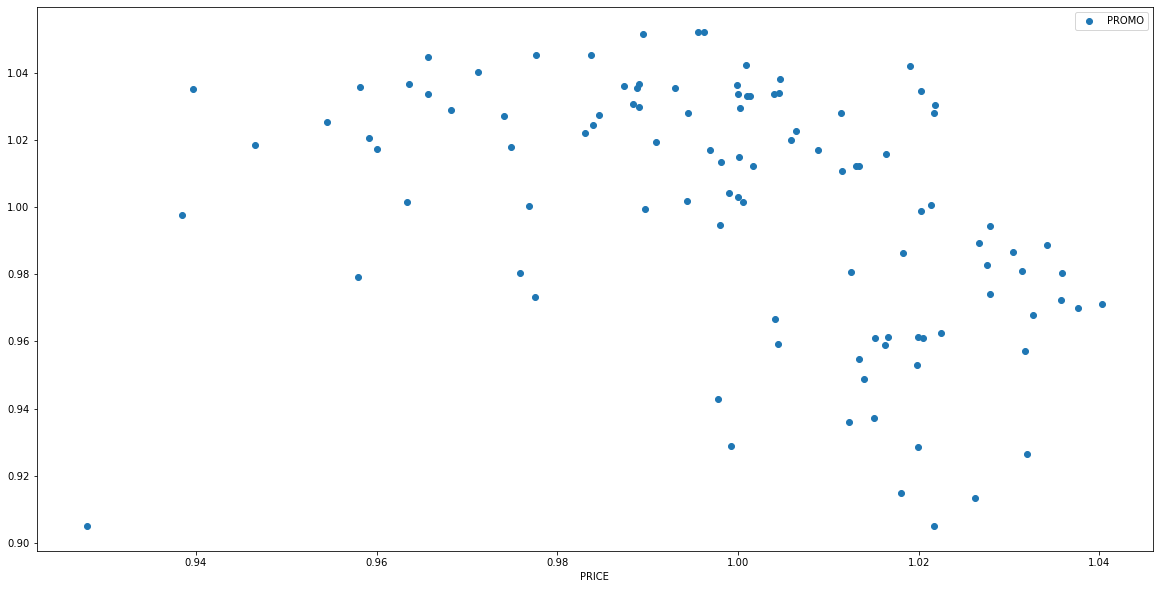

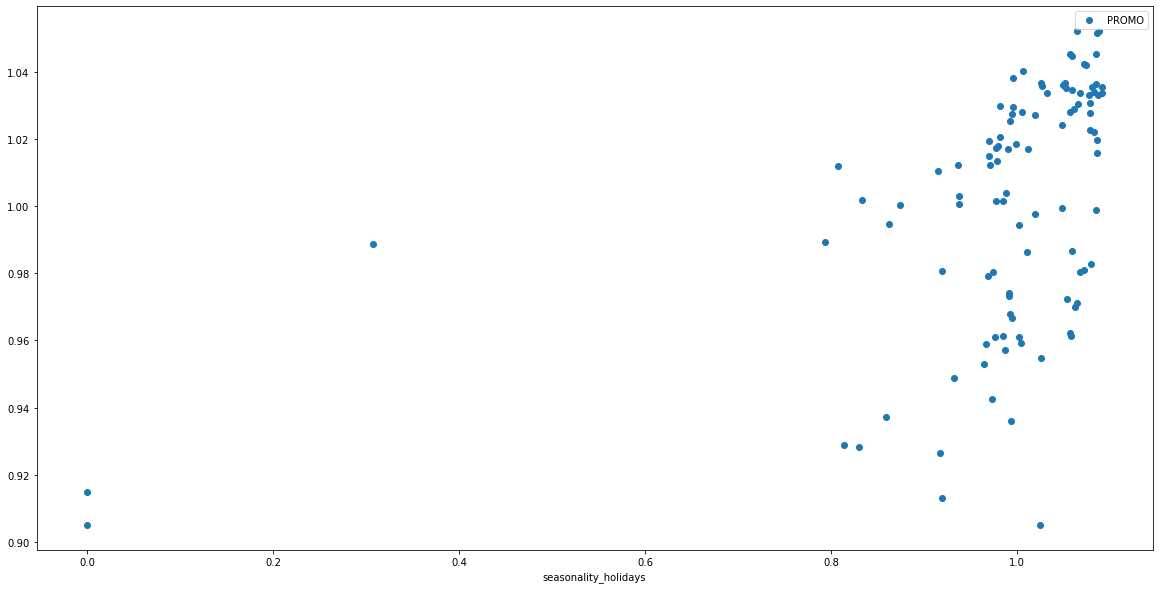

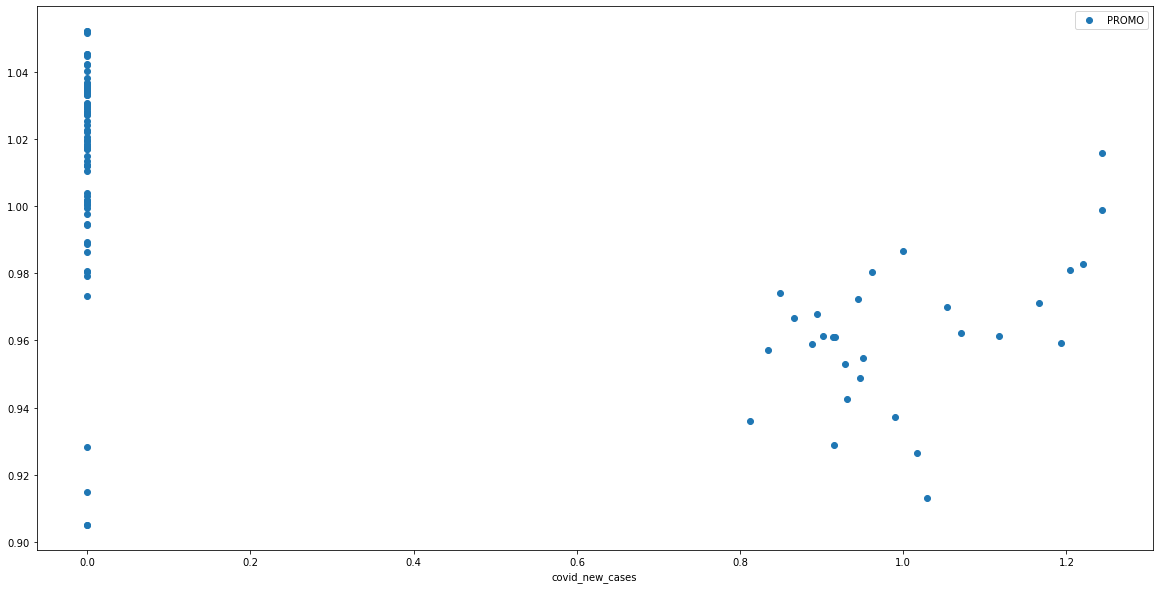

In [91]:
df_transformed.plot(x='PRICE', y='PROMO', style='o')
df_transformed.plot(x='seasonality_holidays', y='PROMO', style='o')
df_transformed.plot(x='covid_new_cases', y='PROMO', style='o')

popt, _ = curve_fit(hyperbolic_kernel, df_transformed['PRICE'],
                    df_transformed['PROMO'])
print(popt)

popt, _ = curve_fit(linear_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['PROMO'])
print(popt)

popt, _ = curve_fit(linear_kernel, df_transformed['covid_new_cases'],
                    df_transformed['PROMO'])
print(popt)


## Approach

By visualising parent against child, try to find the best match off the available functions above for mapping the relation. The coefficients for the function are calculated using curve fit function outlined below

quad [ 0.07595263 -0.03927311  0.96331186]
lin [-0.03549749  1.00989834]
hyper [-1.30813563  2.30830541]
linear [0.44485176 0.55514824]
linea [0.02767476 0.99042028]
hyp [0.34327166 0.65652336]
lin [0.67437645 0.32562355]
quad [-1.95870005  3.98682061 -1.02019368]
lin [0.07272798 0.92727202]


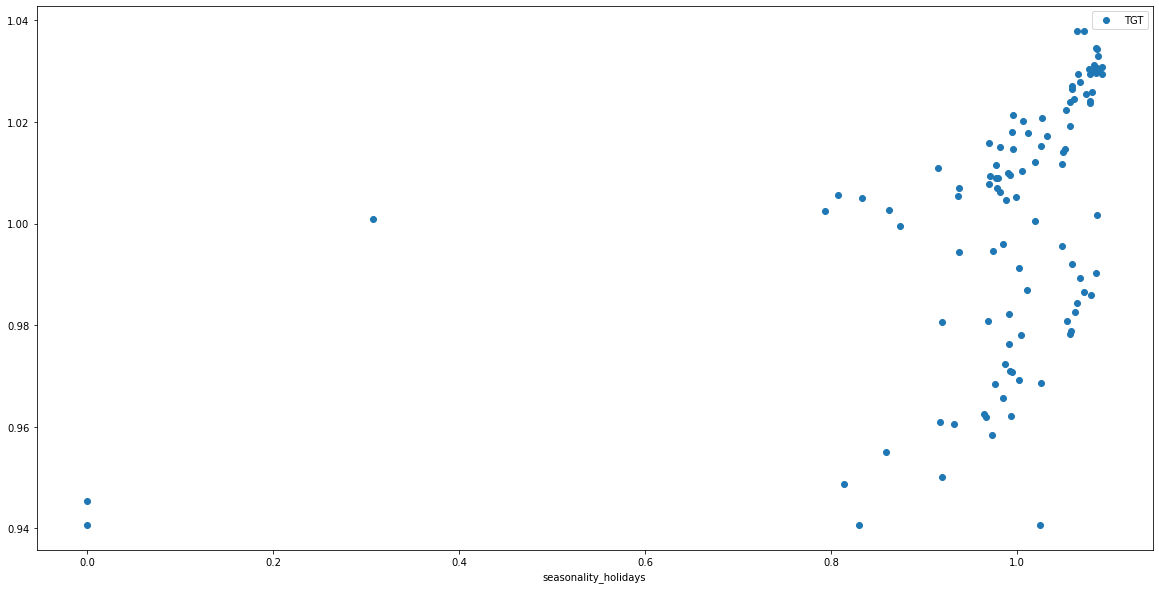

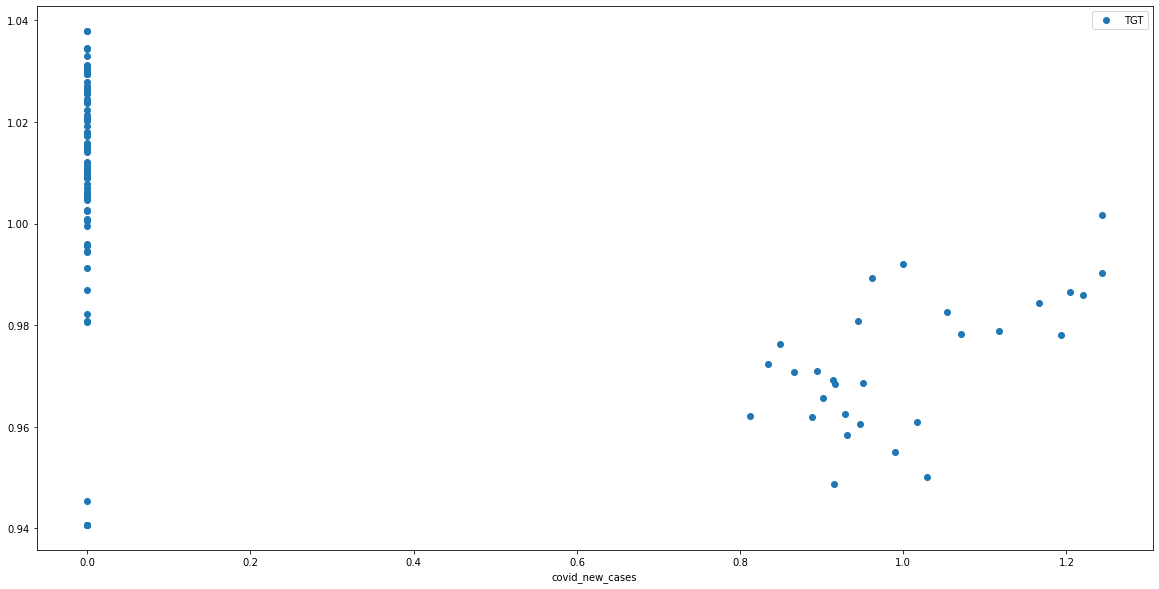

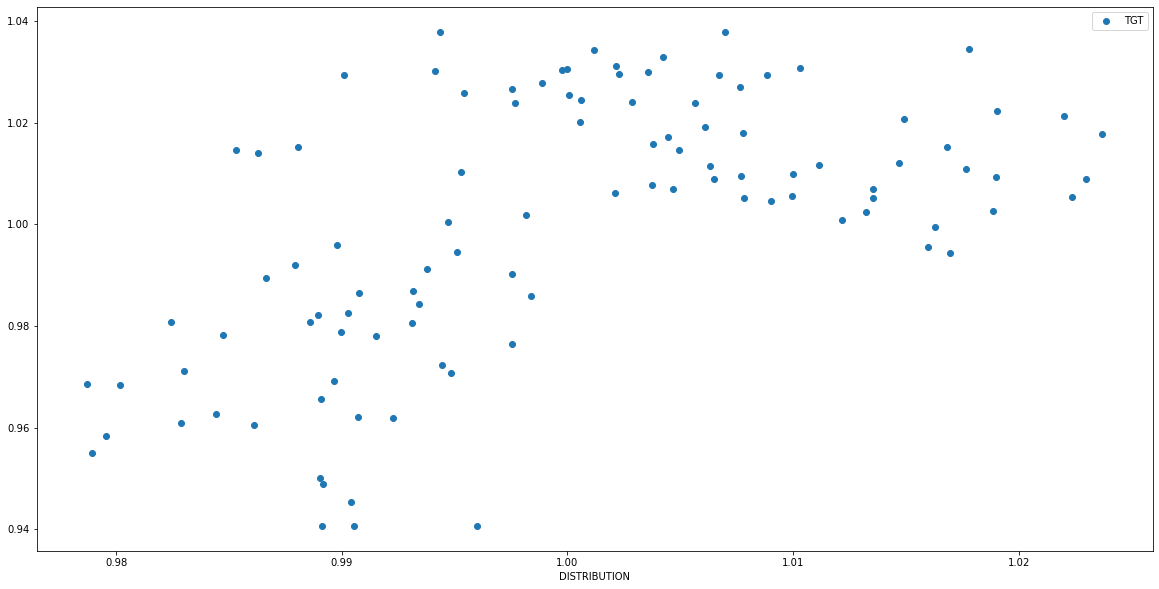

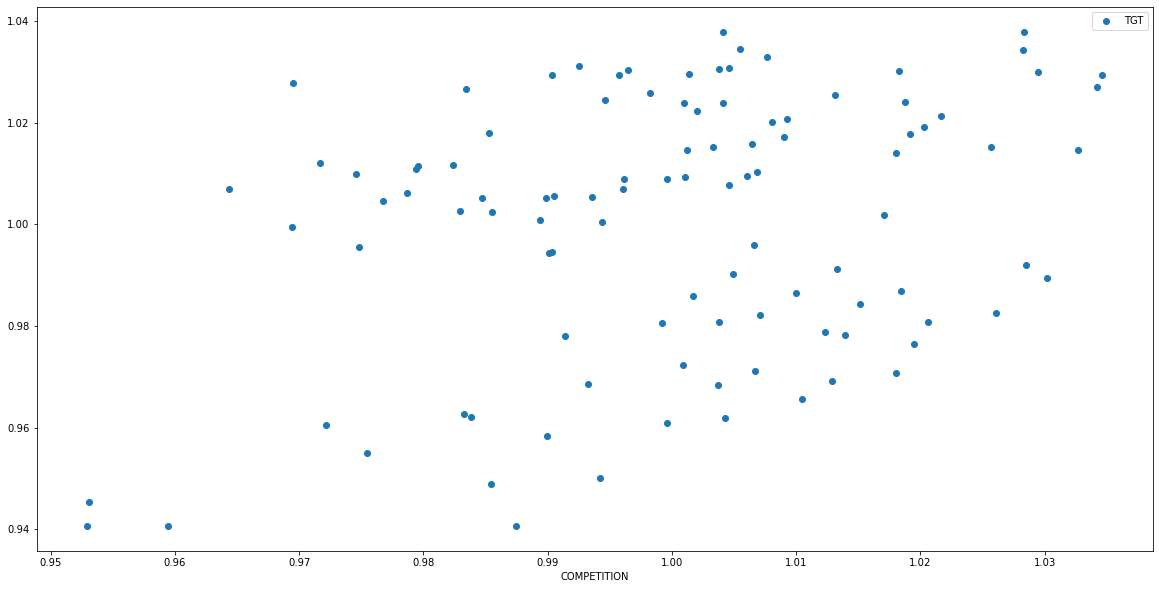

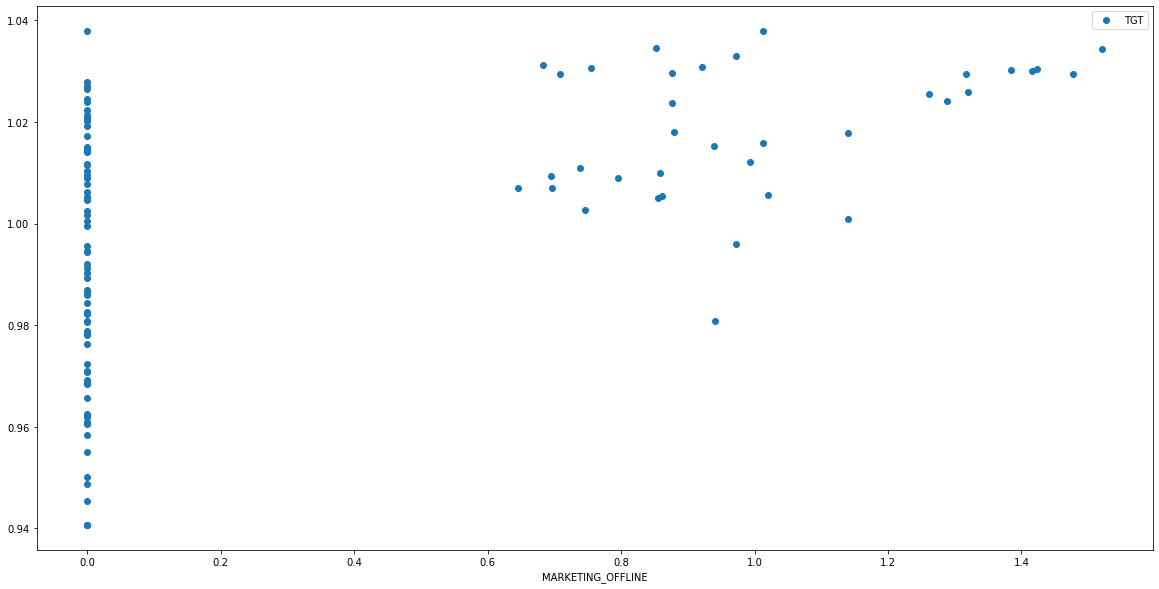

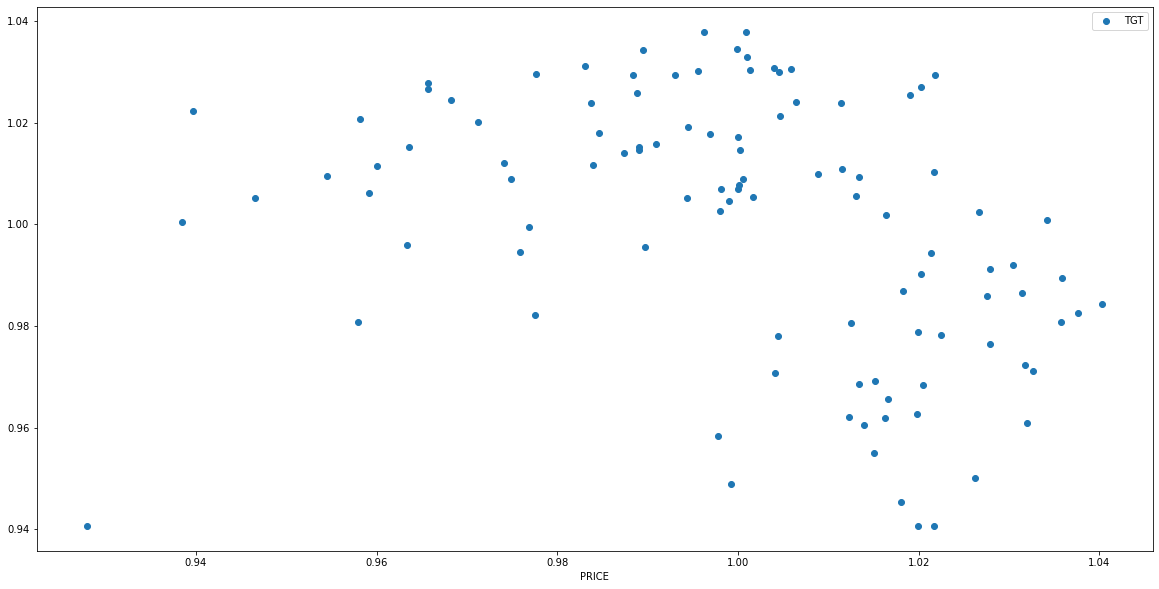

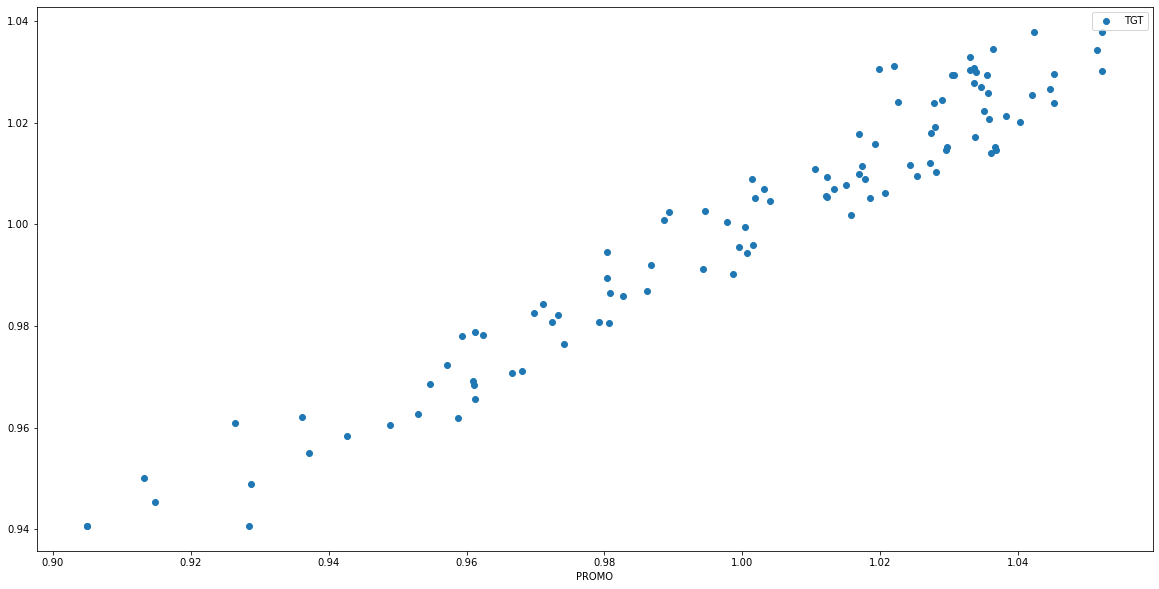

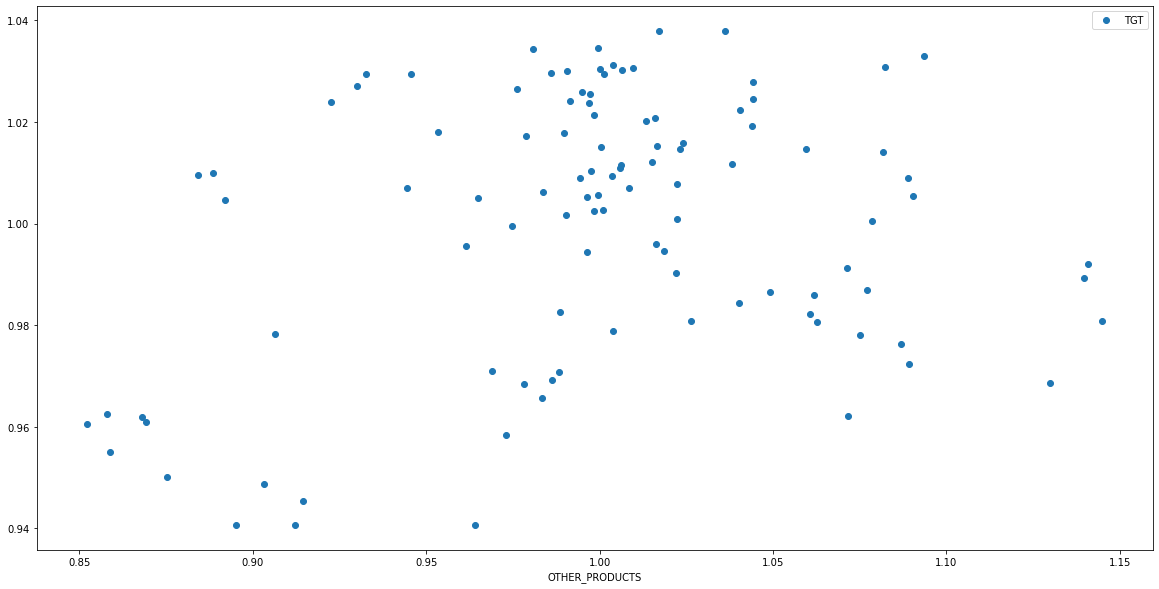

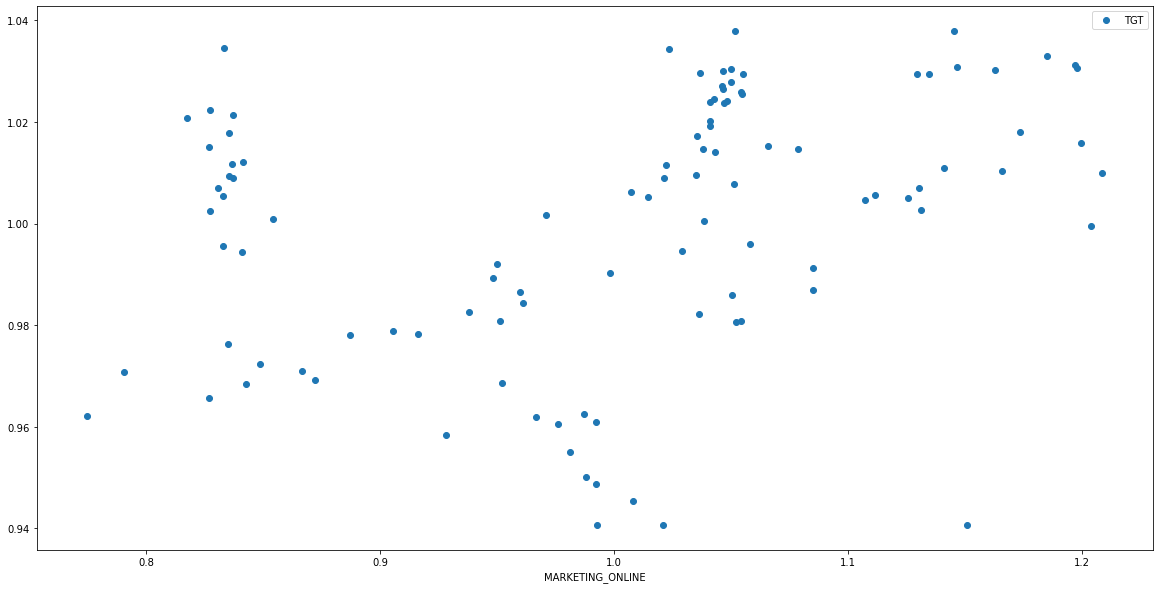

In [92]:
df_transformed.plot(x='seasonality_holidays', y='TGT', style='o')
df_transformed.plot(x='covid_new_cases', y='TGT', style='o')
df_transformed.plot(x='DISTRIBUTION', y='TGT', style='o')
df_transformed.plot(x='COMPETITION', y='TGT', style='o')
df_transformed.plot(x='MARKETING_OFFLINE', y='TGT', style='o')
df_transformed.plot(x='PRICE', y='TGT', style='o')
df_transformed.plot(x='PROMO', y='TGT', style='o')
df_transformed.plot(x='OTHER_PRODUCTS', y='TGT', style='o')
df_transformed.plot(x='MARKETING_ONLINE', y='TGT', style='o')


popt, _ = curve_fit(quadratic_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['COMPETITION'])
print("quad", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['covid_new_cases'],
                    df_transformed['TGT'])
print("lin", popt)

popt, _ = curve_fit(hyperbolic_kernel, df_transformed['DISTRIBUTION'],
                    df_transformed['TGT'])
print("hyper", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['COMPETITION'],
                    df_transformed['TGT'])
print("linear", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['MARKETING_OFFLINE'],
                    df_transformed['TGT'])
print("linea", popt)

popt, _ = curve_fit(hyperbolic_kernel, df_transformed['PRICE'],
                    df_transformed['TGT'])
print("hyp", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['PROMO'],
                    df_transformed['TGT'])
print("lin", popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['OTHER_PRODUCTS'],
                    df_transformed['TGT'])
print("quad", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['MARKETING_ONLINE'],
                    df_transformed['TGT'])
print("lin", popt)




quad [ 1.97134714 -3.76951051  2.79700788]
lin [0.05313779 0.94788409]
quad [ 0.01166104 -0.00584131  0.99832392]
linear [0.15744632 0.84255368]
linea [-0.00415735  1.00415735]
lin [-0.2119631  1.2119631]
lin [0.0041308  0.99857011]


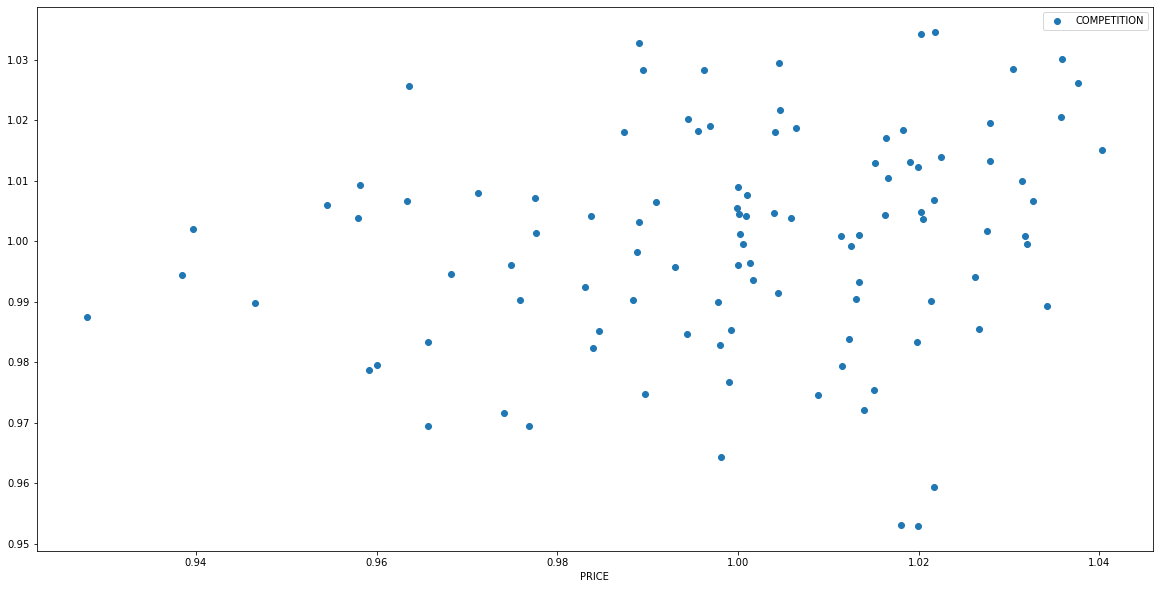

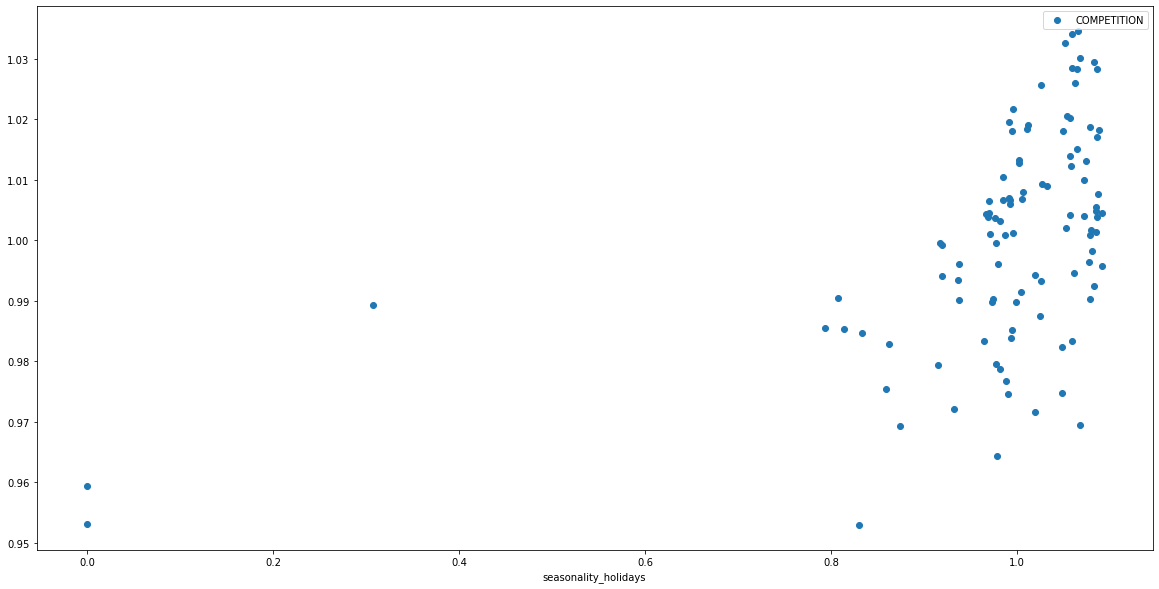

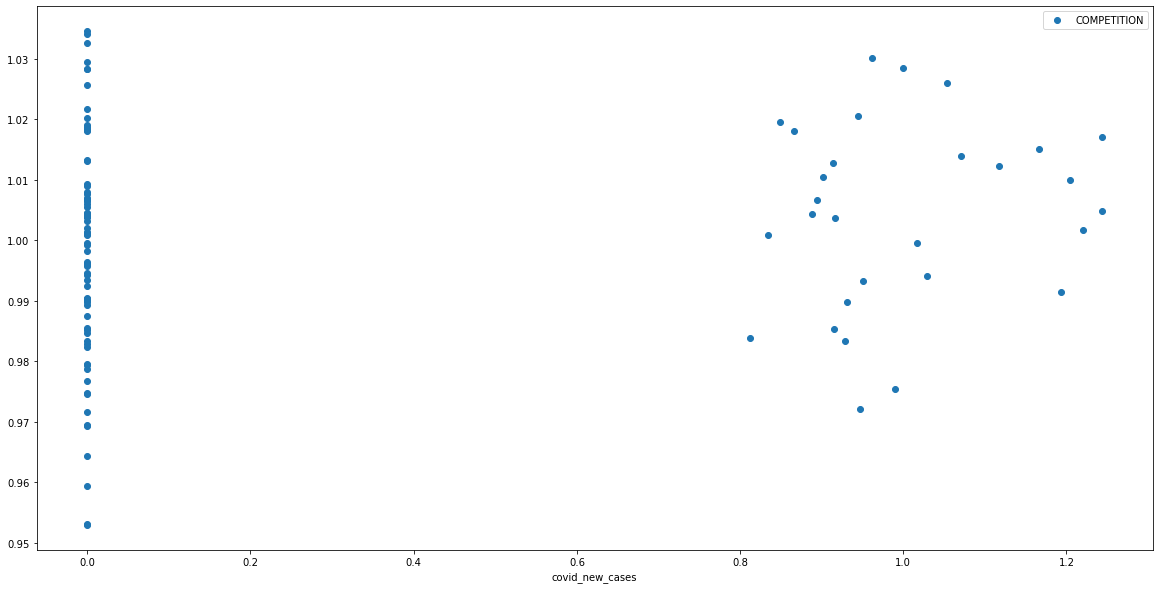

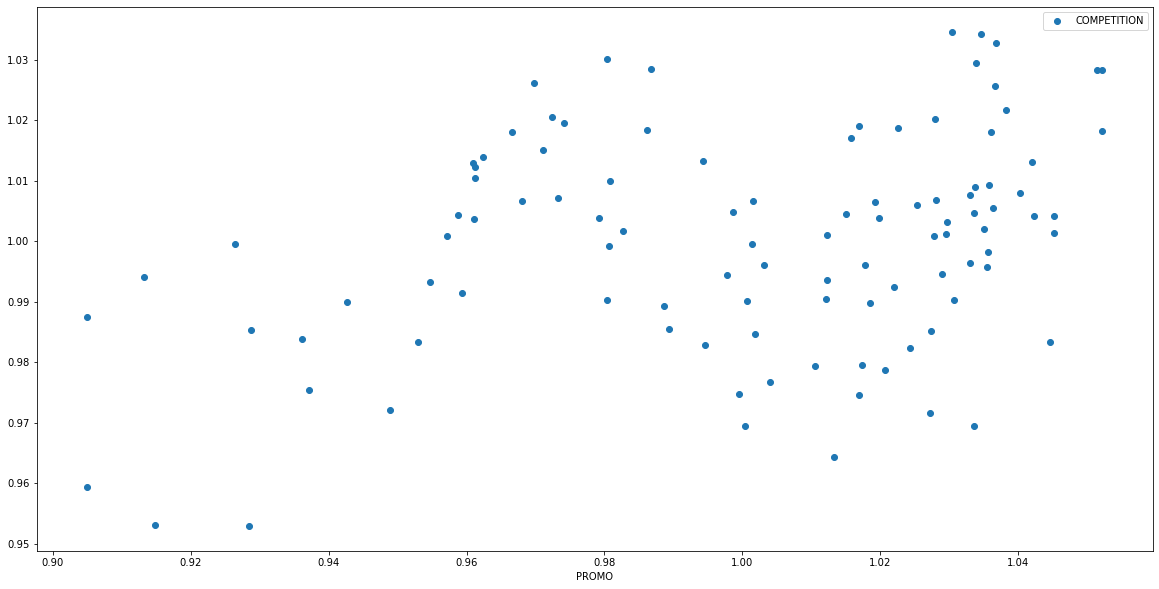

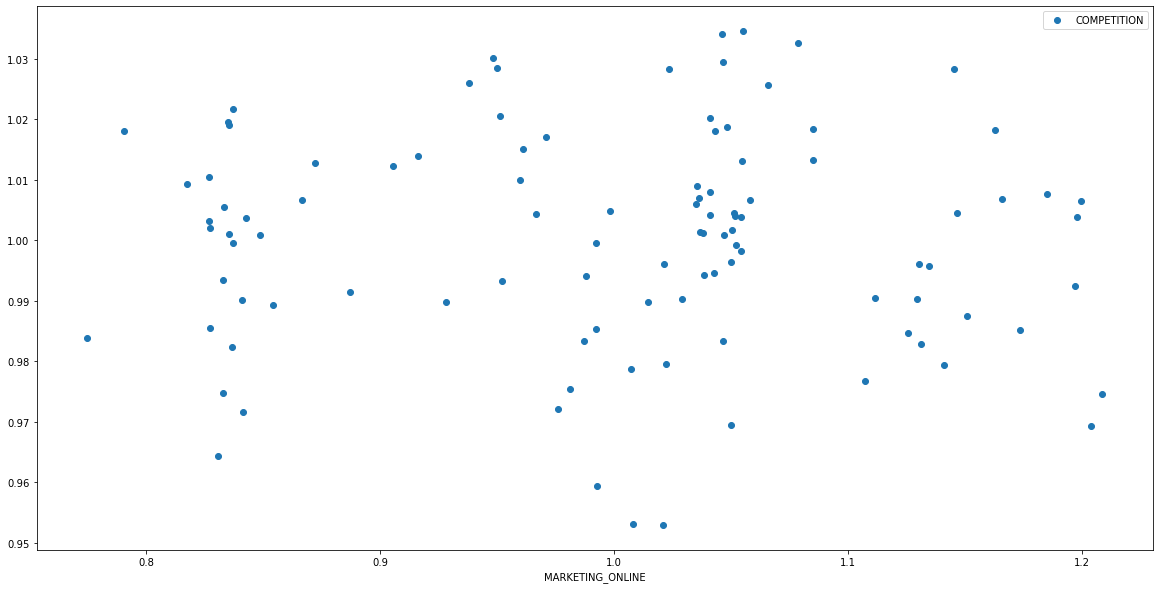

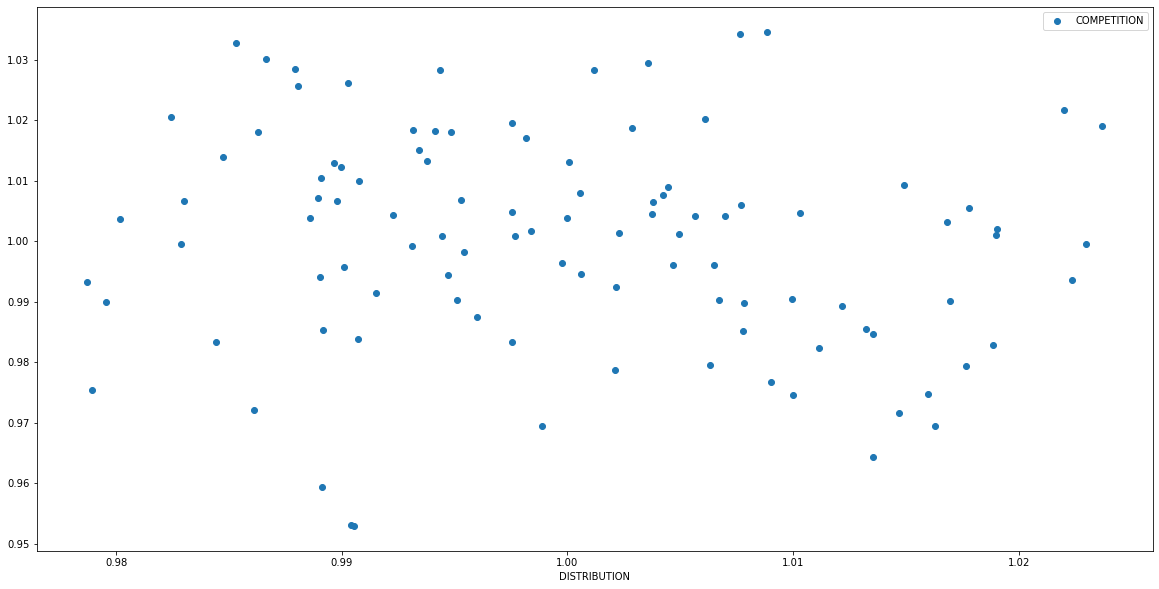

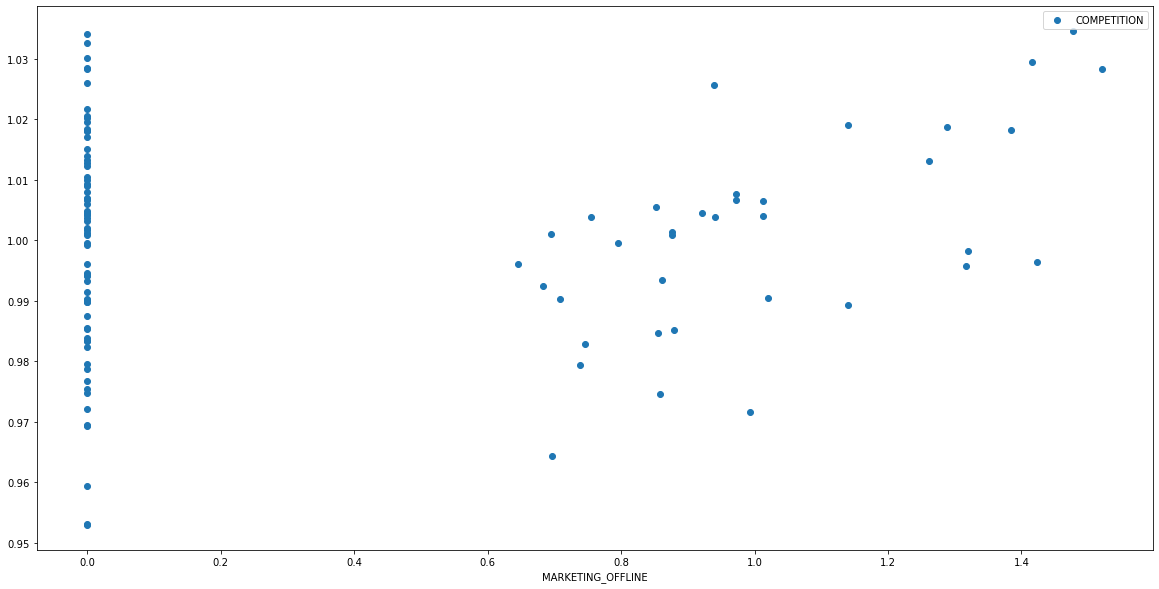

In [93]:
df_transformed.plot(x='PRICE', y='COMPETITION', style='o')
df_transformed.plot(x='seasonality_holidays', y='COMPETITION', style='o')
df_transformed.plot(x='covid_new_cases', y='COMPETITION', style='o')
df_transformed.plot(x='PROMO', y='COMPETITION', style='o')
df_transformed.plot(x='MARKETING_ONLINE', y='COMPETITION', style='o')
df_transformed.plot(x='DISTRIBUTION', y='COMPETITION', style='o')
df_transformed.plot(x='MARKETING_OFFLINE', y='COMPETITION', style='o')

popt, _ = curve_fit(quadratic_kernel, df_transformed['PRICE'],
                    df_transformed['COMPETITION'])
print("quad", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['COMPETITION'])
print("lin", popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['covid_new_cases'],
                    df_transformed['COMPETITION'])
print("quad", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['PROMO'],
                    df_transformed['COMPETITION'])
print("linear", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['MARKETING_ONLINE'],
                    df_transformed['COMPETITION'])
print("linea", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['DISTRIBUTION'],
                    df_transformed['COMPETITION'])
print("lin", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['MARKETING_OFFLINE'],
                    df_transformed['COMPETITION'])
print("lin", popt)


quad [  8.4978453  -16.88334604   9.38051977]
linear [0.10871856 0.89337218]
quad [ 0.08124062 -0.08772271  1.00143638]
quad [-15.35605327  30.6999659  -14.32299694]
quad [-0.02912978  0.03662144  0.99804162]
quad [ 0.52143817 -1.1009219   1.57280621]


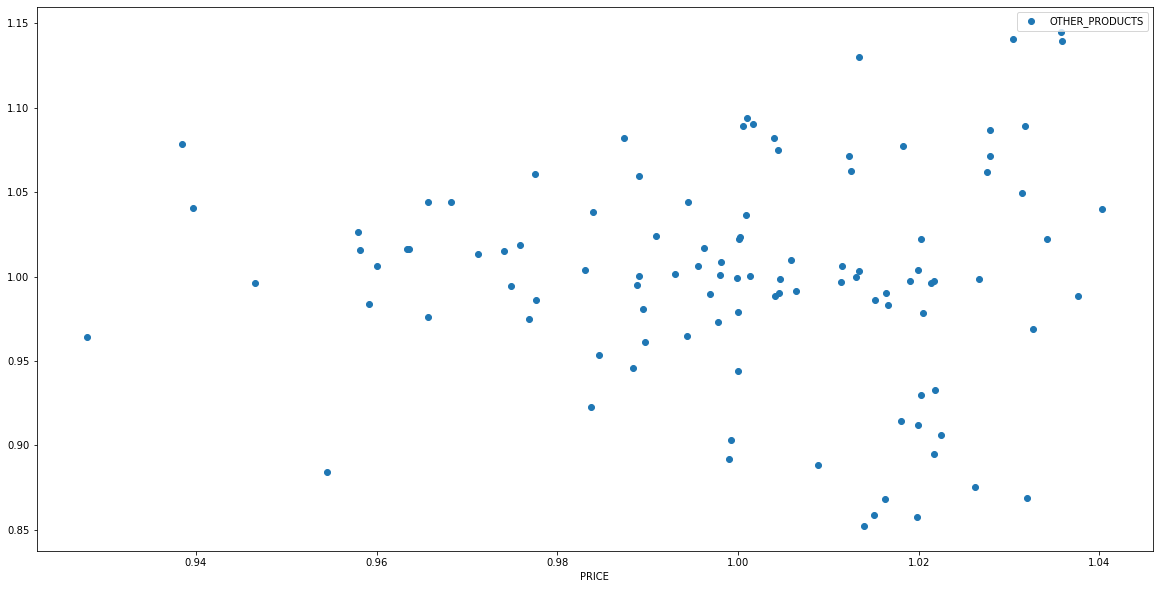

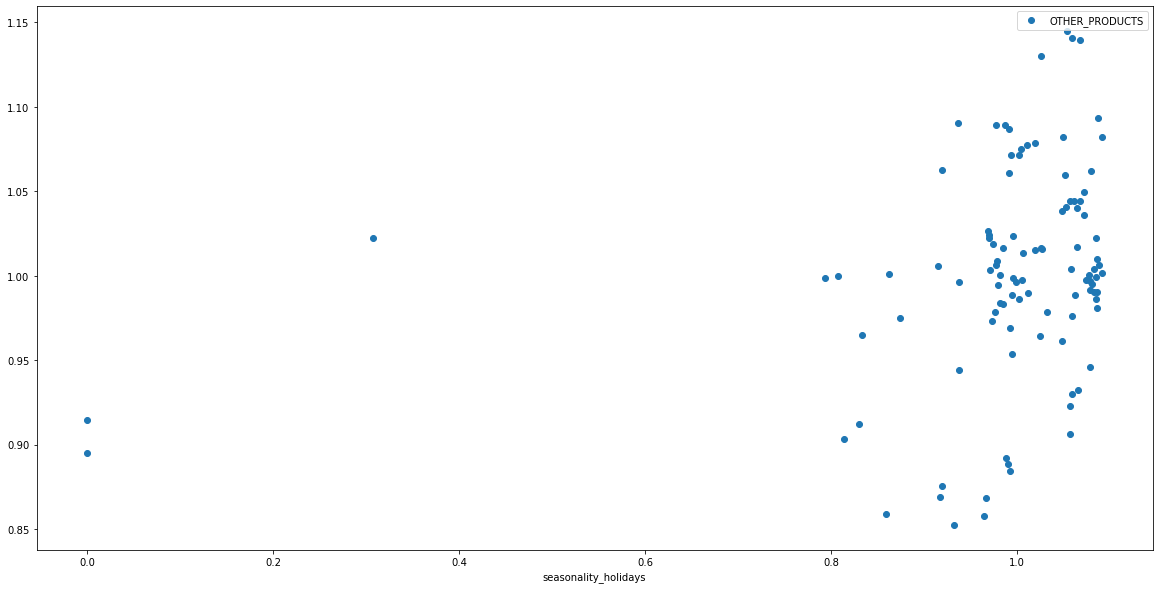

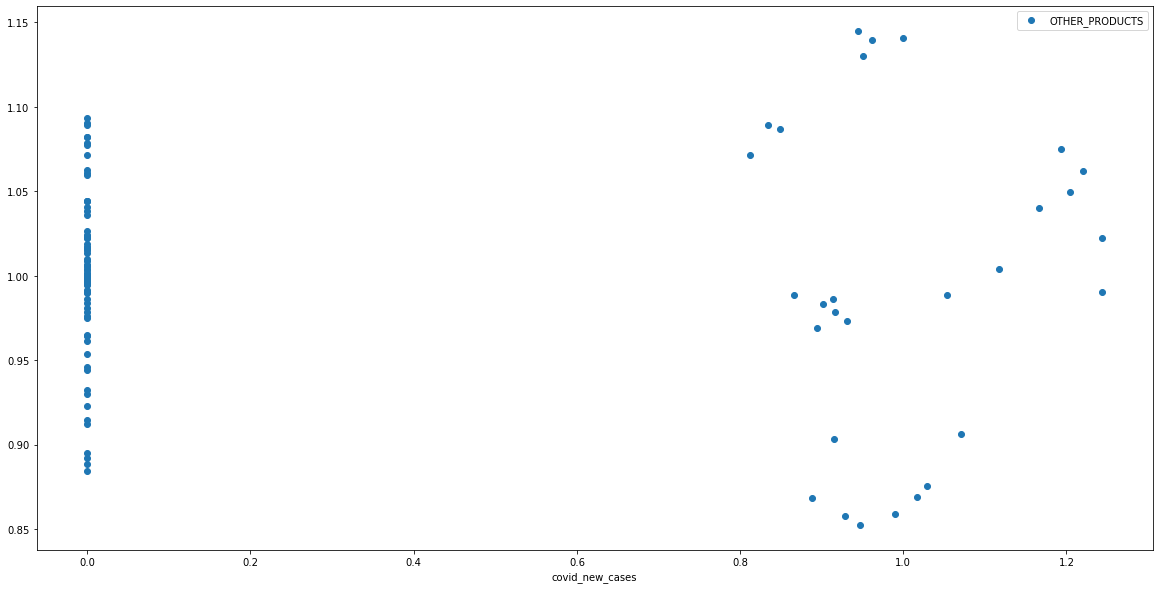

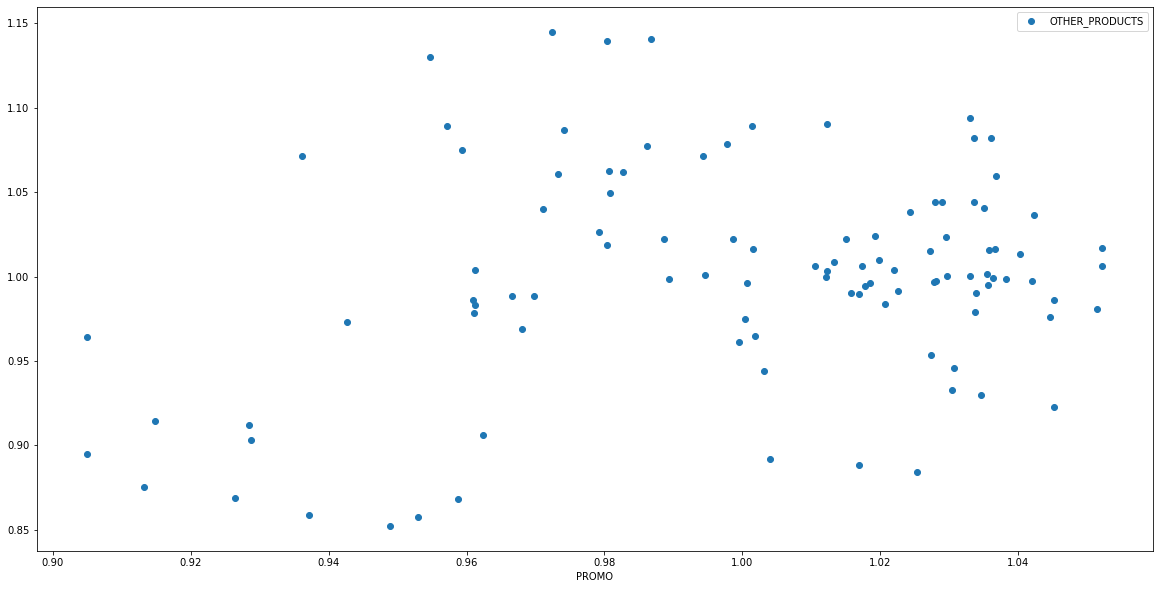

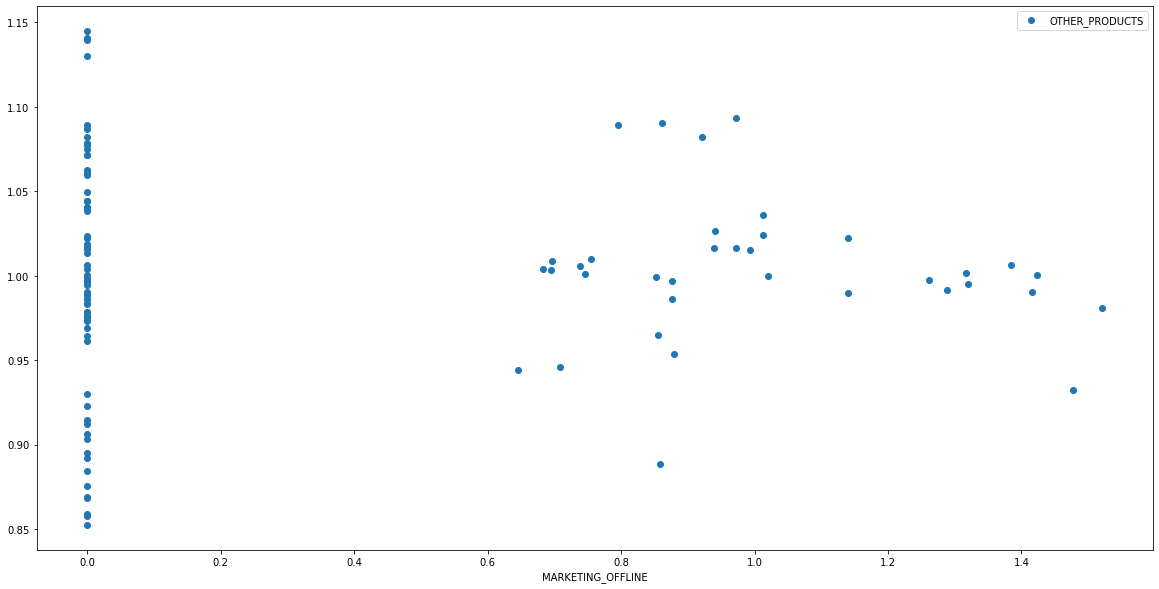

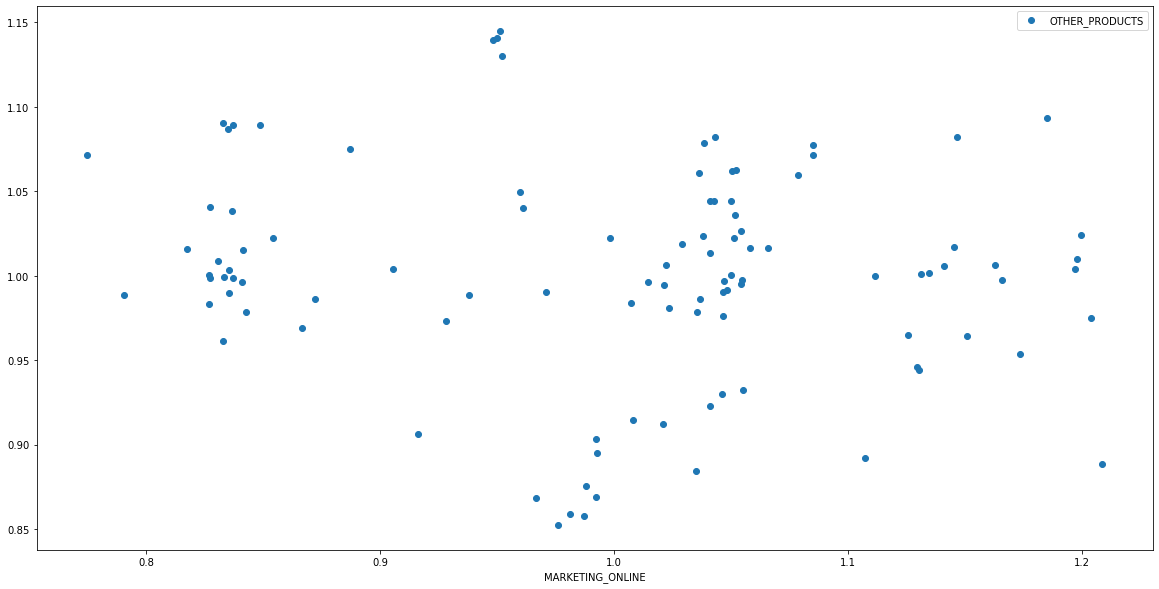

In [94]:
df_transformed.plot(x='PRICE', y='OTHER_PRODUCTS', style='o')
df_transformed.plot(x='seasonality_holidays', y='OTHER_PRODUCTS', style='o')
df_transformed.plot(x='covid_new_cases', y='OTHER_PRODUCTS', style='o')
df_transformed.plot(x='PROMO', y='OTHER_PRODUCTS', style='o')
df_transformed.plot(x='MARKETING_OFFLINE', y='OTHER_PRODUCTS', style='o')
df_transformed.plot(x='MARKETING_ONLINE', y='OTHER_PRODUCTS', style='o')

popt, _ = curve_fit(quadratic_kernel, df_transformed['PRICE'],
                    df_transformed['OTHER_PRODUCTS'])
print("quad", popt)

popt, _ = curve_fit(linear_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['OTHER_PRODUCTS'])
print("linear", popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['covid_new_cases'],
                    df_transformed['OTHER_PRODUCTS'])
print("quad", popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['PROMO'],
                    df_transformed['OTHER_PRODUCTS'])
print("quad", popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['MARKETING_OFFLINE'],
                    df_transformed['OTHER_PRODUCTS'])
print("quad", popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['MARKETING_ONLINE'],
                    df_transformed['OTHER_PRODUCTS'])
print("quad", popt)

[ 1.17550254 -1.13962556  0.2999165 ]
[ 0.44573827 -0.93291918  0.47996613]
[ 33.49822769 -59.89874854  26.70104848]
[-230.79373413  456.3341331  -225.05896664]


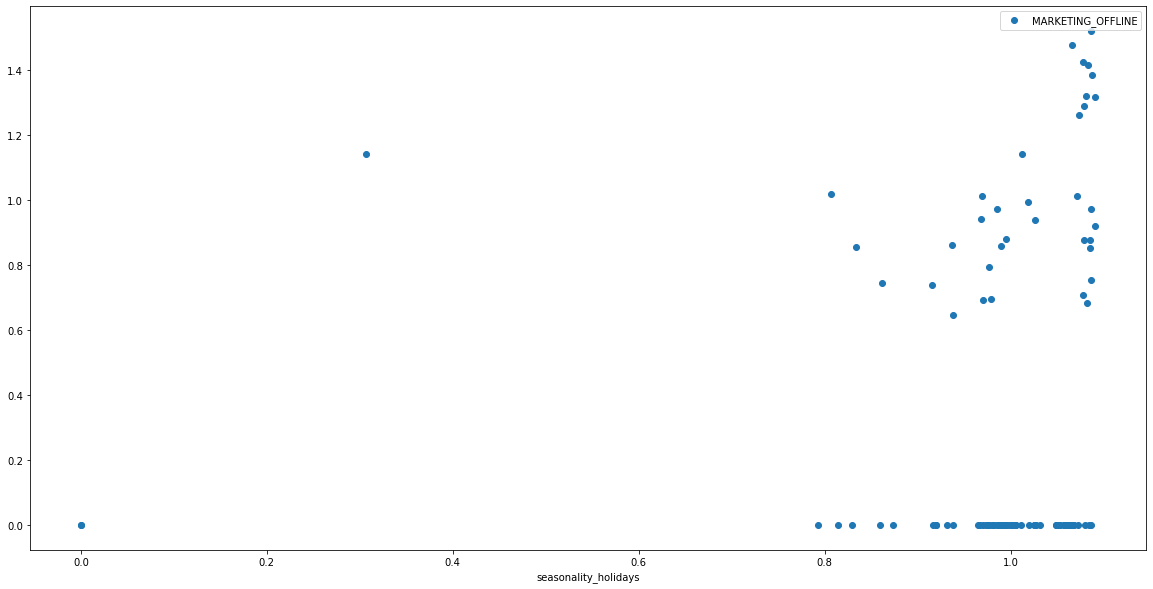

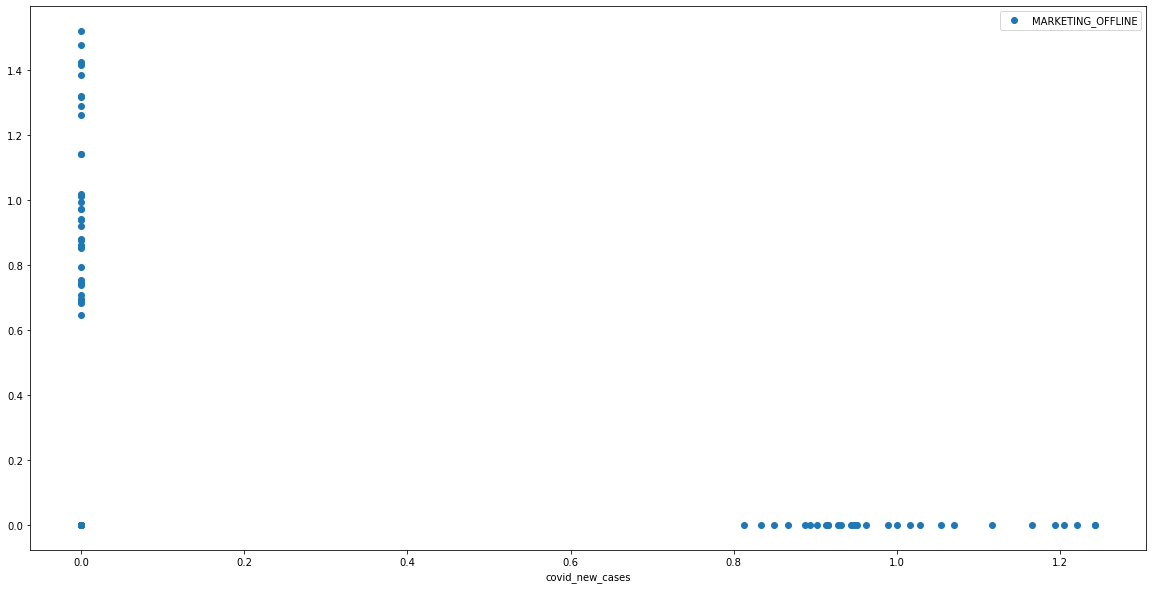

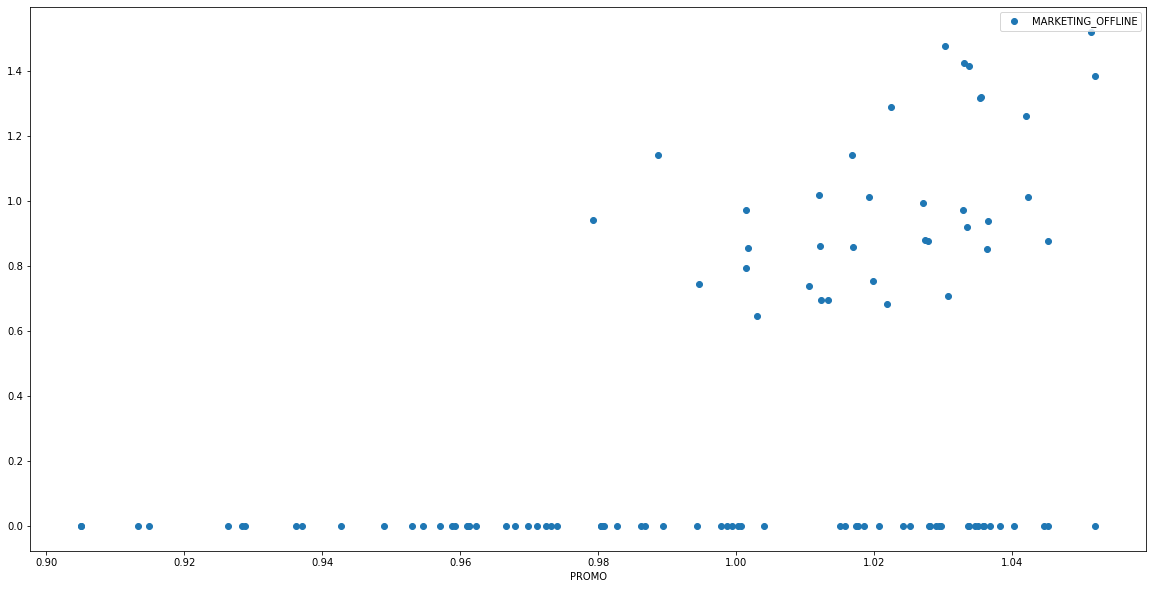

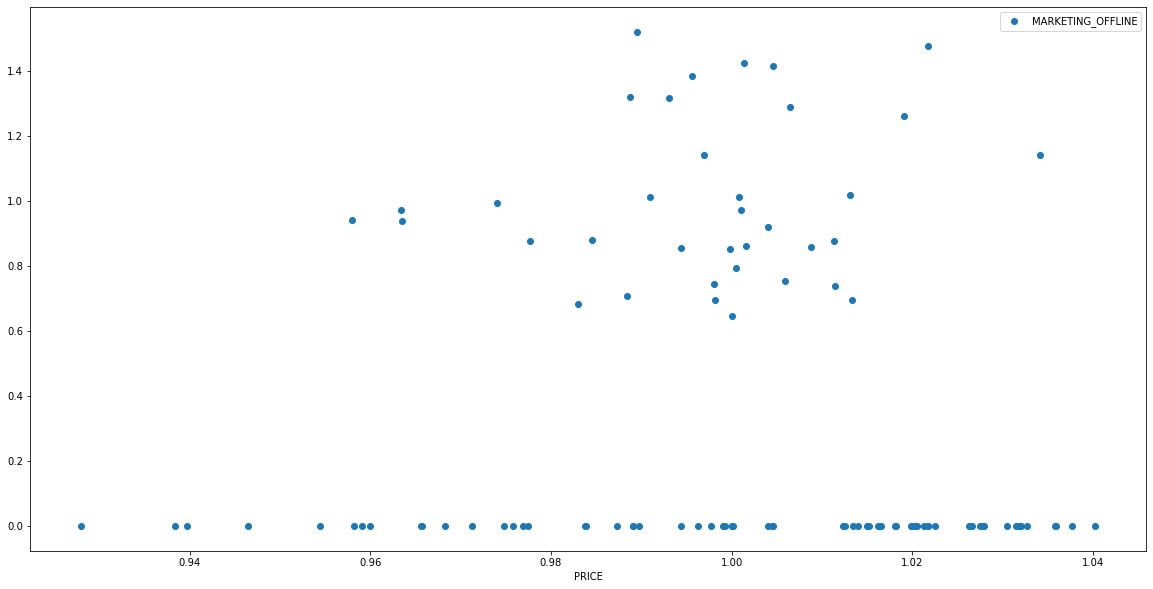

In [95]:
df_transformed.plot(x='seasonality_holidays', y='MARKETING_OFFLINE', style='o')
df_transformed.plot(x='covid_new_cases', y='MARKETING_OFFLINE', style='o')
df_transformed.plot(x='PROMO', y='MARKETING_OFFLINE', style='o')
df_transformed.plot(x='PRICE', y='MARKETING_OFFLINE', style='o')
popt, _ = curve_fit(quadratic_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['MARKETING_OFFLINE'])
print(popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['covid_new_cases'],
                    df_transformed['MARKETING_OFFLINE'])
print(popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['PROMO'],
                    df_transformed['MARKETING_OFFLINE'])
print(popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['PRICE'],
                    df_transformed['MARKETING_OFFLINE'])
print(popt)


[0.06693878 0.97682888]
[ 0.35067149 -0.45833742  1.02842028]
[0.05570373 0.94536749]
[-25.35644829  49.27263286 -22.90132202]


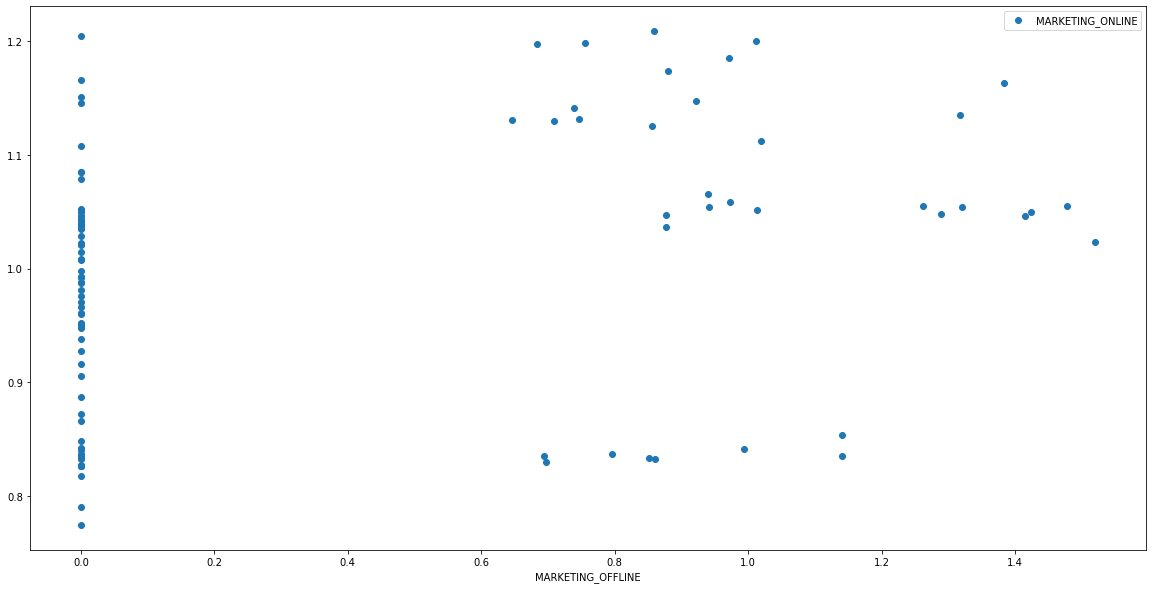

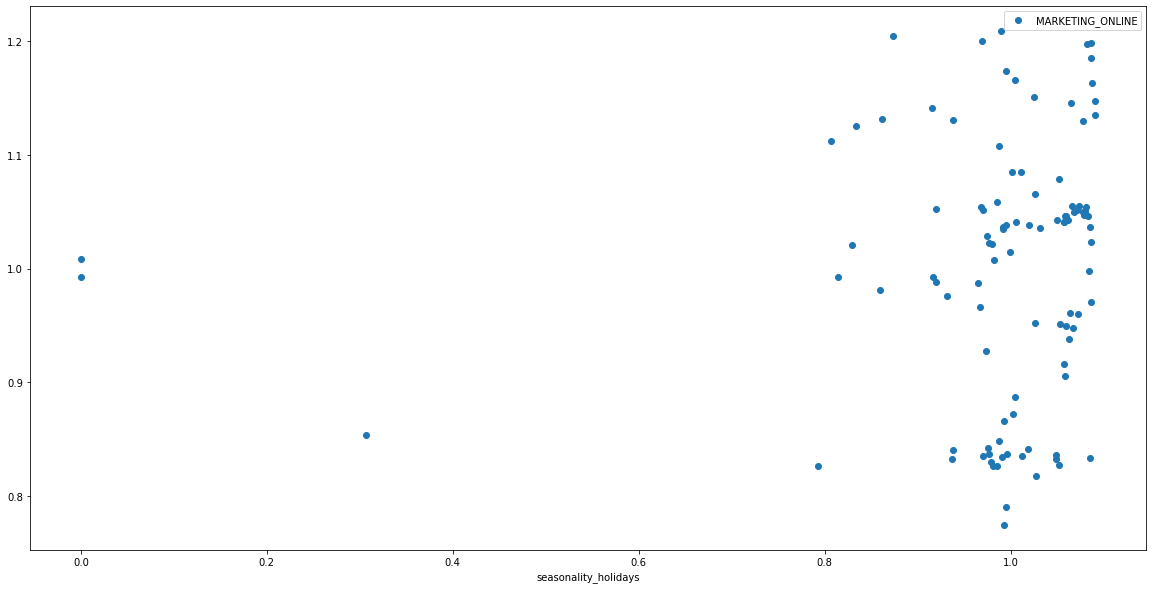

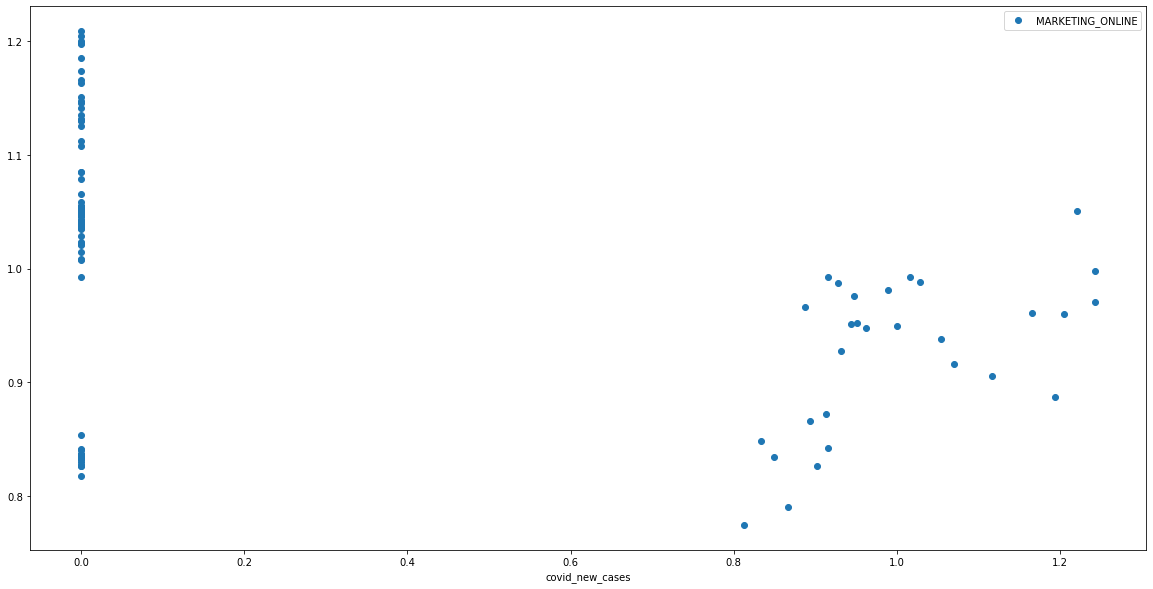

In [96]:
df_transformed.plot(x='MARKETING_OFFLINE', y='MARKETING_ONLINE', style='o')
df_transformed.plot(x='seasonality_holidays', y='MARKETING_ONLINE', style='o')
df_transformed.plot(x='covid_new_cases', y='MARKETING_ONLINE', style='o')

popt, _ = curve_fit(linear_kernel, df_transformed['MARKETING_OFFLINE'],
                    df_transformed['MARKETING_ONLINE'])
print(popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['covid_new_cases'],
                    df_transformed['MARKETING_ONLINE'])
print(popt)

popt, _ = curve_fit(linear_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['MARKETING_ONLINE'])
print(popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['PRICE'],
                    df_transformed['MARKETING_ONLINE'])
print(popt)

[0.00188362 0.9981526 ]
[-0.01496422  1.00417272]
[ 0.1292559  -0.18453985  1.01482524]


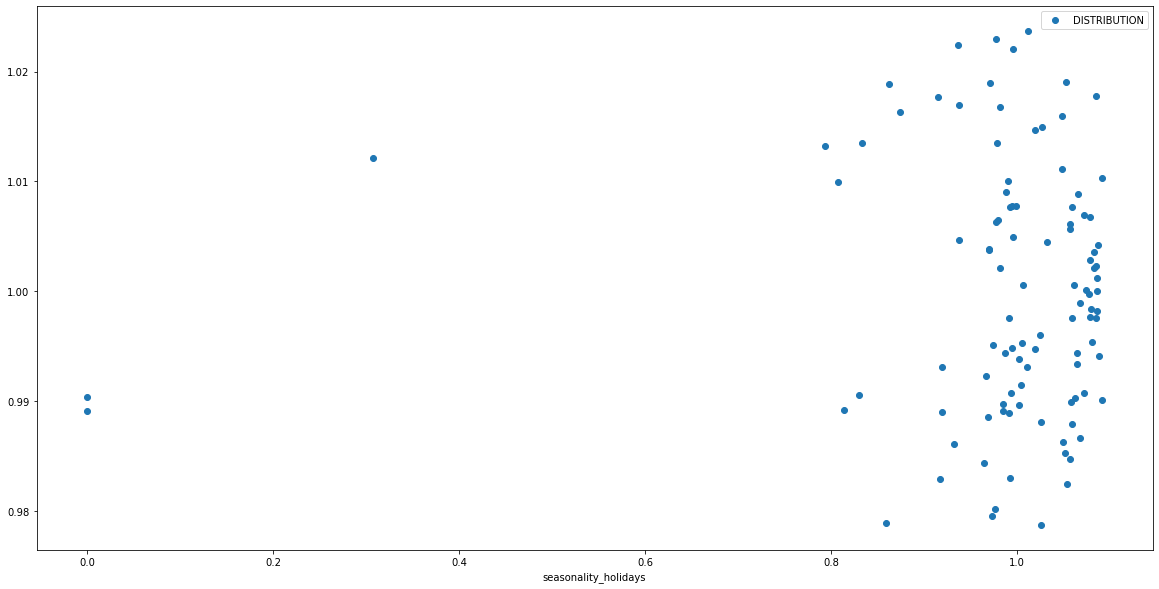

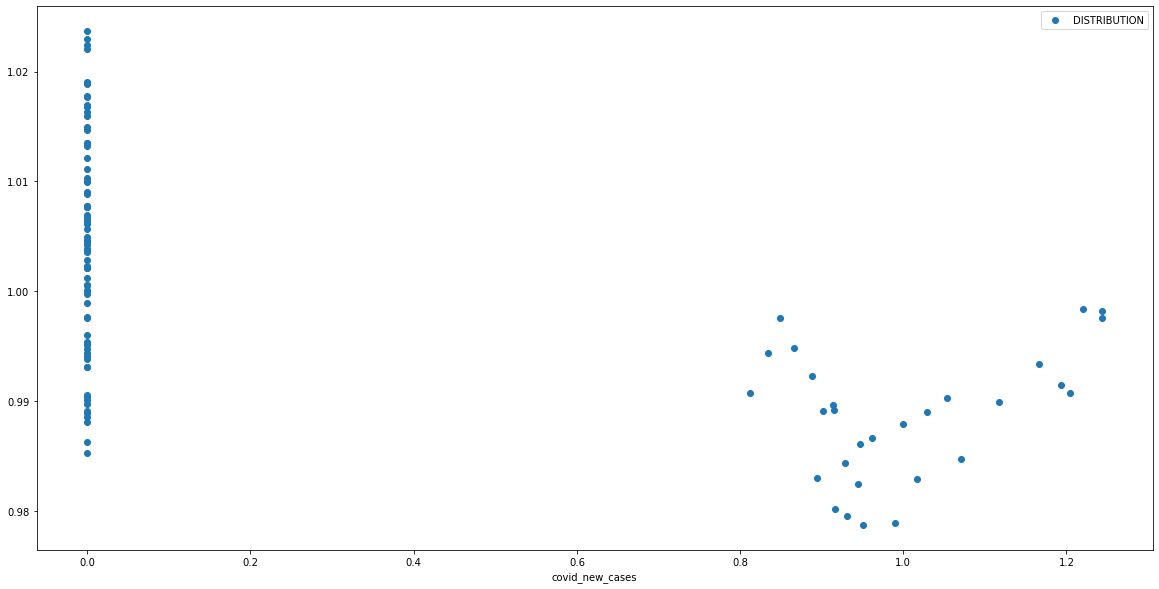

In [97]:
df_transformed.plot(x='seasonality_holidays', y='DISTRIBUTION', style='o')
df_transformed.plot(x='covid_new_cases', y='DISTRIBUTION', style='o')

popt, _ = curve_fit(linear_kernel, df_transformed['seasonality_holidays'],
                    df_transformed['DISTRIBUTION'])
print(popt)

popt, _ = curve_fit(linear_kernel, df_transformed['covid_new_cases'],
                    df_transformed['DISTRIBUTION'])
print(popt)

popt, _ = curve_fit(quadratic_kernel, df_transformed['covid_new_cases'],
                    df_transformed['PROMO'])
print(popt)

## Factoring the non-linear transformation to pass hierachy between parents and children better

The coefficients and kernels surmised above are applied successively to the child mean equation for distribution. Subsequently the same trace and post predictive check process is carried out to get samples

In [98]:

%%time
def logistic(l):
    return 1 / (1 +tt.exp(-l))
with pm.Model() as py_stan_dag2:
    
    ################################ Defining Mean & Sigma ################################
    len_df = len(data_dict['tgt'])
    seasonality_holidays_mean = mean_dict['seasonality_holidays_mean']
    covid_new_cases_mean = mean_dict['covid_new_cases_mean']
    seasonality_holidays_sigma = sigma_dict['seasonality_holidays_sigma']
    covid_new_cases_sigma = sigma_dict['covid_new_cases_sigma']
    price_mean = mean_dict['price_mean']
    price_sigma = sigma_dict['price_sigma']
    marketing_offline_sigma = sigma_dict['marketing_offline_sigma']
    marketing_offline_mean = mean_dict['marketing_offline_mean']
    promo_sigma = sigma_dict['promo_sigma']
    promo_mean = mean_dict['promo_mean']
    distribution_sigma = sigma_dict['distribution_sigma']
    distribution_mean = mean_dict['distribution_mean']
    competition_sigma = sigma_dict['competition_sigma']
    competition_mean = mean_dict['competition_mean']
    other_products_sigma = sigma_dict['other_products_sigma']
    other_products_mean = mean_dict['other_products_mean']
    marketing_online_sigma = sigma_dict['marketing_online_sigma']
    marketing_online_mean = mean_dict['marketing_online_mean']
    tgt_mean = mean_dict['tgt_mean']
    
    tgt_sigma = pm.HalfNormal('tgt_sigma', 1)
    ################################ Defining Beta's ################################
    BoundedNormal =pm.Bound(pm.Laplace, upper=0)
    beta_price_to_promo=BoundedNormal('beta_price_to_promo',0,1)
    beta_seasonality_holidays_to_promo = pm.Laplace('beta_seasonality_holidays_to_promo',0, 1)
    beta_covid_new_cases_to_promo = pm.Laplace('beta_covid_new_cases_to_promo',0, 1)
    beta_offline_to_online = pm.HalfNormal('beta_offline_to_online',1)
    beta_seasonality_holidays_to_online=BoundedNormal('beta_seasonality_holidays_to_online',0,1)
    beta_covid_new_cases_to_online=BoundedNormal('beta_covid_new_cases_to_online',0,1)    
    beta_seasonality_holidays_to_distribution = pm.Laplace('beta_seasonality_holidays_to_distribution',0, 1)
    beta_covid_new_cases_to_distribution = pm.Laplace('beta_covid_new_cases_to_distribution',0, 1)
    beta_price_to_competition = pm.Laplace('beta_price_to_competition',0, 1)
    beta_seasonality_holidays_to_competition = pm.Laplace('beta_seasonality_holidays_to_competition',0, 1)
    beta_covid_new_cases_to_competition = pm.Laplace('beta_covid_new_cases_to_competition',0, 1)
    beta_promo_to_competition=BoundedNormal('beta_promo_to_competition',0,1)
    beta_online_to_competition=BoundedNormal('beta_online_to_competition',0,1)
    beta_distribution_to_competition=BoundedNormal('beta_distribution_to_competition',0,1)
    beta_offline_to_competition = pm.Laplace('beta_offline_to_competition',0, 1)
    beta_price_to_otherprod = pm.Laplace('beta_price_to_otherprod',0, 1)
    beta_seasonality_holidays_to_otherprod = pm.Laplace('beta_seasonality_holidays_to_otherprod',0, 1)
    beta_covid_new_cases_to_otherprod = pm.Laplace('beta_covid_new_cases_to_otherprod',0, 1)
    beta_promo_to_otherprod = pm.Laplace('beta_promo_to_otherprod',0, 1)
    beta_online_to_otherprod = pm.Laplace('beta_online_to_otherprod',0, 1)
    beta_offline_to_otherprod = pm.Laplace('beta_offline_to_otherprod',0, 1)
    beta_seasonality_holidays_to_offline = pm.Laplace('beta_seasonality_holidays_to_offline',0, 1)
    beta_covid_new_cases_to_offline = pm.Laplace('beta_covid_new_cases_to_offline',0, 1)
    beta_promo_to_offline = pm.Laplace('beta_promo_to_offline',0, 1)
    beta_price_to_offline = pm.Laplace('beta_price_to_offline',0, 1) 
    beta_seasonality_holidays_to_tgt=BoundedNormal('beta_seasonality_holidays_to_tgt',0,1)
    beta_covid_new_cases_to_tgt=BoundedNormal('beta_covid_new_cases_to_tgt',0,1)
    beta_distribution_to_tgt = pm.HalfNormal('beta_distribution_to_tgt', 1)
    beta_competition_to_tgt=BoundedNormal('beta_competition_to_tgt',0,1)
    beta_online_to_tgt = pm.HalfNormal('beta_online_to_tgt', 1)
    beta_price_to_tgt=BoundedNormal('beta_price_to_tgt',0,1)
    beta_promo_to_tgt = pm.HalfNormal('beta_promo_to_tgt', 1)
    beta_otherprod_to_tgt = pm.HalfNormal('beta_otherprod_to_tgt', 1)
    beta_offline_to_tgt = pm.HalfNormal('beta_offline_to_tgt', 1)

    seasonality_holidays_alpha = pm.Normal('seasonality_holidays_alpha',0, 1)
    covid_new_cases_alpha = pm.Normal('covid_new_cases_alpha',0, 1)
    promo_mu = pm.Normal('promo_mu',promo_mean, sigma=promo_sigma, shape=len_df)
    price_mu = pm.Normal('price_mu',price_mean, sigma=price_sigma, shape=len_df)
    marketing_online_mu = pm.Normal('marketing_online_mu', marketing_online_mean, sigma=2*marketing_online_sigma, shape=len_df)
    distribution_mu = pm.Normal('distribution_mu',distribution_mean, sigma=distribution_sigma, shape=len_df)
    marketing_offline_mu = pm.Normal('marketing_offline_mu',marketing_offline_mean, sigma=marketing_offline_sigma, shape=len_df)
    other_products_mu = pm.Normal('other_products_mu',other_products_mean, sigma=other_products_sigma, shape=len_df)
    competition_mu = pm.Normal('competition_mu',competition_mean, sigma=competition_sigma, shape=len_df)
    tgt_mu = pm.Normal('tgt_mu',tgt_mean, sigma=sigma_dict['tgt_sigma'], shape=len_df)
    
    beta_online = pm.Deterministic(f'beta_online_spend', tt.switch(tt.eq(data2['MARKETING_ONLINE_SP'].values, 0), 0, 1))
    beta_offline = pm.Deterministic(f'beta_offline_spend', tt.switch(tt.eq(data2['MARKETING_OFFLINE_SP'].values, 0), 0, 1))
    ################################### Defining Adstock media ################################ 
    #Offline Adstock
    alpha_offline = pm.Beta('alpha_offline',           6, 6)  # retain rate in adstock
    theta_offline = pm.Uniform('theta_offline',        0 , 1.5) # delay in adstock
    #Online Adstock
    alpha_online = pm.Beta('alpha_online',           3, 3)  # retain rate in adstock 
    theta_online = pm.Uniform('theta_online',        0 , 0.5) # delay in adstock

    ################################### parent nodes ################################ 
    seasonality_holidays_mu = pm.Normal('seasonality_holidays_mu',seasonality_holidays_mean, 
                                        sigma=seasonality_holidays_sigma, shape=len_df, observed = data_dict['seasonality_holidays'])
    covid_new_cases_mu = pm.Normal('covid_new_cases_mu',covid_new_cases_mean, sigma=covid_new_cases_sigma,observed = data_dict['covid_new_cases'],  shape=len_df)

    seasonality_holidays = pm.Normal('seasonality_holidays',
                                         mu = seasonality_holidays_alpha + seasonality_holidays_mu, 
                                         sigma = seasonality_holidays_sigma, 
                                         shape=len_df, 
                                         observed=data_dict['seasonality_holidays'])
    
    covid_new_cases = pm.Normal('covid_new_cases',
                                   mu = covid_new_cases_alpha + covid_new_cases_mu,
                                sigma = covid_new_cases_sigma,
                                   shape=len_df, 
                                   observed=data_dict['covid_new_cases'])

    price = pm.Normal('price',price_mu, sigma=price_sigma, shape=len_df, 
                         observed=data_dict['price'])

    ################################### Child nodes ################################ 
    st = 1

    promo = pm.Normal('promo',mu=promo_mu + beta_price_to_promo*hyperbolic_kernel(price,0.66970842 , 0.32996563)+
                         beta_seasonality_holidays_to_promo*linear_kernel(seasonality_holidays,0.10496893, 0.89704971) + 
                         beta_covid_new_cases_to_promo*linear_kernel(covid_new_cases,-0.05015635, 1.01398591), sigma= promo_sigma, shape=len_df, 
                         observed=data_dict['promo'])
    promo_wo_kernel = pm.Normal('promo_wo_kernel',promo_mu+beta_price_to_promo*price+
                         beta_seasonality_holidays_to_promo*seasonality_holidays + 
                         beta_covid_new_cases_to_promo*covid_new_cases, sigma= promo_sigma, shape=len_df, 
                         observed=data_dict['promo'])
    
    
    
    ###Workable
    
    marketing_offline_old = pm.Normal('marketing_offline_old',beta_offline*( marketing_offline_mu+
                                    beta_seasonality_holidays_to_offline*quadratic_kernel(seasonality_holidays,1.14301912, -1.09490812,  0.28861794)+ 
                                    beta_covid_new_cases_to_offline*quadratic_kernel(covid_new_cases,0.44544465, -0.93259894, 0.47996619) + 
                                     beta_promo_to_offline*quadratic_kernel(promo,33.44710962 ,-59.81206322,  26.66527202) +
                                    beta_price_to_offline*quadratic_kernel(price,-254.08686185  ,507.20157809 ,-252.64523098)), sigma=marketing_offline_sigma, shape=len_df, 
                                    observed=data_dict['marketing_offline'])
    
    marketing_offline = pm.Deterministic('marketing_offline',geometric_adstock(x=marketing_offline_old,
                                                   theta=theta_offline,alpha=alpha_offline, L=4))
    

    distribution = pm.Normal('distribution', 
                                mu=distribution_mu+ beta_seasonality_holidays_to_distribution*linear_kernel(seasonality_holidays,0.00168181, 0.99835054) + 
                                beta_covid_new_cases_to_distribution*linear_kernel(covid_new_cases,-0.01459258  ,1.00406909), sigma=distribution_sigma,
                                shape=len_df, observed=data_dict['distribution'])
    
   
    marketing_online_old = pm.Normal('marketing_online_old',beta_online*( marketing_online_mu+
                                     beta_offline_to_online*linear_kernel(marketing_offline,0.06308966, 0.97816127) + 
                                     beta_seasonality_holidays_to_online*quadratic_kernel(seasonality_holidays,0.34072263 ,-0.4414171  , 1.02652646) + 
                                     beta_covid_new_cases_to_online*quadratic_kernel(covid_new_cases,0.05457856 ,0.94647103,0)), sigma=marketing_online_sigma, 
                                     shape=len_df, observed=data_dict['marketing_online'])
    marketing_online=pm.Deterministic('marketing_online',geometric_adstock(x=marketing_online_old,
                                                   theta=theta_online,alpha=alpha_online, L=2))
    
    
    other_products = pm.Normal('other_products',other_products_mu+beta_price_to_otherprod*quadratic_kernel(price,-10.84115214  ,21.12327377  ,-9.27685943) + 
                                  beta_seasonality_holidays_to_otherprod*linear_kernel(seasonality_holidays,0.11288996,0.889281) + 
                                  beta_covid_new_cases_to_otherprod*quadratic_kernel(covid_new_cases,0.09112586 ,-0.09568136 , 1.00085525) + 
                                  beta_promo_to_otherprod*quadratic_kernel(promo,-15.26267528  ,30.50967837, -14.22608734) + 
                                  beta_offline_to_otherprod*quadratic_kernel(marketing_offline,-0.0256365,   0.0323477 ,  0.99823715) + 
                                  beta_online_to_otherprod*quadratic_kernel(marketing_online,0.48685743, -1.03934114,  1.5465569), 
                                  sigma=other_products_sigma,shape=len_df, observed=data_dict['other_products'])
    

    competition = pm.Normal('competition',mu=competition_mu+beta_price_to_competition*quadratic_kernel(price,-2.85599428  ,5.6250904 , -1.76770985) + 
                            beta_seasonality_holidays_to_competition*linear_kernel(seasonality_holidays,0.05404198, 0.94699729) + 
                            beta_covid_new_cases_to_competition*quadratic_kernel(covid_new_cases,0.01200507, -0.00676659 , 0.99848459) + beta_promo_to_competition*linear_kernel(promo,0.1647922, 0.8352078) + 
                            beta_online_to_competition*linear_kernel(marketing_online,-0.00347458  ,1.00347458) + 
                            beta_distribution_to_competition*linear_kernel(distribution,-0.19840943 , 1.19840943) + 
                            beta_offline_to_competition*linear_kernel(marketing_offline,0.00440236, 0.99847611), sigma=competition_sigma, shape=len_df, 
                            observed=data_dict['competition'])
    
    ################################### Prediction ################################ 

    y = pm.Normal('tgt_pred', tgt_mu+
                  beta_seasonality_holidays_to_tgt*root_kernel(seasonality_holidays,st) + 
                  beta_covid_new_cases_to_tgt*root_kernel(covid_new_cases,st) + 
                  beta_distribution_to_tgt*root_kernel(distribution,st) + 
                  beta_competition_to_tgt*root_kernel(competition,st) + 
                  beta_offline_to_tgt*root_kernel(marketing_offline,st) + 
                  beta_price_to_tgt*root_kernel(price,st) + 
                  beta_promo_to_tgt*root_kernel(promo,st) +
                  beta_otherprod_to_tgt*root_kernel(other_products,st) + 
                  beta_online_to_tgt*root_kernel(marketing_online,st)
                  ,sigma=tgt_sigma, observed=data_dict['tgt'])
                  
                


CPU times: user 5.18 s, sys: 23.1 ms, total: 5.2 s
Wall time: 5.2 s


In [99]:

%%time
with py_stan_dag2:
    trace_dag = pm.sample(800, tune=200, chains=2, 
                          return_inferencedata=False,
                          random_seed=101, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_online, alpha_online, theta_offline, alpha_offline, tgt_mu, competition_mu, other_products_mu, marketing_offline_mu, distribution_mu, marketing_online_mu, price_mu, promo_mu, covid_new_cases_alpha, seasonality_holidays_alpha, beta_offline_to_tgt, beta_otherprod_to_tgt, beta_promo_to_tgt, beta_price_to_tgt, beta_online_to_tgt, beta_competition_to_tgt, beta_distribution_to_tgt, beta_covid_new_cases_to_tgt, beta_seasonality_holidays_to_tgt, beta_price_to_offline, beta_promo_to_offline, beta_covid_new_cases_to_offline, beta_seasonality_holidays_to_offline, beta_offline_to_otherprod, beta_online_to_otherprod, beta_promo_to_otherprod, beta_covid_new_cases_to_otherprod, beta_seasonality_holidays_to_otherprod, beta_price_to_otherprod, beta_offline_to_competition, beta_distribution_to_competition, beta_online_to_competition, beta_promo_to_competition, beta_covid_ne

Sampling 2 chains for 200 tune and 800 draw iterations (400 + 1_600 draws total) took 689 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 2min 12s, sys: 1.66 s, total: 2min 14s
Wall time: 13min 34s


In [100]:

post_pred = pm.sample_posterior_predictive(trace_dag,
                                           var_names=trace_dag.varnames +
                                           ['tgt_pred', 'other_products',
                                            'promo', 'price', 'competition',
                                            'distribution',
                                            'marketing_online_old',
                                            'marketing_offline_old',
                                            'marketing_online',
                                            'marketing_offline'],
                                           samples=1200, model=py_stan_dag2)


/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


## Problem-2 Right way to choose distribution parameters?
All statistical distributions will have different parameters. For eg Normal distribution
Will have Mean and variance - How do we decide the values of Mean and variance
While trying to build distribution of beta’s or variables.
For now we have kept this approach simple like - 
beta_A = pm.Normal(‘A’, mu=0, sigma=1)

*Answer* Worked with Mian on the problem. The results will be documented in his notebook


In [110]:
x = post_pred["beta_seasonality_holidays_to_tgt"].mean() + \
    post_pred["beta_covid_new_cases_to_tgt"].mean() + \
    post_pred["beta_distribution_to_tgt"].mean() + \
    post_pred["beta_competition_to_tgt"].mean() + \
    post_pred["beta_offline_to_tgt"].mean() + \
    post_pred["beta_price_to_tgt"].mean() + \
    post_pred["beta_promo_to_tgt"].mean() + \
    post_pred["beta_otherprod_to_tgt"].mean() + \
    post_pred["beta_online_to_tgt"].mean()

print(post_pred["beta_seasonality_holidays_to_tgt"].mean() *
      data_dict["seasonality_holidays"].mean(),
      post_pred["beta_covid_new_cases_to_tgt"].mean() *\
      data_dict["covid_new_cases"].mean(),
      post_pred["beta_distribution_to_tgt"].mean() *\
      data_dict["distribution"].mean(),
      post_pred["beta_competition_to_tgt"].mean() *\
      data_dict["competition"].mean(),
      post_pred["beta_offline_to_tgt"].mean() *\
      post_pred["marketing_offline"].mean(),
      post_pred["beta_price_to_tgt"].mean() *\
      data_dict["price"].mean(),
      post_pred["beta_promo_to_tgt"].mean() *\
      data_dict["promo"].mean(),
      post_pred["beta_otherprod_to_tgt"].mean() *\
      post_pred["other_products"].mean(),
      post_pred["beta_online_to_tgt"].mean() *\
      post_pred["marketing_online"].mean())

-0.007408946320996187 -0.0011747065437082839 0.03982338904026716 -0.33015408789842043 0.004217633925399592 -0.20714217515351582 0.4316558981949477 0.05549555707870959 0.013766945342479329


In [111]:
x = post_pred["beta_seasonality_holidays_to_tgt"].mean() + \
    post_pred["beta_covid_new_cases_to_tgt"].mean() + \
    post_pred["beta_distribution_to_tgt"].mean() + \
    post_pred["beta_competition_to_tgt"].mean() + \
    post_pred["beta_offline_to_tgt"].mean() + \
    post_pred["beta_price_to_tgt"].mean() + \
    post_pred["beta_promo_to_tgt"].mean() + \
    post_pred["beta_otherprod_to_tgt"].mean() + \
    post_pred["beta_online_to_tgt"].mean()

print(post_pred["beta_seasonality_holidays_to_tgt"].mean() *
      data_dict["seasonality_holidays"].mean(),
      post_pred["beta_covid_new_cases_to_tgt"].mean() *
      data_dict["covid_new_cases"].mean(),
      post_pred["beta_distribution_to_tgt"].mean() *
      data_dict["distribution"].mean(),
      post_pred["beta_competition_to_tgt"].mean() *
      data_dict["competition"].mean(),
      post_pred["beta_offline_to_tgt"].mean() *
      post_pred["marketing_offline"].mean(),
      post_pred["beta_price_to_tgt"].mean() *
      data_dict["price"].mean(),
      post_pred["beta_promo_to_tgt"].mean() *
      data_dict["promo"].mean(),
      post_pred["beta_otherprod_to_tgt"].mean() *
      post_pred["other_products"].mean(),
      post_pred["beta_online_to_tgt"].mean() *
      post_pred["marketing_online"].mean())


-0.007408946320996187 -0.0011747065437082839 0.03982338904026716 -0.33015408789842043 0.004217633925399592 -0.20714217515351582 0.4316558981949477 0.05549555707870959 0.013766945342479329


In [ ]:
ppc_df[['other_products', 'other_products_pred']].plot()

In [ ]:
ppc_df[['other_products', 'other_products_pred']].plot()

In [ ]:
ppc_df[['promo', 'promo_pred', 'promo_wo_kernel']].plot()

In [ ]:
ppc_df[['competition', 'competition_pred']].plot()

In [ ]:
ppc_df[['marketing_offline', 'marketing_offline_old_pred', 
        'marketing_offline_pred']].plot()

In [ ]:
ppc_df[['marketing_online', 'marketing_online_old_pred', 
        'marketing_online_pred']].plot()

In [ ]:
ppc_df[['tgt', 'tgt_pred']].plot()

In [ ]:
mean_absolute_percentage_error(ppc_df.tgt, ppc_df.tgt_pred)
print(az.waic(trace_dag, var_name="tgt_pred"),
      az.loo(trace_dag, var_name="tgt_pred"))
print(mean_absolute_percentage_error(ppc_df.promo, ppc_df.promo_pred))

In [ ]:
ppc_df[['promo', 'promo_pred']].plot()
df_transformed.head(1)

In [ ]:
df_transformed['offline_adstock'] = post_pred['marketing_offline'].mean(axis=0)
df_transformed['online_adstock'] = post_pred['marketing_online'].mean(axis=0)

In [ ]:
df_transformed[['offline_adstock', 'MARKETING_OFFLINE']].plot(figsize=(12,5))
df_transformed[['online_adstock','MARKETING_ONLINE']].plot(figsize=(12,5))
fig,axis = plt.subplots(len(data2.columns), 1, 
                        figsize=(10, len(data2.columns) * 5))
idx = 0
for col in data2.columns:
    ax = axis[idx]
    # create figure and axis objects with subplots()
    
    # make a plot
    ax.plot(data2.index, data2.TGT, color="tab:orange")
    # set x-axis label
    #ax.set_xlabel("year",fontsize=14)
    # set y-axis label
    ax.set_ylabel("Target", color="tab:orange", fontsize=14)
    ax2 = ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(data2.index, data2[col], color="tab:blue",)
    ax2.set_ylabel(col, color="tab:blue", fontsize=14)
    idx += 1

In [ ]:
# baseline sum of log values for all samples
baseline1=post_pred['tgt_mu'] + \
np.tile(post_pred['beta_seasonality_holidays_to_tgt'].reshape(1000, 1),(104)) *\ 
(np.tile(np.array(data_dict['seasonality_holidays']).reshape(104,1), (1000)).T) +\
np.tile(post_pred['beta_covid_new_cases_to_tgt'].reshape(1000, 1),(104)) * 
(np.tile(np.array(data_dict['covid_new_cases']).reshape(104,1), (1000)).T) +\
np.tile(post_pred['beta_distribution_to_tgt'].reshape(1000, 1),(104)) * post_pred['distribution'] +\
np.tile(post_pred['beta_competition_to_tgt'].reshape(1000, 1),(104)) * (post_pred['competition'] -\
np.tile(post_pred['beta_online_to_competition'].reshape(1000, 1),(104)) * \
        post_pred['marketing_online']-\
np.tile(post_pred['beta_offline_to_competition'].reshape(1000, 1),(104)) *\
        post_pred['marketing_offline'])+\
np.tile(post_pred['beta_price_to_tgt'].reshape(1000, 1),(104))* post_pred['price'] +\
np.tile(post_pred['beta_promo_to_tgt'].reshape(1000, 1),(104))* post_pred['promo'] +\
np.tile(post_pred['beta_otherprod_to_tgt'].reshape(1000, 1),(104)) *\
(post_pred['other_products'] -\ 
 np.tile(post_pred['beta_offline_to_otherprod'].reshape(1000, 1),(104)) *
 (post_pred['marketing_offline'])-\
np.tile(post_pred['beta_online_to_otherprod'].reshape(1000, 1),(104))*(post_pred['marketing_online']))

In [ ]:
offline=np.tile(post_pred['beta_offline_to_online'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_online_to_tgt'].reshape(1000, 1),(104))+\
np.tile(post_pred['beta_offline_to_otherprod'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_otherprod_to_tgt'].reshape(1000, 1),(104))+\
np.tile(post_pred['beta_offline_to_competition'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_competition_to_tgt'].reshape(1000, 1),(104)) +\
np.tile(post_pred['beta_offline_to_tgt'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])+\
np.tile(post_pred['beta_offline_to_online'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_online_to_otherprod'].reshape(1000, 1),(104))*\
np.tile(post_pred['beta_otherprod_to_tgt'].reshape(1000, 1),(104))+\
np.tile(post_pred['beta_offline_to_online'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_online_to_competition'].reshape(1000, 1),(104))*np.tile(post_pred['beta_competition_to_tgt'].reshape(1000, 1),(104))

In [ ]:
online=np.tile(post_pred['beta_online_to_otherprod'].reshape(1000, 1),(104))*\
(post_pred['marketing_online'])*np.tile(post_pred['beta_otherprod_to_tgt'].reshape(1000, 1),(104)) +\
np.tile(post_pred['beta_online_to_competition'].reshape(1000, 1),(104))*(post_pred['marketing_online'])*\
np.tile(post_pred['beta_competition_to_tgt'].reshape(1000, 1),(104)) +\
np.tile(post_pred['beta_online_to_tgt'].reshape(1000, 1),(104))*(post_pred['marketing_online']) -\
np.tile(post_pred['beta_offline_to_online'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_online_to_tgt'].reshape(1000, 1),(104))-\
np.tile(post_pred['beta_offline_to_online'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_online_to_otherprod'].reshape(1000, 1),(104))*np.tile(post_pred['beta_otherprod_to_tgt'].reshape(1000, 1),(104))-\
np.tile(post_pred['beta_offline_to_online'].reshape(1000, 1),(104))*(post_pred['marketing_offline'])*\
np.tile(post_pred['beta_online_to_competition'].reshape(1000, 1),(104))*np.tile(post_pred['beta_competition_to_tgt'].reshape(1000, 1),(104))

In [ ]:
baseline = baseline1
offline_contrib = offline
online_contrib = online

In [ ]:
# calculate contributions, average of all samples
contrib_df=pd.DataFrame()
contrib_df['total_pred_mm'] = (np.exp((baseline +\
                                       offline_contrib +\
                                       online_contrib) *\
                                       transform_lookup['TGT']) - 1).mean(axis=0) *\
                                       data2['PRICE']
contrib_df['total_exclonline'] = (np.exp((baseline+offline_contrib) * \
                                         transform_lookup['TGT']) - 1).mean(axis=0) *\
                                  data2['PRICE']
contrib_df['total_excloffline'] = (np.exp((baseline + online_contrib) *\
                                          transform_lookup['TGT']) - 1).mean(axis=0)*\
                                  data2['PRICE']

contrib_df['tgt_pred'] = (np.exp(post_pred['tgt_pred'] *\
                                 transform_lookup['TGT']) - 1).mean(axis=0) *\
                          data2['PRICE']
contrib_df['TGT'] = data2['TGT'] *\
                    data2['PRICE']

In [ ]:
mean_absolute_percentage_error(contrib_df['TGT'], contrib_df['total_pred_mm'])
contrib_df['online'] = contrib_df['total_pred_mm'] - contrib_df['total_exclonline']
contrib_df['offline'] = contrib_df['total_pred_mm'] - contrib_df['total_excloffline']
contrib_df['baseline'] = (np.exp(baseline * transform_lookup['TGT']) -1).mean(axis=0) *\
                          data2['PRICE']
contrib_df['total'] = contrib_df['baseline'] + contrib_df['online'] + \
                      contrib_df['offline']
contrib_df['baseline_1'] = contrib_df['total_pred_mm'] - contrib_df['online'] - \
                           contrib_df['offline'] 

In [ ]:
contrib_df[['tgt_pred', 'total_pred_mm', 'TGT', 'baseline']].plot()
contrib_df['media'] = contrib_df['online'] + contrib_df['offline']
contrib_df['offline'][:52].sum() / contrib_df['total'][:52].sum()
contrib_df['offline'][52:].sum() / contrib_df['total'][52:].sum()
contrib_df['online'][:52].sum() / contrib_df['total'][:52].sum()
contrib_df['online'][52:].sum() / contrib_df['total'][52:].sum()
contrib_df['baseline'].sum() / contrib_df['total'].sum()
plot_contrib_df = contrib_df.set_index(week_index)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.stackplot(week_index, plot_contrib_df[['baseline', 'media']].values.T.tolist())
ax.set_xlim(week_index.min(), week_index.max())
ax.set_ylim(plot_contrib_df['total'].min()-10000, 
            plot_contrib_df['total'].max()+5000)
ax.set_xlabel('Week')
ax.legend(['Baseline Sales', 'Media Contribution'])

In [ ]:
fig, ax = plt.subplots()
ax.plot(ppc_df[['marketing_online', 'marketing_online_old_pred', 
                'marketing_online_pred']])
ax.legend(['marketing_online', 'marketing_online_old_pred', 
           'marketing_online_pred'])
ax2=ax.twinx()
ax2.plot(contrib_df[['online']], color='red')
ax2.set_ylabel('contribution', color='red')

In [ ]:
fig, ax = plt.subplots()
ax.plot(ppc_df[['marketing_offline', 'marketing_offline_old_pred',
                'marketing_offline_pred']])
ax.legend(['marketing_offline', 'marketing_offline_old_pred',
           'marketing_offline_pred'])
ax2=ax.twinx()
ax2.plot(contrib_df[['offline']], color='red')
ax2.set_ylabel('contribution', color='red')

In [ ]:
#rescale to remove error
factor_df=pd.DataFrame()
factor_df['baseline']=contrib_df['baseline']
factor_df['offline']=contrib_df['offline']
factor_df['online']=contrib_df['online']
factor_df['total_pred_mm']=contrib_df['total_pred_mm']
factor_df['tgt']=contrib_df['TGT']
factor_df['mc_delta'] = factor_df['tgt'] - factor_df['total_pred_mm']

In [ ]:
media_vars=['offline','online']
mc_df = pd.DataFrame()
for col in media_vars+['baseline']:
    mc_df[col] = factor_df[col] + factor_df['mc_delta'] *\
                 factor_df[col] / factor_df['total_pred_mm']

In [ ]:
offline_spend_columns = ['core_bvod_spend_sum', 'core_tv_spend_sum']
online_spend_columns = ['core_search_spend_sum', 'core_amazonsearch_spend_sum', 
                        'core_amazondisplay_spend_sum', 'core_facebook_spend_sum',
                        'core_olv_spend_sum', 'core_digitalpartnership_spend_sum', 
                        'core_youtube_spend_sum']

## Problem 3 - How to split the higher level node Marketing_online to its constituent channels like Facebook, Youtube, etc

### Approach 1 - Use a normal distribution to estimate contribution of each channel to the total sales

We used the a normal distribution for the constituent channels and modeled a linear model to find the effect that each of the constituent channels had on the total marketing variable. This was by estimating the beta coefficients for each of the channels.

The formula used was: $$ contribution(Facebook) = (totalspend_{facebook}) +  \beta_{facebook} *( \beta_{facebooktosearch} * search + \beta_{facebooktoamzsearch} * amzsearch )$$

The contribution is given by the amount of money spent on facebook campaigns saturated over time in a logistic function. The $\beta$ coefficients are estimated by passing the data through the model and modeling the parameters.

Answer: The data does not seem to be able to get the indirect components from the channels. The results are documented below.

In [ ]:
# Applying mean center transformation
df_transformed_channel, transform_lookup_channel = mean_center_transform_excl0(data2, data2.columns)

In [ ]:
contrib_df_transformed, transform_lookup_contrib = mean_center_transform_excl0(contrib_df, contrib_df.columns)

In [70]:
online_spend_columns = ['core_search_spend_sum', 
                        'core_amazonsearch_spend_sum', 
                        'core_amazondisplay_spend_sum', 
                        'core_facebook_spend_sum', 
                        'core_olv_spend_sum', 
                        'core_digitalpartnership_spend_sum', 
                        'core_youtube_spend_sum']
online_len = len(online_spend_columns)

In [72]:
%%time
with pm.Model() as model_channel_2:
    marketing_offline_sigma = sigma_dict['marketing_offline_sigma']
    marketing_online_sigma = sigma_dict['marketing_online_sigma'] 
    
    
    ######################## ONLINE ####################################################
    
    BoundedNormal =pm.Bound(pm.Normal, lower=0.0)
    
    beta_search_to_amazonsearch = BoundedNormal('beta_search_to_amazonsearch', 0,1, shape=len_df) 
    
    beta_search_to_amazondisplay = BoundedNormal('beta_search_to_amazondisplay',0, 1, shape=len_df) 
    beta_amazonsearch_to_amazondisplay = BoundedNormal('beta_amazonsearch_to_amazondisplay',0,1, shape=len_df) 
    
    beta_search_to_facebook = BoundedNormal('beta_search_to_facebook', 0, 1, shape=len_df) 
    beta_amazonsearch_to_facebook = BoundedNormal('beta_amazonsearch_to_facebook', 0, 1, shape=len_df) 
    beta_amazondisplay_to_facebook = BoundedNormal('beta_amazondisplay_to_facebook', 0, 1, shape=len_df) 
    
    beta_search_to_olv = BoundedNormal('beta_search_to_olv', 0, 1, shape=len_df) 
    beta_amazonsearch_to_olv = BoundedNormal('beta_amazonsearch_to_olv', 0, 1, shape=len_df) 
    beta_amazondisplay_to_olv = BoundedNormal('beta_amazondisplay_to_olv', 0, 1, shape=len_df)
    
    beta_search_to_digitalpartnership = BoundedNormal('beta_search_to_digitalpartnership', 0, 1, shape=len_df) 
    beta_amazonsearch_to_digitalpartnership = BoundedNormal('beta_amazonsearch_to_digitalpartnership', 0, 1, shape=len_df) 
    beta_amazondisplay_to_digitalpartnership = BoundedNormal('beta_amazondisplay_to_digitalpartnership', 0, 1, shape=len_df)
    
    beta_search_to_youtube = BoundedNormal('beta_search_to_youtube', 0, 1, shape=len_df) 
    beta_amazonsearch_to_youtube = BoundedNormal('beta_amazonsearch_to_youtube', 0, 1, shape=len_df) 
    beta_amazondisplay_to_youtube = BoundedNormal('beta_amazondisplay_to_youtube', 0, 1, shape=len_df)

    
    alpha_online = pm.Beta('alpha_online', 3, 3, shape=[online_len]) #X.shape[1]) # retain rate in adstock 
    theta_online = pm.Uniform('theta_online', 0, 0.5, shape=[online_len]) #X.shape[1]) # delay in adstock
    mu_online     = pm.Gamma('mu_online', 3, 1, shape=[online_len]) #X.shape[1]) # "ec" in saturation, half saturation point
    beta_online  = pm.HalfNormal('beta_online', 1, shape=[online_len, len_df]) #X.shape[1]) # regression coefficient 

    comp_online_channel = {}
    online_expression = ""
    mean_expression = ""   
    
    direct_online_channel = {}
    for idx,col in enumerate(online_spend_columns):
        X = df_transformed_channel[col.replace('spend', 'impressions')].values
        beta_idx = pm.Deterministic(f'beta_indirect_{col}', 
                                    tt.switch(tt.eq(X, 0), 0, 1))
        
        saturation_adstock_spend = logistic_function(geometric_adstock(x=X, 
                                        theta=theta_online[idx], 
                                        alpha=alpha_online[idx], L=2),
                                        mu=mu_online[idx])
        
        direct_online_channel[col] = saturation_adstock_spend
        if 'core_search' in col:
            mean_expression = saturation_adstock_spend
            sigma_expression = sigma_dict['core_search_spend_sum_sigma']
        elif 'amazonsearch' in col:
            mean_expression = saturation_adstock_spend +\
                              beta_idx*(beta_search_to_amazonsearch *
                              direct_online_channel['core_search_spend_sum'])
            
            sigma_expression = sigma_dict['core_amazonsearch_spend_sum_sigma']
            
        elif 'amazondisplay' in col:
            mean_expression = saturation_adstock_spend + \
                              beta_idx*(beta_search_to_amazondisplay *\
                                        direct_online_channel['core_search_spend_sum'] +\
                                        beta_amazonsearch_to_amazondisplay * \
                                        direct_online_channel['core_amazonsearch_spend_sum'])
            sigma_expression = sigma_dict['core_amazondisplay_spend_sum_sigma']
            
        elif 'facebook' in col:
            mean_expression = saturation_adstock_spend +\
                              beta_idx*(beta_search_to_facebook *
                                        direct_online_channel['core_search_spend_sum'] + 
                                        beta_amazonsearch_to_facebook *
                                        direct_online_channel['core_amazonsearch_spend_sum'] +
                                        beta_amazondisplay_to_facebook *
                                        direct_online_channel['core_amazondisplay_spend_sum'])
            sigma_expression = sigma_dict['core_facebook_spend_sum_sigma']
        elif 'olv' in col:
            mean_expression = saturation_adstock_spend +\
                              beta_idx*(beta_search_to_olv *\
                                        direct_online_channel['core_search_spend_sum'] +\
                              beta_amazonsearch_to_olv *\
                              direct_online_channel['core_amazonsearch_spend_sum'] +\
                              beta_amazondisplay_to_olv * direct_online_channel['core_amazondisplay_spend_sum'])
            sigma_expression = sigma_dict['core_olv_spend_sum_sigma']
        elif 'digitalpartnership' in col:
            mean_expression = saturation_adstock_spend +\
                              beta_idx*(beta_search_to_digitalpartnership *\
                                        direct_online_channel['core_search_spend_sum'] +\
                              beta_amazonsearch_to_digitalpartnership *\
                              direct_online_channel['core_amazonsearch_spend_sum'] +\
                              beta_amazondisplay_to_digitalpartnership *\
                              direct_online_channel['core_amazondisplay_spend_sum'])
            sigma_expression = sigma_dict['core_digitalpartnership_spend_sum_sigma']
        elif 'youtube' in col:
            mean_expression = saturation_adstock_spend +\
                              beta_idx*(beta_search_to_youtube *\
                                        direct_online_channel['core_search_spend_sum'] +\
                              beta_amazonsearch_to_youtube *\
                            direct_online_channel['core_amazonsearch_spend_sum'] +\
                            beta_amazondisplay_to_youtube *\
                            direct_online_channel['core_amazondisplay_spend_sum'])
            sigma_expression = sigma_dict['core_youtube_spend_sum_sigma']
        
        comp_online_channel[col] = pm.Normal(col.replace('spend', 'pred'),
                                             mean_expression, sigma_expression, shape = len_df)
    
        print(col.replace('spend', 'pred'))
        if idx == 0:
            online_expression = f"(beta_online[{idx}] *comp_online_channel['{col}'])"
        else:
            online_expression += f" + (beta_online[{idx}] * comp_online_channel['{col}'])"
        print(col.replace('_SP', '_pred'))
    media_pred_2['MARKETING_ONLINE_pred'] = pm.Normal('MARKETING_ONLINE_pred', 
                                                      mu=eval(online_expression), 
                                                      sigma=contrib_df_transformed['online'].std(),
                                                      observed=contrib_df_transformed['online']) 
    
    


NameError: name 'df_transformed_channel' is not defined

In [106]:
with model_channel_2:
    # sample using the model
    trace_channel_2 = pm.sample(600, tune=100, 
                                discard_tuned_samples=True, 
                                chains=2,
                                return_inferencedata=False, 
                                compute_convergence_checks=True, 
                                random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [core_youtube_pred_sum, core_digitalpartnership_pred_sum, core_olv_pred_sum, core_facebook_pred_sum, core_amazondisplay_pred_sum, core_amazonsearch_pred_sum, core_search_pred_sum, beta_online, mu_online, theta_online, alpha_online, beta_amazondisplay_to_youtube, beta_amazonsearch_to_youtube, beta_search_to_youtube, beta_amazondisplay_to_digitalpartnership, beta_amazonsearch_to_digitalpartnership, beta_search_to_digitalpartnership, beta_amazondisplay_to_olv, beta_amazonsearch_to_olv, beta_search_to_olv, beta_amazondisplay_to_facebook, beta_amazonsearch_to_facebook, beta_search_to_facebook, beta_amazonsearch_to_amazondisplay, beta_search_to_amazondisplay, beta_search_to_amazonsearch, beta_offline, mu_offline, theta_offline, alpha_offline]


Sampling 2 chains for 100 tune and 600 draw iterations (200 + 1_200 draws total) took 70 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [107]:
ppc_channel_2 = pm.sample_posterior_predictive(trace_channel_2, 
                                               samples=600, 
                                               model = model_channel_2)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [108]:
prior_pred = pm.sample_prior_predictive( samples = 600, model = model_channel_2)
ppc_channel_df = az.from_pymc3(
        trace=trace_channel_2,
        prior=prior_pred,
        posterior_predictive=ppc_channel_2,
    )

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable MARKETING_OFFLINE_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable MARKETING_ONLINE_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [109]:
import arviz as az
print(az.waic(trace_channel_2, 
              var_name="MARKETING_ONLINE_pred"),
      az.loo(trace_channel_2,
             var_name="MARKETING_ONLINE_pred"))

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 1200 by 104 log-likelihood matrix

          Estimate       SE
elpd_waic   -45.05     0.67
p_waic       45.98        -

There has been a warning during the calculation. Please check the results. Computed from 1200 by 104 log-likelihood matrix

         Estimate       SE
elpd_loo   -62.87     1.46
p_loo       63.80        -

There has been a warning during the calculation. Please check the results.


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


<Figure size 2000x1000 with 0 Axes>

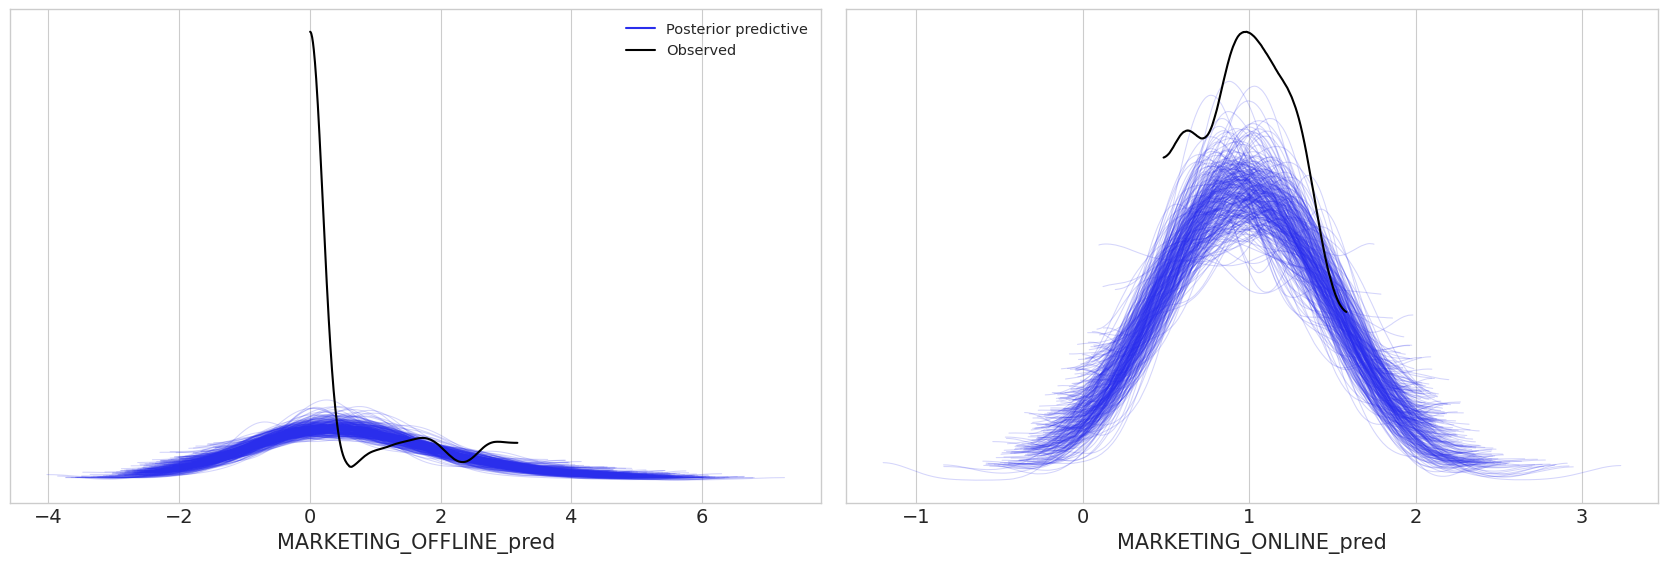

In [112]:
plt.style.use('arviz-colors')
plt.figure(figsize = (20,10))
pm.plot_ppc(ppc_channel_df,# arviz InferenceData type, also works w/ pymc3 trace
            num_pp_samples=300, # number of posterior datasets
            mean=False)
plt.savefig('output_fig.png', 
            dpi = 1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until


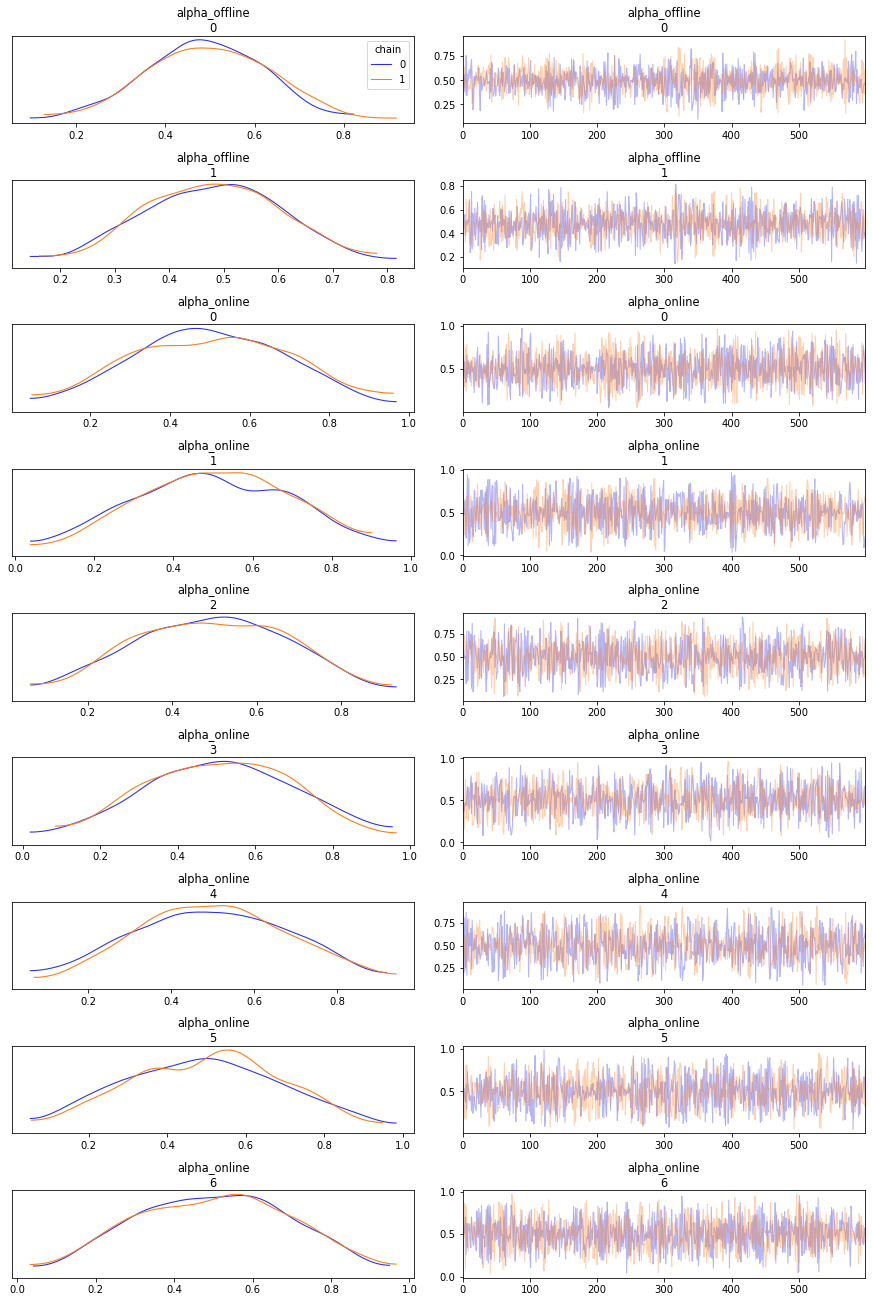

array([[<AxesSubplot:title={'center':'alpha_offline\n0'}>,
        <AxesSubplot:title={'center':'alpha_offline\n0'}>],
       [<AxesSubplot:title={'center':'alpha_offline\n1'}>,
        <AxesSubplot:title={'center':'alpha_offline\n1'}>],
       [<AxesSubplot:title={'center':'alpha_online\n0'}>,
        <AxesSubplot:title={'center':'alpha_online\n0'}>],
       [<AxesSubplot:title={'center':'alpha_online\n1'}>,
        <AxesSubplot:title={'center':'alpha_online\n1'}>],
       [<AxesSubplot:title={'center':'alpha_online\n2'}>,
        <AxesSubplot:title={'center':'alpha_online\n2'}>],
       [<AxesSubplot:title={'center':'alpha_online\n3'}>,
        <AxesSubplot:title={'center':'alpha_online\n3'}>],
       [<AxesSubplot:title={'center':'alpha_online\n4'}>,
        <AxesSubplot:title={'center':'alpha_online\n4'}>],
       [<AxesSubplot:title={'center':'alpha_online\n5'}>,
        <AxesSubplot:title={'center':'alpha_online\n5'}>],
       [<AxesSubplot:title={'center':'alpha_online\n6'}>,
  

In [65]:
plt.style.use('arviz-colors')
pm.traceplot(ppc_channel_df, 
             compact=False, 
             var_names=['^a'], 
             filter_vars='regex',
             legend=True, show=True)

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


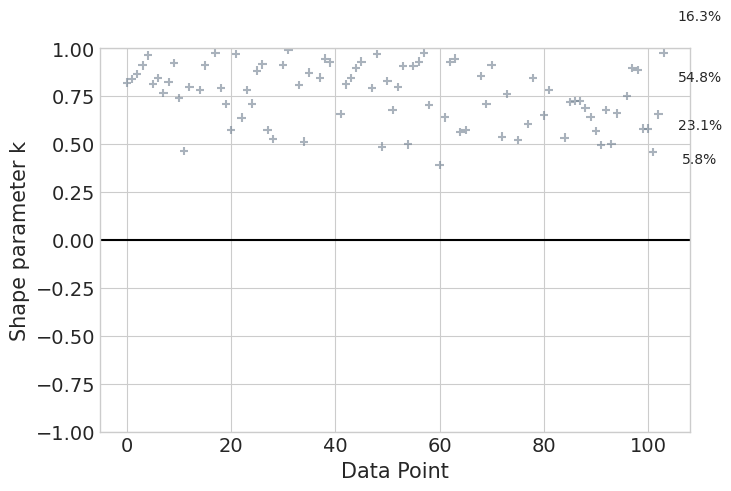

In [71]:
# compute with arviz InferenceData type
pw_rint_loo = pm.loo(trace_channel_2, 
                     pointwise=True, 
                     var_name="MARKETING_ONLINE_pred")

# plot khat diagnostic
plt.style.use("arviz-whitegrid")
pm.plot_khat(pw_rint_loo, 
             show_bins=True, 
             color='slategray',
             alpha=0.6)
plt.axhline(0, color='black')
plt.ylim((-1, 1))
plt.savefig('k_hat_pareto.png', 
            dpi = 1000)

In [114]:
with online_model_channel_3:
    # sample using the model
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.8)
    trace_channel_2 = pm.sample(200, 
                                tune=100, 
                                discard_tuned_samples=True, 
                                chains=2,
                                return_inferencedata=False, 
                                compute_convergence_checks=True, 
                                random_seed=42)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_digitalpartnership_to_onlinetgt, beta_youtube_to_onlinetgt, beta_olv_to_onlinetgt, beta_facebook_to_onlinetgt, beta_amazondisplay_to_onlinetgt, beta_amazonsearch_to_onlinetgt, beta_search_to_onlinetgt, beta_amazondisplay_to_youtube, beta_amazonsearch_to_youtube, beta_search_to_youtube, beta_amazondisplay_to_digitalpartnership, beta_amazonsearch_to_digitalpartnership, beta_search_to_digitalpartnership, beta_amazondisplay_to_olv, beta_amazonsearch_to_olv, beta_search_to_olv, beta_amazondisplay_to_facebook, beta_amazonsearch_to_facebook, beta_search_to_facebook, beta_amazonsearch_to_amazondisplay, beta_search_to_amazondisplay, beta_search_to_amazonsearch]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 4 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [116]:
with online_model_channel_3:
    # sample using the model
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.8)
    trace_channel_2 = pm.sample(200, 
                                tune=100, 
                                discard_tuned_samples=True, 
                                chains=2,
                                return_inferencedata=False, 
                                compute_convergence_checks=True, 
                                random_seed=42)
    
ppc_channel_2 = pm.sample_posterior_predictive(trace_channel_2, 
                                               samples=600, 
                                               model = online_model_channel_3)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_digitalpartnership_to_onlinetgt, beta_youtube_to_onlinetgt, beta_olv_to_onlinetgt, beta_facebook_to_onlinetgt, beta_amazondisplay_to_onlinetgt, beta_amazonsearch_to_onlinetgt, beta_search_to_onlinetgt, beta_amazondisplay_to_youtube, beta_amazonsearch_to_youtube, beta_search_to_youtube, beta_amazondisplay_to_digitalpartnership, beta_amazonsearch_to_digitalpartnership, beta_search_to_digitalpartnership, beta_amazondisplay_to_olv, beta_amazonsearch_to_olv, beta_search_to_olv, beta_amazondisplay_to_facebook, beta_amazonsearch_to_facebook, beta_search_to_facebook, beta_amazonsearch_to_amazondisplay, beta_search_to_amazondisplay, beta_search_to_amazonsearch]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 4 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [117]:
prior_pred = pm.sample_prior_predictive(samples = 600, 
                                        model = online_model_channel_3)
ppc_channel_df = az.from_pymc3(
        trace=trace_channel_2,
        prior=prior_pred,
        posterior_predictive=ppc_channel_2,
    )

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable core_search's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_amazonsearch's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_amazondisplay's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_digitalpartnership's shape not compatible with number of chains and draws. This can mean that some draws or even wh

In [101]:
channel_contrib =pd.DataFrame()
channel_contrib['online'] = contrib_df['online']
channel_contrib['offline'] = contrib_df['offline']

In [102]:
channel_contrib['online_pred'] = ppc_channel_2['MARKETING_ONLINE_pred'].mean(axis=0) *\
                                 transform_lookup_contrib['online']

In [103]:
for col in contrib_df.columns:
    contrib_df[col] = pd.to_numeric(contrib_df[col])
    
contrib_df.head()    

,total_pred_mm,total_exclonline,total_excloffline,tgt_pred,TGT,online,offline,baseline,total,baseline_1,media
0,443674.922506,400818.744836,414268.419917,445654.870652,422469.585311,40807.876872,28001.025805,374205.870609,446468.550869,371412.242247,72262.680260
1,446040.316628,377943.879417,397577.095089,445444.835262,415916.464360,63497.465015,45190.201429,336926.363065,453486.021815,329480.657878,116559.658750
2,419661.661739,354485.330428,371026.773171,421168.532285,405222.495441,62933.829858,46961.523312,313711.834783,427523.054662,305850.441860,113811.219879
3,449606.157947,383416.409135,396940.161128,450476.863817,454748.193356,66946.744743,53268.324914,338897.495239,457753.240871,330750.412316,118855.745632
4,431481.105654,368401.772169,376983.598018,433944.149180,431131.889877,63028.280732,54453.400515,322349.703725,439926.544846,313904.264533,117576.841121


### Approach 2 - Sampling the distributions for each channel from the same initial distribution to ensure consistency for the parameters

We use approach 1 except we use a common initial distribution to draw the samples for each of the channel. This allows consistency when modeling the parameters and assumes that only the information flowing through the channels will affect the paramters that are modeled.

Answer: The results are documented below.

In [138]:
%%time
with pm.Model() as online_model_channel_3:
    
#  Defining mean of core variables
    marketing_online_mean = mean_dict['marketing_online_mean']
    core_search_mean = mean_dict['core_search_spend_sum_mean']
    core_amazonsearch_mean = mean_dict['core_amazonsearch_spend_sum_mean']
    core_amazondisplay_mean = mean_dict['core_amazondisplay_spend_sum_mean']
    core_facebook_mean = mean_dict['core_facebook_spend_sum_mean']
    core_olv_mean = mean_dict['core_olv_spend_sum_mean']
    core_youtube_mean = mean_dict['core_youtube_spend_sum_mean']
    core_digitalpartnership_mean = mean_dict['core_digitalpartnership_spend_sum_mean']
    
#  Defining sigma of core variables
    marketing_online_sigma = sigma_dict['marketing_online_sigma']
    core_search_sigma = sigma_dict['core_search_spend_sum_sigma']
    core_amazonsearch_sigma = sigma_dict['core_amazonsearch_spend_sum_sigma']
    core_amazondisplay_sigma = sigma_dict['core_amazondisplay_spend_sum_sigma']
    core_facebook_sigma = sigma_dict['core_facebook_spend_sum_sigma']
    core_olv_sigma = sigma_dict['core_olv_spend_sum_sigma']
    core_youtube_sigma = sigma_dict['core_youtube_spend_sum_sigma']
    core_digitalpartnership_sigma = sigma_dict['core_digitalpartnership_spend_sum_sigma']
    
#  Defining the beta variables

    BoundedNormal =pm.Bound(pm.Normal, lower=0.0)
    
    beta_search_to_amazonsearch = BoundedNormal('beta_search_to_amazonsearch', 0,1, shape=len_df) 
    
    beta_search_to_amazondisplay = BoundedNormal('beta_search_to_amazondisplay',0, 1, shape=len_df) 
    beta_amazonsearch_to_amazondisplay = BoundedNormal('beta_amazonsearch_to_amazondisplay',0,1, shape=len_df) 
    
    beta_search_to_facebook = BoundedNormal('beta_search_to_facebook', 0, 1, shape=len_df) 
    beta_amazonsearch_to_facebook = BoundedNormal('beta_amazonsearch_to_facebook', 0, 1, shape=len_df) 
    beta_amazondisplay_to_facebook = BoundedNormal('beta_amazondisplay_to_facebook', 0, 1, shape=len_df) 
    
    beta_search_to_olv = BoundedNormal('beta_search_to_olv', 0, 1, shape=len_df) 
    beta_amazonsearch_to_olv = BoundedNormal('beta_amazonsearch_to_olv', 0, 1, shape=len_df) 
    beta_amazondisplay_to_olv = BoundedNormal('beta_amazondisplay_to_olv', 0, 1, shape=len_df)
    
    beta_search_to_digitalpartnership = BoundedNormal('beta_search_to_digitalpartnership', 0, 1, shape=len_df) 
    beta_amazonsearch_to_digitalpartnership = BoundedNormal('beta_amazonsearch_to_digitalpartnership', 0, 1, shape=len_df) 
    beta_amazondisplay_to_digitalpartnership = BoundedNormal('beta_amazondisplay_to_digitalpartnership', 0, 1, shape=len_df)
    
    beta_search_to_youtube = BoundedNormal('beta_search_to_youtube', 0, 1, shape=len_df) 
    beta_amazonsearch_to_youtube = BoundedNormal('beta_amazonsearch_to_youtube', 0, 1, shape=len_df) 
    beta_amazondisplay_to_youtube = BoundedNormal('beta_amazondisplay_to_youtube', 0, 1, shape=len_df)
    
    beta_search_to_onlinetgt = BoundedNormal('beta_search_to_onlinetgt', 0, 1, shape=len_df)
    beta_amazonsearch_to_onlinetgt = BoundedNormal('beta_amazonsearch_to_onlinetgt', 0, 1, shape=len_df)
    beta_amazondisplay_to_onlinetgt = BoundedNormal('beta_amazondisplay_to_onlinetgt', 0, 1, shape=len_df)
    beta_facebook_to_onlinetgt = BoundedNormal('beta_facebook_to_onlinetgt', 0, 1, shape=len_df)
    beta_digitalpartnership_to_onlinetgt = BoundedNormal('beta_digitalpartnership_to_onlinetgt', 0, 1, shape=len_df)
    beta_youtube_to_onlinetgt = BoundedNormal('beta_youtube_to_onlinetgt', 0, 1, shape=len_df)
    beta_olv_to_onlinetgt = BoundedNormal('beta_olv_to_onlinetgt', 0, 1, shape=len_df)
    
    
#  Inititalizing the original Bayesian distributions theta and Tau

    theta = pm.Normal('theta', mu = marketing_online_mean, sigma = marketing_online_sigma, shape = len_df)
    
    tau = pm.HalfCauchy('tau', beta = 2, shape = len_df)
    
#  Inititalizing the first level hierarchical distributions for the individual channels

    core_search_theta = pm.Normal('core_search_theta', mu = theta, sigma = tau, shape = len_df)
    core_amazonsearch_theta = pm.Normal('core_amazonsearch_theta', mu = theta, sigma = tau, shape = len_df)
    core_amazondisplay_theta = pm.Normal('core_amazondisplay_theta', mu = theta, sigma = tau, shape = len_df)
    core_facebook_theta = pm.Normal('core_facebook_theta', mu = theta, sigma = tau, shape = len_df)
    core_olv_theta = pm.Normal('core_olv_theta', mu = theta, sigma = tau, shape = len_df)
    core_youtube_theta = pm.Normal('core_youtube_theta', mu = theta, sigma = tau, shape = len_df)
    core_digitalpartnership_theta = pm.Normal('core_digitalpartnership_theta', mu = theta, sigma = tau, shape = len_df)
    
#  Defining the distributions for the individual channel split 
    
    core_search = pm.Normal('core_search', mu = core_search_theta,
                               sigma = core_search_sigma, shape = len_df,
                                observed = df_transformed['core_search_spend_sum'])
    
    core_amazonsearch = pm.Normal('core_amazonsearch', mu = core_amazonsearch_theta \
                                  + beta_search_to_amazonsearch * core_search,
                               sigma = core_amazonsearch_sigma, shape = len_df,
                                observed = df_transformed['core_amazonsearch_spend_sum'])
    
    core_amazondisplay = pm.Normal('core_amazondisplay', mu = core_amazondisplay_theta \
                                  + beta_search_to_amazondisplay * core_search \
                                  + beta_amazonsearch_to_amazondisplay * core_amazonsearch,
                               sigma = core_amazondisplay_sigma, shape = len_df,
                                observed = df_transformed['core_amazondisplay_spend_sum'])
    
    core_facebook = pm.Normal('core_facebook', mu = core_facebook_theta \
                                  + beta_search_to_facebook * core_search \
                                  + beta_amazonsearch_to_facebook * core_amazonsearch \
                                  + beta_amazondisplay_to_facebook * core_amazondisplay,
                               sigma = core_facebook_sigma, shape = len_df,
                                observed = df_transformed['core_facebook_spend_sum'])
    
    core_olv = pm.Normal('core_olv', mu = core_olv_theta \
                                  + beta_search_to_olv * core_search \
                                  + beta_amazonsearch_to_olv * core_amazonsearch \
                                  + beta_amazondisplay_to_olv * core_amazondisplay,
                               sigma = core_olv_sigma, shape = len_df,
                                observed = df_transformed['core_olv_spend_sum'])
    
    core_digitalpartnership = pm.Normal('core_digitalpartnership', mu = core_digitalpartnership_theta \
                                  + beta_search_to_digitalpartnership * core_search \
                                  + beta_amazonsearch_to_digitalpartnership * core_amazonsearch \
                                  + beta_amazondisplay_to_digitalpartnership * core_amazondisplay,
                               sigma = core_digitalpartnership_sigma, shape = len_df,
                                observed = df_transformed['core_digitalpartnership_spend_sum'])
    
    core_youtube = pm.Normal('core_youtube', mu = core_youtube_theta \
                                  + beta_search_to_youtube * core_search \
                                  + beta_amazonsearch_to_youtube * core_amazonsearch \
                                  + beta_amazondisplay_to_youtube * core_amazondisplay,
                               sigma = core_youtube_sigma, shape = len_df,
                                observed = df_transformed['core_youtube_spend_sum'])
    
#  Defining the target variable as online marketing

    marketing_online = pm.Normal('core_marketing_online', mu = rb_marketing_online_mean \
                                  + beta_search_to_onlinetgt * core_search \
                                  + beta_amazonsearch_to_onlinetgt * core_amazonsearch \
                                  + beta_amazondisplay_to_onlinetgt * core_amazondisplay \
                                  + beta_facebook_to_onlinetgt * core_facebook \
                                  + beta_olv_to_onlinetgt * core_olv \
                                  + beta_youtube_to_onlinetgt * core_youtube \
                                  + beta_olv_to_onlinetgt * core_olv,
                               sigma = rb_marketing_online_sigma, shape = len_df,
                                observed = df_transformed['MARKETING_ONLINE'])
    
    
    
    

CPU times: user 6.99 s, sys: 83.8 ms, total: 7.07 s
Wall time: 7.07 s


In [139]:
with online_model_channel_3:
    # sample using the model
    trace_channel_2 = pm.sample(200, tune=100, 
                                discard_tuned_samples=True, 
                                chains=2, 
                                return_inferencedata=False, 
                                compute_convergence_checks=True, 
                                random_seed=42)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [core_digitalpartnership_theta, core_youtube_theta, core_olv_theta, core_facebook_theta, core_amazondisplay_theta, core_amazonsearch_theta, core_search_theta, tau, theta, beta_olv_to_onlinetgt, beta_youtube_to_onlinetgt, beta_digitalpartnership_to_onlinetgt, beta_facebook_to_onlinetgt, beta_amazondisplay_to_onlinetgt, beta_amazonsearch_to_onlinetgt, beta_search_to_onlinetgt, beta_amazondisplay_to_youtube, beta_amazonsearch_to_youtube, beta_search_to_youtube, beta_amazondisplay_to_digitalpartnership, beta_amazonsearch_to_digitalpartnership, beta_search_to_digitalpartnership, beta_amazondisplay_to_olv, beta_amazonsearch_to_olv, beta_search_to_olv, beta_amazondisplay_to_facebook, beta_amazonsearch_to_facebook, beta_search_to_facebook, beta_amazonsearch_to_amazondisplay, beta_search_to_amazondisplay, beta_search_to_amazonsearch]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 20 seconds.


In [140]:
ppc_channel_2 = pm.sample_posterior_predictive(trace_channel_2, 
                                               samples=200, 
                                               model = online_model_channel_3)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [141]:
ppc_channel_2.keys()

dict_keys(['core_search', 'core_amazonsearch', 'core_amazondisplay', 'core_facebook', 'core_olv', 'core_digitalpartnership', 'core_youtube', 'core_marketing_online'])

In [142]:
prior_pred = pm.sample_prior_predictive( samples = 200, 
                                        model = online_model_channel_3)
ppc_channel_df = az.from_pymc3(
        trace=trace_channel_2,
        prior=prior_pred,
        posterior_predictive=ppc_channel_2,
        model = online_model_channel_3
    )

posterior predictive variable core_search's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_amazonsearch's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_amazondisplay's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_facebook's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_olv's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable core_digitalpartnership's shape not compatible with number of chains and draws. This can mean that some draw

In [144]:
channel_contrib =pd.DataFrame()
channel_contrib['online'] = contrib_df['online']

In [153]:
#channel_contrib['online_pred'] = ppc_channel_2['core_marketing_online'].mean(axis=0)*transform_lookup_contrib['online']
channel_contrib['online_pred'] = ppc_channel_2['core_marketing_online'].mean(axis=0)

In [148]:
#channel_contrib

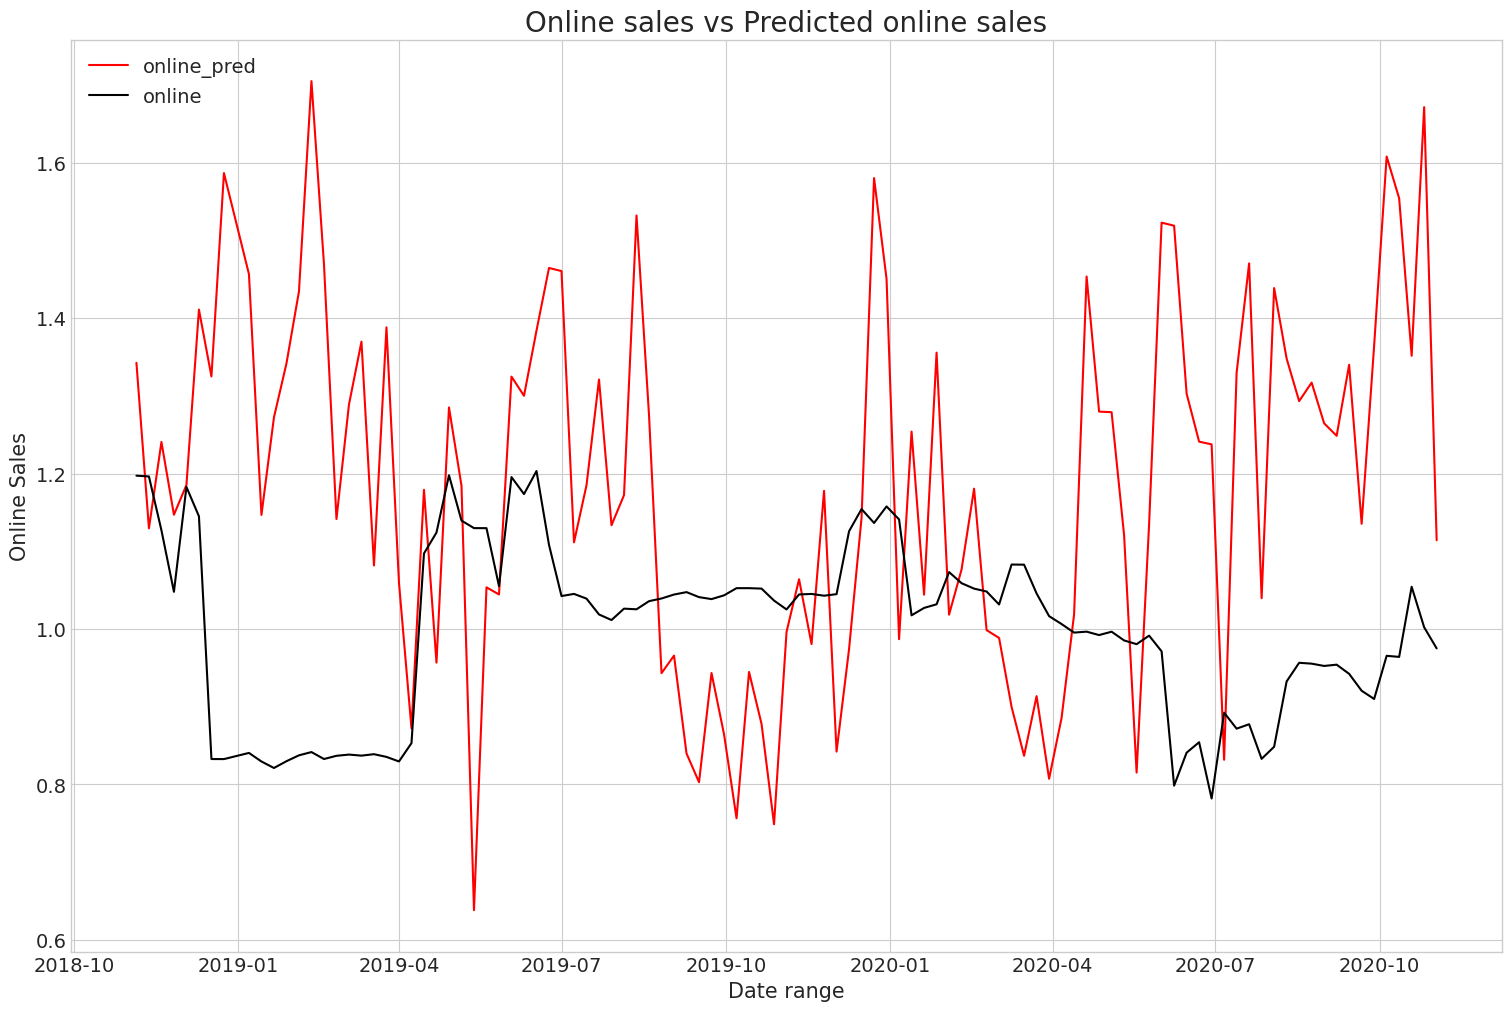

In [161]:
plt.figure(figsize = (15,10))
plt.plot(week_index, channel_contrib['online_pred']/1.5, 
         c ='r', label = 'online_pred')

plt.plot( week_index, df_transformed['MARKETING_ONLINE'], 
         c= 'black', label = 'online')

# plt.plot(week_index, 
#          ppc_channel_2['core_amazonsearch'].mean(axis=0), c ='b', 
#          label = 'core_amazonsearch')

# plt.plot(week_index, 
#          ppc_channel_2['core_search'].mean(axis=0), c ='g', 
#          label = 'core_search')

# plt.plot(week_index, 
#          ppc_channel_2['core_amazondisplay'].mean(axis=0), 
#          c ='c', label = 'core_amazondisplay')

plt.xlabel('Date range', size = 15)
plt.ylabel('Online Sales', size = 15)
plt.title('Online sales vs Predicted online sales', size = 20)
plt.legend()

plt.savefig('predicted_online_sales.png', dpi = 500)

In [ ]:
plt.figure(figsize = (15,10))
plt.plot( week_index, df_transformed['MARKETING_ONLINE'], 
         c= 'black', label = 'online')

plt.plot(week_index, 
         ppc_channel_2['core_amazonsearch'].mean(axis=0), 
         c ='b', 
         label = 'core_amazonsearch')

plt.plot(week_index, 
         ppc_channel_2['core_search'].mean(axis=0), 
         c ='g', 
         label = 'core_search')

plt.plot(week_index, 
         ppc_channel_2['core_amazondisplay'].mean(axis=0), 
         c ='c', 
         label = 'core_amazondisplay')

plt.legend()

### Approach 3 - Adding Deconfounder variables to split nodes and find the indirect contribution

Adding deconfounder varaibles to enable the common confounding effect that is caused by different channels when we calculate the contributions for a single channel. This will be adjusted in our calculations by adding the Z variables. The formula to calcuate the constribution of facebook would change accordingly:

$$ contribution(Facebook) = (totalspend_{facebook}) +  \beta_{facebook} *( \beta_{facebook_Ztosearch} * search + \beta_{facebook_Ztoamzsearch} * amzsearch ) + \beta_{facebook_Ztofacebook} * facebook ) $$

This allows us to capture and model the indirect components that affect the facebook channel as well. This allows us to attribute the indirect effect of other channels to their respective nodes. This improves efficiency and gives a good way of quantifying channel contribution for all the channels.

$$ Contribution_{indirect}(Facebook) = \frac{( \beta_{search_Ztofacebook} * facebook + \beta_{search_Ztofacebook} * facebook + \beta_{search_Ztofacebook} * facebook)}{\sum \beta_{channel_Ztofacebook}}  $$

Answer: The results are documented below.

Online channel Graph


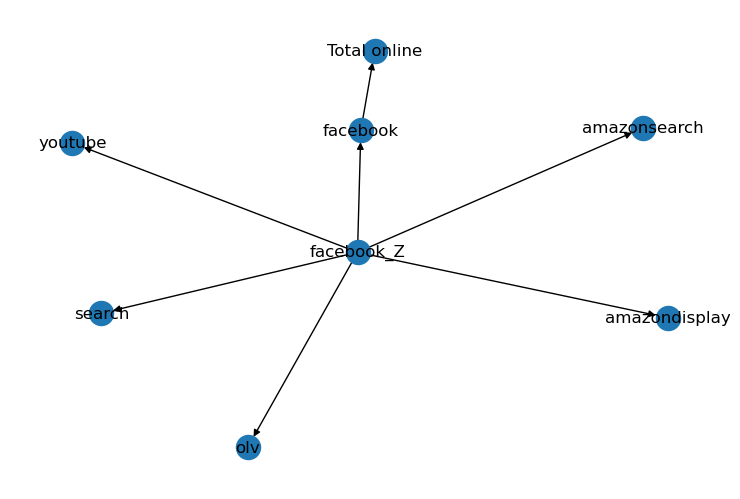

In [177]:
# For Facebook

import networkx as nx

graph = nx.DiGraph()

graph.add_edges_from([ ("facebook_Z", "search"),
                     ("facebook_Z", "amazonsearch"),
                     ("facebook_Z", "amazondisplay"),
                     ("facebook_Z", "facebook"),
                      ("facebook_Z", "olv"),
                      ("facebook_Z", "youtube"),
                      ("facebook","Total online")])
                      
layout = nx.spring_layout(graph)
print("Online channel Graph")
nx.draw(graph, layout, with_labels=True)

In [169]:
with pm.Model() as online_deconfounding_channel:
    
    
    #  Defining the beta variables

    BoundedNormal = pm.Bound(pm.Normal, lower = 0.0, upper = 1.0)

    beta_search_to_onlinetgt = BoundedNormal('beta_search_to_onlinetgt', 
                                             0, 1, shape=len_df)
    beta_amazonsearch_to_onlinetgt = BoundedNormal('beta_amazonsearch_to_onlinetgt', 
                                                   0, 1, shape=len_df)
    beta_amazondisplay_to_onlinetgt = BoundedNormal('beta_amazondisplay_to_onlinetgt', 
                                                    0, 1, shape=len_df)
    beta_facebook_to_onlinetgt = BoundedNormal('beta_facebook_to_onlinetgt', 
                                               0, 1, shape=len_df)
    beta_digitalpartnership_to_onlinetgt = BoundedNormal('beta_digitalpartnership_to_onlinetgt', 
                                                         0, 1, shape=len_df)
    beta_youtube_to_onlinetgt = BoundedNormal('beta_youtube_to_onlinetgt', 
                                              0, 1, shape=len_df)
    beta_olv_to_onlinetgt = BoundedNormal('beta_olv_to_onlinetgt', 
                                          0, 1, shape=len_df)
    
    beta_amazonsearchZ_to_search = BoundedNormal('beta_amazonsearchZ_to_search', 
                                                 0, 1, shape=len_df)
    beta_amazondisplayZ_to_search = BoundedNormal('beta_amazondisplayZ_to_search', 
                                                  0, 1, shape=len_df)
    beta_facebookZ_to_search = BoundedNormal('beta_facebookZ_to_search', 
                                             0, 1, shape=len_df)
    beta_olvZ_to_search = BoundedNormal('beta_olvZ_to_search', 
                                        0, 1, shape=len_df)
    beta_digitalpartnershipZ_to_search = BoundedNormal('beta_digitalpartnershipZ_to_search', 
                                                       0, 1, shape=len_df)
    beta_youtubeZ_to_search = BoundedNormal('beta_youtubeZ_to_search', 
                                            0, 1, shape=len_df)
    
    beta_search_to_amazonsearch = BoundedNormal('beta_search_to_amazonsearch', 
                                                0, 1, shape=len_df)
    beta_amazondisplayZ_to_amazonsearch = BoundedNormal('beta_amazondisplayZ_to_amazonsearch', 
                                                        0, 1, shape=len_df)
    beta_facebookZ_to_amazonsearch = BoundedNormal('beta_facebookZ_to_amazonsearch', 
                                                   0, 1, shape=len_df)
    beta_olvZ_to_amazonsearch = BoundedNormal('beta_olvZ_to_amazonsearch', 
                                              0, 1, shape=len_df)
    beta_digitalpartnershipZ_to_amazonsearch = BoundedNormal('beta_digitalpartnershipZ_to_amazonsearch', 
                                                             0, 1, shape=len_df)
    beta_youtubeZ_to_amazonsearch = BoundedNormal('beta_youtubeZ_to_amazonsearch', 
                                                  0, 1, shape=len_df)
    beta_amazonsearchZ_to_amazonsearch = BoundedNormal('beta_amazonsearchZ_to_amazonsearch', 
                                                       0, 1, shape=len_df)
    
    beta_search_to_amazondisplay = BoundedNormal('beta_search_to_amazondisplay', 
                                                 0, 1, shape=len_df)
    beta_amazondisplayZ_to_amazondisplay = BoundedNormal('beta_amazondisplayZ_to_amazondisplay', 
                                                         0, 1, shape=len_df)
    beta_facebookZ_to_amazondisplay = BoundedNormal('beta_facebookZ_to_amazondisplay', 
                                                    0, 1, shape=len_df)
    beta_olvZ_to_amazondisplay = BoundedNormal('beta_olvZ_to_amazondisplay', 
                                               0, 1, shape=len_df)
    beta_digitalpartnershipZ_to_amazondisplay = BoundedNormal('beta_digitalpartnershipZ_to_amazondisplay', 
                                                              0, 1, shape=len_df)
    beta_youtubeZ_to_amazondisplay = BoundedNormal('beta_youtubeZ_to_amazondisplay', 
                                                   0, 1, shape=len_df)
    beta_amazonsearchZ_to_amazondisplay = BoundedNormal('beta_amazonsearchZ_to_amazondisplay', 
                                                        0, 1, shape=len_df)
    
    beta_search_to_facebook = BoundedNormal('beta_search_to_facebook', 
                                            0, 1, shape=len_df)
    beta_amazondisplayZ_to_facebook = BoundedNormal('beta_amazondisplayZ_to_facebook', 
                                                    0, 1, shape=len_df)
    beta_facebookZ_to_facebook = BoundedNormal('beta_facebookZ_to_facebook', 
                                               0, 1, shape=len_df)
    beta_amazonsearchZ_to_facebook = BoundedNormal('beta_amazonsearchZ_to_facebook', 
                                                   0, 1, shape=len_df)
    
    beta_search_to_olv = BoundedNormal('beta_search_to_olv', 
                                       0, 1, shape = len_df)
    beta_amazondisplayZ_to_olv = BoundedNormal('beta_amazondisplayZ_to_olv', 
                                               0, 1, shape=len_df)
    beta_amazonsearchZ_to_olv = BoundedNormal('beta_amazonsearchZ_to_olv', 
                                              0, 1, shape=len_df)
    beta_olvZ_to_olv = BoundedNormal('beta_olvZ_to_olv', 
                                     0, 1, shape = len_df)
    
    beta_search_to_digitalpartnership = BoundedNormal('beta_search_to_digitalpartnership', 
                                                      0, 1, shape = len_df)
    beta_amazonsearchZ_to_digitalpartnership = BoundedNormal('beta_amazonsearchZ_to_digitalpartnership', 
                                                             0, 1, shape = len_df)
    beta_amazondisplayZ_to_digitalpartnership = BoundedNormal('beta_amazondisplayZ_to_digitalpartnership', 
                                                              0, 1, shape = len_df)
    beta_digitalpartnershipZ_to_digitalparntership = BoundedNormal('beta_digitalpartnershipZ_to_digitalpartnership', 
                                                                   0, 1, shape = len_df)
    
    beta_search_to_youtube = BoundedNormal('beta_search_to_youtube', 
                                           0, 1, shape = len_df)
    beta_amazonsearchZ_to_youtube = BoundedNormal('beta_amazonsearchZ_to_youtube', 
                                                  0, 1, shape = len_df)
    beta_amazondisplayZ_to_youtube = BoundedNormal('beta_amazondisplayZ_to_youtube', 
                                                   0, 1, shape = len_df)
    beta_youtubeZ_to_youtube = BoundedNormal('beta_youtubeZ_to_youtube', 
                                             0, 1, shape = len_df)
    
    # Defining the unobserved latent variables as Half Normal distributions
    
    amazonsearch_Z = pm.Normal('amazonsearch_Z', 1, shape = len_df)
    amazondisplay_Z = pm.Normal('amazondisplay_Z', 1, shape = len_df)
    facebook_Z = pm.Normal('facebook_Z', 1, shape = len_df)
    youtube_Z = pm.Normal('youtube_Z', 1, shape = len_df)
    olv_Z = pm.Normal('olv_Z',0, 1, shape = len_df)
    digitalpartnership_Z = pm.Normal('digitalpartnership_Z',0, 1, shape = len_df)
    
    
    alpha_online = pm.Beta('alpha_online', 3, 3, shape=[online_len]) #X.shape[1]) # retain rate in adstock 
    theta_online = pm.Uniform('theta_online', 0, 0.5, shape=[online_len]) #X.shape[1]) # delay in adstock
    #var,      dist, pm.name,          params,  shape   
    mu_online     = pm.Gamma('mu_online', 3, 1, shape=[online_len]) #X.shape[1]) # "ec" in saturation, half saturation point
    beta_online  = pm.HalfNormal('beta_online', 1, shape=[online_len, len_df]) #X.shape[1]) # regression coefficient 
    
    comp_online_channel = {}
    media_pred_2 = {}
    online_expression = ""
    mean_expression = ""   
    
    direct_online_channel = {}
    for idx,col in enumerate(online_spend_columns):
        X = df_transformed_channel[col.replace('spend', 'impressions')].values
        
        saturation_adstock_spend = logistic_function(geometric_adstock(x=X, 
                                        theta=theta_online[idx], 
                                        alpha=alpha_online[idx], L=2),
                                        mu=mu_online[idx])
        
        direct_online_channel[col] = saturation_adstock_spend
        
        if 'core_search' in col:
            mu_exp = saturation_adstock_spend + beta_amazonsearchZ_to_search * \
                     amazonsearch_Z + \
                     beta_amazondisplayZ_to_search * amazondisplay_Z + \
                     beta_facebookZ_to_search * facebook_Z + \
                     beta_olvZ_to_search * olv_Z + \
                     beta_digitalpartnershipZ_to_search * digitalpartnership_Z + \
                     beta_youtubeZ_to_search * youtube_Z
                        
        elif 'amazonsearch' in col:
            mu_exp = saturation_adstock_spend + beta_search_to_amazonsearch * \
                     amazonsearch_Z + beta_amazondisplayZ_to_amazonsearch * \
                     amazondisplay_Z + beta_facebookZ_to_amazonsearch * \
                     facebook_Z + beta_olvZ_to_amazonsearch * olv_Z + \
                     beta_digitalpartnershipZ_to_amazonsearch * \
                     digitalpartnership_Z + \
                     beta_youtubeZ_to_amazonsearch * youtube_Z
        
        elif 'amazondisplay' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_amazondisplayZ_to_amazondisplay * amazondisplay_Z + \
                     beta_facebookZ_to_amazondisplay * facebook_Z + \
                     beta_olvZ_to_amazondisplay * olv_Z + \
                     beta_digitalpartnershipZ_to_amazondisplay * \
                     digitalpartnership_Z + \
                     beta_youtubeZ_to_amazondisplay * youtube_Z
                     
                        
        elif 'facebook' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_amazonsearchZ_to_facebook * amazonsearch_Z + \
                     beta_amazondisplayZ_to_facebook * amazondisplay_Z + \
                     beta_facebookZ_to_facebook * facebook_Z
            
        elif 'olv' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_amazonsearchZ_to_olv * amazonsearch_Z + \
                     beta_amazondisplayZ_to_olv * amazondisplay_Z + \
                     beta_olvZ_to_olv * olv_Z
            
        elif 'digitalpartnership' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_amazonsearchZ_to_digitalpartnership * amazonsearch_Z + \
                     beta_amazondisplayZ_to_digitalpartnership * amazondisplay_Z + \
                     beta_digitalpartnershipZ_to_digitalparntership * \
                     digitalpartnership_Z
            
        elif 'youtube' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_amazonsearchZ_to_youtube * amazonsearch_Z + \
                     beta_amazondisplayZ_to_youtube * amazondisplay_Z + \
                     beta_youtubeZ_to_youtube * youtube_Z
            
        comp_online_channel[col] = pm.Deterministic(col.replace('spend', 'pred'),
                                             mu_exp)
        
        print(col.replace('spend', 'pred'))
        if idx == 0:
            online_expression = f"comp_online_channel['{col}']"
        else:
            online_expression += f" + comp_online_channel['{col}']"
        print(col.replace('_SP', '_pred'))
    
    print(online_expression)
    media_pred_2['MARKETING_ONLINE_pred'] = pm.Normal('MARKETING_ONLINE_pred',
                                                         mu=eval(online_expression), 
                                                         sigma=contrib_df_transformed['online'].std(),
                                                         observed=contrib_df_transformed['online'])                 
    

core_search_pred_sum
core_search_spend_sum
core_amazonsearch_pred_sum
core_amazonsearch_spend_sum
core_amazondisplay_pred_sum
core_amazondisplay_spend_sum
core_facebook_pred_sum
core_facebook_spend_sum
core_olv_pred_sum
core_olv_spend_sum
core_digitalpartnership_pred_sum
core_digitalpartnership_spend_sum
core_youtube_pred_sum
core_youtube_spend_sum
comp_online_channel['core_search_spend_sum'] + comp_online_channel['core_amazonsearch_spend_sum'] + comp_online_channel['core_amazondisplay_spend_sum'] + comp_online_channel['core_facebook_spend_sum'] + comp_online_channel['core_olv_spend_sum'] + comp_online_channel['core_digitalpartnership_spend_sum'] + comp_online_channel['core_youtube_spend_sum']


In [88]:
with online_deconfounding_channel:
    # sample using the model
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.8)
    trace_channel_2 = pm.sample(200, tune=100, 
                                discard_tuned_samples=True, 
                                chains=2, 
                                return_inferencedata=False, 
                                compute_convergence_checks=True, 
                                random_seed=42)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_online, mu_online, theta_online, alpha_online, digitalpartnership_Z, olv_Z, youtube_Z, facebook_Z, amazondisplay_Z, amazonsearch_Z, beta_youtubeZ_to_youtube, beta_amazondisplayZ_to_youtube, beta_amazonsearchZ_to_youtube, beta_search_to_youtube, beta_digitalpartnershipZ_to_digitalpartnership, beta_amazondisplayZ_to_digitalpartnership, beta_amazonsearchZ_to_digitalpartnership, beta_search_to_digitalpartnership, beta_olvZ_to_olv, beta_amazonsearchZ_to_olv, beta_amazondisplayZ_to_olv, beta_search_to_olv, beta_amazonsearchZ_to_facebook, beta_facebookZ_to_facebook, beta_amazondisplayZ_to_facebook, beta_search_to_facebook, beta_amazonsearchZ_to_amazondisplay, beta_youtubeZ_to_amazondisplay, beta_digitalpartnershipZ_to_amazondisplay, beta_olvZ_to_amazondisplay, beta_facebookZ_to_amazondisplay, beta_amazondisplayZ_to_amazondisplay, beta_se

Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 102 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


In [89]:
ppc_channel_2 = pm.sample_posterior_predictive(trace_channel_2, 
                                               var_names = trace_channel_2.varnames + 
                                               ['MARKETING_ONLINE_pred'] + 
                                               [col.replace('spend', 'pred') 
                                                for col in online_spend_columns],
                                               samples=600, model = online_deconfounding_channel)

In [77]:
prior_pred = pm.sample_prior_predictive(samples = 600, 
                                        model = online_deconfounding_channel)
ppc_channel_df = az.from_pymc3(
        trace=trace_channel_2,
        prior=prior_pred,
        posterior_predictive=ppc_channel_2,
    )

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable beta_search_to_onlinetgt_interval__'s shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable beta_amazonsearch_to_onlinetgt_interval__'s shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable beta_amazondisplay_to_onlinetgt_interval__'s shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
posterior predictive variable beta_facebook_to_onlinetgt_interval__'s shape no

In [79]:
import arviz as az
print(az.waic(trace_channel_2, 
              var_name="MARKETING_ONLINE_pred"),
      az.loo(trace_channel_2, 
             var_name="MARKETING_ONLINE_pred"))

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 400 by 104 log-likelihood matrix

          Estimate       SE
elpd_waic   -51.17     1.49
p_waic       50.45        -

There has been a warning during the calculation. Please check the results. Computed from 400 by 104 log-likelihood matrix

         Estimate       SE
elpd_loo   -63.25     2.30
p_loo       62.54        -

There has been a warning during the calculation. Please check the results.


/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


In [90]:
channel_contrib =pd. DataFrame()
channel_contrib['online'] = contrib_df['online']
channel_contrib['offline'] = contrib_df['offline']

In [91]:
channel_contrib['online_pred'] = ppc_channel_2['MARKETING_ONLINE_pred'].mean(axis=0)*transform_lookup_contrib['online']/1000000

In [92]:
channel_contrib['online_pred'] = ppc_channel_2['MARKETING_ONLINE_pred'].mean(axis=0)*transform_lookup_contrib['online']/1000000
channel_contrib_df = channel_contrib[channel_contrib['online'] < 1000000]

<AxesSubplot:>

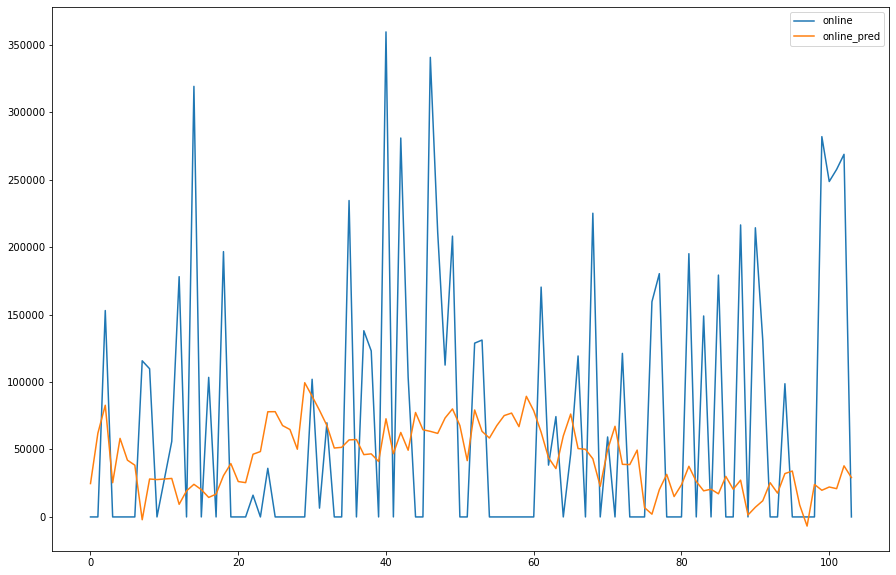

In [247]:
channel_contrib_df[['online', 'online_pred']].plot(figsize=(15,10))

In [93]:
mean_absolute_percentage_error(channel_contrib.online, channel_contrib.online_pred)

0.9999989750782792

In [1443]:
with pm.Model() as online_deconfounding_channel:
    
    
    #  Defining the beta variables

#     BoundedNormal =pm.Bound(pm.Laplace, lower=0.0)
    BoundedNormal = pm.Bound(pm.Normal)

    beta_search_to_onlinetgt = BoundedNormal('beta_search_to_onlinetgt', 0, 1, shape=len_df)
    beta_amazonsearch_to_onlinetgt = BoundedNormal('beta_amazonsearch_to_onlinetgt', 0, 1, shape=len_df)
    beta_amazondisplay_to_onlinetgt = BoundedNormal('beta_amazondisplay_to_onlinetgt', 0, 1, shape=len_df)
    beta_facebook_to_onlinetgt = BoundedNormal('beta_facebook_to_onlinetgt', 0, 1, shape=len_df)
    beta_digitalpartnership_to_onlinetgt = BoundedNormal('beta_digitalpartnership_to_onlinetgt', 0, 1, shape=len_df)
    beta_youtube_to_onlinetgt = BoundedNormal('beta_youtube_to_onlinetgt', 0, 1, shape=len_df)
    beta_olv_to_onlinetgt = BoundedNormal('beta_olv_to_onlinetgt', 0, 1, shape=len_df)
    
    ## amazon search 
    
    beta_search_to_amazonsearch = BoundedNormal('beta_search_to_amazonsearch', 0, 1, shape=len_df)
    beta_amazonsearchZ_to_amazonsearch = BoundedNormal('beta_amazonsearchZ_to_amazonsearch', 0, 1, shape=len_df)
    beta_amazonsearchZ_to_amazondisplay = BoundedNormal('beta_amazonsearchZ_to_amazondisplay', 0, 1, shape=len_df)
    beta_amazonsearchZ_to_youtube = BoundedNormal('beta_amazonsearchZ_to_youtube', 0, 1, shape=len_df)
    beta_amazonsearchZ_to_olv = BoundedNormal('beta_amazonsearchZ_to_olv', 0, 1, shape=len_df)
    beta_amazonsearchZ_to_digitalpartnership = BoundedNormal('beta_amazonsearchZ_to_digitalpartnership', 0, 1, shape=len_df)
    beta_amazonsearchZ_to_facebook = BoundedNormal('beta_amazonsearchZ_to_facebook', 0, 1, shape=len_df)
    ##
#     beta_search_to_amazonsearch = 0
#     beta_amazonsearchZ_to_amazonsearch = 0
#     beta_amazonsearchZ_to_amazondisplay = 0
#     beta_amazonsearchZ_to_youtube = 0
#     beta_amazonsearchZ_to_olv = 0
#     beta_amazonsearchZ_to_digitalpartnership = 0
#     beta_amazonsearchZ_to_facebook = 0

    
    ## amazon display
    
    beta_search_to_amazondisplay = BoundedNormal('beta_search_to_amazondisplay', 0, 1, shape=len_df)
    beta_amazondisplayZ_to_amazonsearch = BoundedNormal('beta_amazondisplayZ_to_amazonsearch', 0, 1, shape = len_df)
    beta_amazondisplayZ_to_amazondisplay = BoundedNormal('beta_amazondisplayZ_to_amazondisplay', 0, 1, shape = len_df)
    beta_amazondisplayZ_to_youtube = BoundedNormal('beta_amazondisplayZ_to_youtube', 0, 1, shape = len_df)
    beta_amazondisplayZ_to_olv = BoundedNormal('beta_amazondisplayZ_to_olv', 0, 1, shape = len_df)
    beta_amazondisplayZ_to_digitalpartnership = BoundedNormal('beta_amazondisplayZ_to_digitalpartnership', 0, 1, shape = len_df)
    beta_amazondisplayZ_to_facebook = BoundedNormal('beta_amazondisplayZ_to_facebook', 0, 1, shape = len_df)
    ##
#     beta_search_to_amazondisplay = 0
#     beta_amazondisplayZ_to_amazonsearch = 0
#     beta_amazondisplayZ_to_amazondisplay = 0
#     beta_amazondisplayZ_to_youtube = 0
#     beta_amazondisplayZ_to_olv = 0
#     beta_amazondisplayZ_to_digitalpartnership = 0
#     beta_amazondisplayZ_to_facebook = 0
    

    
    ## beta facebook 
    
    beta_search_to_facebook = BoundedNormal('beta_search_to_facebook', 0, 1, shape=len_df)
    beta_facebookZ_to_amazonsearch = BoundedNormal('beta_facebookZ_to_amazonsearch', 0, 1, shape = len_df)
    beta_facebookZ_to_amazondisplay = BoundedNormal('beta_facebookZ_to_amazondisplay', 0, 1, shape = len_df)
    beta_facebookZ_to_youtube = BoundedNormal('beta_facebookZ_to_youtube', 0, 1, shape = len_df)
    beta_facebookZ_to_olv = BoundedNormal('beta_facebookZ_to_olv', 0, 1, shape = len_df)
    beta_facebookZ_to_digitalpartnership = BoundedNormal('beta_facebookZ_to_digitalpartnership', 0, 1, shape = len_df)
    beta_facebookZ_to_facebook = BoundedNormal('beta_facebookZ_to_facebook', 0, 1, shape = len_df)
    ##
#     beta_search_to_facebook = 0
#     beta_facebookZ_to_amazonsearch = 0
#     beta_facebookZ_to_amazondisplay = 0
#     beta_facebookZ_to_youtube = 0
#     beta_facebookZ_to_olv = 0
#     beta_facebookZ_to_digitalpartnership = 0
#     beta_facebookZ_to_facebook = 0
    
    ## Beta olv
    
    beta_search_to_olv = BoundedNormal('beta_search_to_olv', 0, 1, shape=len_df)
    beta_olvZ_to_amazonsearch = BoundedNormal('beta_olvZ_to_amazonsearch', 0, 1, shape = len_df)
    beta_olvZ_to_amazondisplay = BoundedNormal('beta_olvZ_to_amazondisplay', 0, 1, shape = len_df)
    beta_olvZ_to_youtube = BoundedNormal('beta_olvZ_to_youtube', 0, 1, shape = len_df)
    beta_olvZ_to_olv = BoundedNormal('beta_olvZ_to_olv', 0, 1, shape = len_df)
    beta_olvZ_to_digitalpartnership = BoundedNormal('beta_olvZ_to_digitalpartnership', 0, 1, shape = len_df)
    beta_olvZ_to_facebook = BoundedNormal('beta_olvZ_to_facebook', 0, 1, shape = len_df)
    ##
#     beta_search_to_olv = 0
#     beta_olvZ_to_amazonsearch = 0
#     beta_olvZ_to_amazondisplay = 0
#     beta_olvZ_to_youtube = 0
#     beta_olvZ_to_olv = 0
#     beta_olvZ_to_digitalpartnership = 0
#     beta_olvZ_to_facebook = 0
    
    ## beta digitalpartnership
    
    beta_search_to_digitalpartnership = BoundedNormal('beta_search_to_digitalpartnership', 0, 1, shape=len_df)
    beta_digitalpartnershipZ_to_amazonsearch = BoundedNormal('beta_digitalpartnershipZ_to_amazonsearch', 0, 1, shape = len_df)
    beta_digitalpartnershipZ_to_amazondisplay = BoundedNormal('beta_digitalpartnershipZ_to_amazondisplay', 0, 1, shape = len_df)
    beta_digitalpartnershipZ_to_youtube = BoundedNormal('beta_digitalpartnershipZ_to_youtube', 0, 1, shape = len_df)
    beta_digitalpartnershipZ_to_olv = BoundedNormal('beta_digitalpartnershipZ_to_olv', 0, 1, shape = len_df)
    beta_digitalpartnershipZ_to_digitalpartnership = BoundedNormal('beta_digitalpartnershipZ_to_digitalpartnership', 0, 1, shape = len_df)
    beta_digitalpartnershipZ_to_facebook = BoundedNormal('beta_digitalpartnershipZ_to_facebook', 0, 1, shape = len_df)

    ##
#     beta_search_to_digitalpartnership = 0
#     beta_digitalpartnershipZ_to_amazonsearch = 0
#     beta_digitalpartnershipZ_to_amazondisplay = 0
#     beta_digitalpartnershipZ_to_youtube = 0
#     beta_digitalpartnershipZ_to_olv = 0
#     beta_digitalpartnershipZ_to_digitalpartnership = 0
#     beta_digitalpartnershipZ_to_facebook = 0

    
    ## beta youtube
    
    beta_search_to_youtube = BoundedNormal('beta_search_to_youtube', 0, 1, shape=len_df)
    beta_youtubeZ_to_amazonsearch = BoundedNormal('beta_youtubeZ_to_amazonsearch', 0, 1, shape = len_df)
    beta_youtubeZ_to_amazondisplay = BoundedNormal('beta_youtubeZ_to_amazondisplay', 0, 1, shape = len_df)
    beta_youtubeZ_to_youtube = BoundedNormal('beta_youtubeZ_to_youtube', 0, 1, shape = len_df)
    beta_youtubeZ_to_olv = BoundedNormal('beta_youtubeZ_to_olv', 0, 1, shape = len_df)
    beta_youtubeZ_to_digitalpartnership = BoundedNormal('beta_youtubeZ_to_digitalpartnership', 0, 1, shape = len_df)
    beta_youtubeZ_to_facebook = BoundedNormal('beta_youtubeZ_to_facebook', 0, 1, shape = len_df)
#     beta_search_to_youtube = 0
#     beta_youtubeZ_to_amazonsearch = 0
#     beta_youtubeZ_to_amazondisplay = 0
#     beta_youtubeZ_to_youtube = 0
#     beta_youtubeZ_to_olv = 0
#     beta_youtubeZ_to_digitalpartnership = 0
#     beta_youtubeZ_to_facebook = 0
    
    # Defining the unobserved latent variables as Half Normal distributions
    
    amazonsearch_Z = pm.HalfNormal('amazonsearch_Z', 1, shape = len_df)
    amazondisplay_Z = pm.HalfNormal('amazondisplay_Z', 1, shape = len_df)
    facebook_Z = pm.HalfNormal('facebook_Z', 1, shape = len_df)
    youtube_Z = pm.HalfNormal('youtube_Z', 1, shape = len_df)
    olv_Z = pm.HalfNormal('olv_Z', 1, shape = len_df)
    digitalpartnership_Z = pm.HalfNormal('digitalpartnership_Z', 1, shape = len_df)
    
    
    alpha_online = pm.Beta('alpha_online',           3, 3,   shape=[online_len]) #X.shape[1]) # retain rate in adstock 
    theta_online = pm.Uniform('theta_online',        0 , 0.5,   shape=[online_len]) #X.shape[1]) # delay in adstock
    #var,      dist, pm.name,          params,  shape   
    mu_online     = pm.Gamma('mu_online',               3, 1,   shape=[online_len]) #X.shape[1]) # "ec" in saturation, half saturation point
    beta_online  = pm.HalfNormal('beta_online',    1,   shape=[online_len, len_df]) #X.shape[1]) # regression coefficient 
    
    comp_online_channel = {}
    media_pred_2 = {}
    online_expression = ""
    mean_expression = ""   
    
    direct_online_channel = {}
    for idx,col in enumerate(online_spend_columns):
        X = df_transformed_channel[col.replace('spend', 'impressions')].values
        
        saturation_adstock_spend = logistic_function(geometric_adstock(x=X, 
                                        theta=theta_online[idx], alpha=alpha_online[idx], L=2)
                                        , mu=mu_online[idx])
        
        direct_online_channel[col] = saturation_adstock_spend
        
        
        
        if 'core_search' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_search_to_amazonsearch * amazonsearch_Z +\
                     beta_search_to_amazondisplay * amazondisplay_Z + \
                     beta_search_to_facebook * facebook_Z +\
                     beta_search_to_olv * olv_Z + \
                     beta_search_to_digitalpartnership * digitalpartnership_Z +\
                     beta_search_to_youtube * youtube_Z
            mu_exp *= beta_search_to_onlinetgt 
                        
        elif 'amazonsearch' in col:
            mu_exp = saturation_adstock_spend +\
                     beta_amazonsearchZ_to_amazonsearch  * amazonsearch_Z +\
                     beta_amazonsearchZ_to_amazondisplay * amazondisplay_Z +\
                     beta_amazonsearchZ_to_youtube * youtube_Z+\
                     beta_amazonsearchZ_to_olv * olv_Z+\
                     beta_amazonsearchZ_to_digitalpartnership * digitalpartnership_Z+\
                     beta_amazonsearchZ_to_facebook * facebook_Z
            mu_exp *= beta_amazonsearch_to_onlinetgt
        
        elif 'amazondisplay' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_amazondisplayZ_to_amazondisplay * amazondisplay_Z + \
                     beta_amazondisplayZ_to_amazonsearch * amazonsearch_Z + \
                     beta_amazondisplayZ_to_facebook * facebook_Z + \
                     beta_amazondisplayZ_to_olv * olv_Z + \
                     beta_amazondisplayZ_to_digitalpartnership * digitalpartnership_Z + \
                     beta_amazondisplayZ_to_youtube * youtube_Z
            mu_exp *= beta_amazondisplay_to_onlinetgt
    
                        
        elif 'facebook' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_facebookZ_to_facebook * facebook_Z +\
                     beta_facebookZ_to_amazonsearch * amazonsearch_Z +\
                     beta_facebookZ_to_amazondisplay * amazondisplay_Z +\
                     beta_facebookZ_to_youtube * youtube_Z +\
                     beta_facebookZ_to_olv * olv_Z +\
                     beta_facebookZ_to_digitalpartnership * digitalpartnership_Z
            mu_exp *= beta_facebook_to_onlinetgt
                    
        elif 'olv' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_olvZ_to_olv * olv_Z +\
                     beta_olvZ_to_amazonsearch * amazonsearch_Z +\
                     beta_olvZ_to_amazondisplay * amazondisplay_Z+\
                     beta_olvZ_to_youtube * youtube_Z +\
                     beta_olvZ_to_digitalpartnership * digitalpartnership_Z +\
                     beta_olvZ_to_facebook * facebook_Z
            mu_exp *= beta_olv_to_onlinetgt
            
        elif 'digitalpartnership' in col:
            mu_exp = saturation_adstock_spend + \
                     beta_digitalpartnershipZ_to_digitalpartnership * digitalpartnership_Z+\
                     beta_digitalpartnershipZ_to_amazonsearch * amazonsearch_Z+\
                     beta_digitalpartnershipZ_to_amazondisplay * amazondisplay_Z+\
                     beta_digitalpartnershipZ_to_youtube * youtube_Z+\
                     beta_digitalpartnershipZ_to_olv * olv_Z+\
                     beta_digitalpartnershipZ_to_facebook * facebook_Z
            mu_exp *= beta_digitalpartnership_to_onlinetgt
            
        elif 'youtube' in col:
            mu_exp = saturation_adstock_spend +\
                     beta_youtubeZ_to_amazonsearch * amazonsearch_Z +\
                     beta_youtubeZ_to_amazondisplay * amazondisplay_Z +\
                     beta_youtubeZ_to_youtube * youtube_Z +\
                     beta_youtubeZ_to_olv * olv_Z +\
                     beta_youtubeZ_to_digitalpartnership * digitalpartnership_Z +\
                     beta_youtubeZ_to_facebook * facebook_Z
            mu_exp *= beta_youtube_to_onlinetgt
                   
        comp_online_channel[col] = pm.Deterministic(col.replace('spend', 'pred'),
                                             mu_exp)
        
        print(col.replace('spend', 'pred'))
        if idx == 0:
            online_expression = f"comp_online_channel['{col}']"
        else:
            online_expression += f" + comp_online_channel['{col}']"
        print(col.replace('_SP', '_pred'))
    
    print(online_expression)
    media_pred_2['MARKETING_ONLINE_pred'] = pm.Normal('MARKETING_ONLINE_pred', 
                                                         mu=eval(online_expression), 
                                                         sigma=contrib_df_transformed['online'].std(),
                                                         observed=contrib_df_transformed['online'])      
    
## make one to zero rest alive
## see contributions rather than beta Z variable and individual channel

core_search_pred_sum
core_search_spend_sum
core_amazonsearch_pred_sum
core_amazonsearch_spend_sum
core_amazondisplay_pred_sum
core_amazondisplay_spend_sum
core_facebook_pred_sum
core_facebook_spend_sum
core_olv_pred_sum
core_olv_spend_sum
core_digitalpartnership_pred_sum
core_digitalpartnership_spend_sum
core_youtube_pred_sum
core_youtube_spend_sum
comp_online_channel['core_search_spend_sum'] + comp_online_channel['core_amazonsearch_spend_sum'] + comp_online_channel['core_amazondisplay_spend_sum'] + comp_online_channel['core_facebook_spend_sum'] + comp_online_channel['core_olv_spend_sum'] + comp_online_channel['core_digitalpartnership_spend_sum'] + comp_online_channel['core_youtube_spend_sum']


In [1444]:
with online_deconfounding_channel:
    # sample using the model
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.8)
    trace_channel_2 = pm.sample(200, tune=100, 
                                discard_tuned_samples=True, 
                                chains = 2, return_inferencedata=False, 
                                compute_convergence_checks=True, 
                                random_seed=42)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_online, mu_online, theta_online, alpha_online, digitalpartnership_Z, olv_Z, youtube_Z, facebook_Z, amazondisplay_Z, amazonsearch_Z, beta_youtubeZ_to_facebook, beta_youtubeZ_to_digitalpartnership, beta_youtubeZ_to_olv, beta_youtubeZ_to_youtube, beta_youtubeZ_to_amazondisplay, beta_youtubeZ_to_amazonsearch, beta_search_to_youtube, beta_digitalpartnershipZ_to_facebook, beta_digitalpartnershipZ_to_digitalpartnership, beta_digitalpartnershipZ_to_olv, beta_digitalpartnershipZ_to_youtube, beta_digitalpartnershipZ_to_amazondisplay, beta_digitalpartnershipZ_to_amazonsearch, beta_search_to_digitalpartnership, beta_olvZ_to_facebook, beta_olvZ_to_digitalpartnership, beta_olvZ_to_olv, beta_olvZ_to_youtube, beta_olvZ_to_amazondisplay, beta_olvZ_to_amazonsearch, beta_search_to_olv, beta_facebookZ_to_facebook, beta_facebookZ_to_digitalpartnership

Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 102 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


In [1445]:
ppc_channel_2 = pm.sample_posterior_predictive(trace_channel_2, 
                                               var_names= trace_channel_2.varnames + 
                                               ['MARKETING_ONLINE_pred'] +
                                               [col.replace('spend', 'pred') 
                                               for col in online_spend_columns],
                                               samples=600, 
                                               model = online_deconfounding_channel)

## Finding the indirect contributions to the online channel nodes

In [ ]:
total_betas_fb = 0

for i, col in enumerate(['facebookZ', 'amazondisplayZ', 
                         'olvZ', 'youtubeZ', 'amazonsearchZ', 
                         'digitalpartnershipZ']):
    
     total_betas_fb += abs(ppc_channel_2[f'beta_{col}_to_facebook'].mean())


In [ ]:
for i, col in enumerate(['amazondisplayZ', 'olvZ', 
                         'youtubeZ', 'amazonsearchZ', 
                         'digitalpartnershipZ', 
                         'facebookZ']):
    print(col, ppc_channel_2[f'beta_{col}_to_facebook'].mean()/total_betas_fb, "\n")

In [ ]:
ppc_channel_2['beta_amazondisplayZ_to_facebook'].mean(axis = 0).shape

In [ ]:
for i, col in enumerate(['olvZ', 'youtubeZ', 'amazonsearchZ']):
    plt.plot(week_index, 
             ppc_channel_2[f'beta_{col}_to_facebook'].mean(axis = 0), 
             label = f'{col[:-1]}')

plt.xlabel('Date range', size = 15)
plt.ylabel('Proportion of indirect contribution', size = 15)
plt.title('Indirect contributions for online channels to Facebook', size = 20)
plt.legend()
plt.savefig('Indirect_contri.png', dpi = 1000)

In [ ]:
for i, col in enumerate(['facebookZ', 'amazondisplayZ', 
                         'olvZ', 'youtubeZ', 
                         'amazonsearchZ', 
                         'digitalpartnershipZ']):
    print(col, 
          ppc_channel_2[f'beta_{col}_to_digitalpartnership'].mean(), 
          "\n")
    

In [ ]:
for i, col in enumerate(['facebookZ', 'amazondisplayZ', 
                         'olvZ', 'youtubeZ', 
                         'amazonsearchZ', 
                         'digitalpartnershipZ']):
    
    print(col, ppc_channel_2[f'beta_{col}_to_facebook'].mean(), "\n")

In [ ]:
for i, col in enumerate(['facebookZ', 'amazondisplayZ', 
                         'olvZ', 'youtubeZ', 
                         'amazonsearchZ', 
                         'digitalpartnershipZ']):
    print(col, ppc_channel_2[f'beta_{col}_to_youtube'].mean(), "\n")

In [ ]:
for i, col in enumerate(['facebookZ', 'amazondisplayZ', 
                         'olvZ', 'youtubeZ', 
                         'amazonsearchZ', 
                         'digitalpartnershipZ']):

    print(col, ppc_channel_2[f'beta_{col}_to_olv'].mean(), "\n")